In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from pathlib import Path
import re

try:
    plt.style.use('seaborn-whitegrid')
except OSError:
    print("Style 'seaborn-whitegrid' not found, trying 'ggplot'.")
    plt.style.use('ggplot')

sns.set_context("talk")

SEASONS_STR = "2022_2024"
BASE_PROCESSED_DATA_DIR = Path("../data/new/processed_data/")

processed_files_pattern = f"*_stats_sentiment_{SEASONS_STR}.csv"
player_files_info = []

for f_path in BASE_PROCESSED_DATA_DIR.glob(processed_files_pattern):
    filename = f_path.name
    match = re.match(rf"(.+)_stats_sentiment_{SEASONS_STR}\.csv", filename)
    if match:
        player_slug = match.group(1)
        player_name_display = player_slug.replace('_', ' ').title()
        player_files_info.append({
            "slug": player_slug,
            "display_name": player_name_display,
            "file_path": f_path
        })
    else:
        match_plus = re.match(rf"(.+)_stats_plus_sentiment_{SEASONS_STR}\.csv", filename)
        if match_plus:
            player_slug = match_plus.group(1)
            player_name_display = player_slug.replace('_', ' ').title()
            player_files_info.append({
                "slug": player_slug,
                "display_name": player_name_display,
                "file_path": f_path
            })
        match_fullsnap = re.match(rf"(.+)_stats_plus_sentiment_fullsnap_{SEASONS_STR}\.csv", filename)
        if match_fullsnap:
            player_slug = match_fullsnap.group(1)
            player_name_display = player_slug.replace('_', ' ').title()
            player_files_info.append({
                "slug": player_slug,
                "display_name": player_name_display,
                "file_path": f_path
            })


if not player_files_info:
    print(f" No processed player files found in {BASE_PROCESSED_DATA_DIR} matching the pattern '{processed_files_pattern}' or similar variations.")
    print("Please ensure 'process_all_players.py' has run and generated files like 'playername_stats_sentiment_2022_2024.csv'")
else:
    print(f"Found {len(player_files_info)} players to process:")
    for p_info in player_files_info:
        print(f"  - {p_info['display_name']} (File: {p_info['file_path'].name})")

Found 8 players to process:
  - Anthony Edwards (File: anthony_edwards_stats_sentiment_2022_2024.csv)
  - Donovan Mitchell (File: donovan_mitchell_stats_sentiment_2022_2024.csv)
  - Giannis Antetokounmpo (File: giannis_antetokounmpo_stats_sentiment_2022_2024.csv)
  - Jalen Brunson (File: jalen_brunson_stats_sentiment_2022_2024.csv)
  - Lebron James (File: lebron_james_stats_sentiment_2022_2024.csv)
  - Luka Doncic (File: luka_doncic_stats_sentiment_2022_2024.csv)
  - Shai Gilgeous-Alexander (File: shai_gilgeous-alexander_stats_sentiment_2022_2024.csv)
  - Stephen Curry (File: stephen_curry_stats_sentiment_2022_2024.csv)


In [2]:
# High-level Goal: Unsupervised exploration of NBA player performance and associated Reddit sentiment.
# This notebook will iterate through available processed player data, performing
# data loading, preprocessing, visualization, and correlation analysis.
print("Project Goal: Automated analysis for multiple players.")

Project Goal: Automated analysis for multiple players.


In [3]:
def load_and_preprocess_data(file_path, player_name_display):
    """Loads and preprocesses the combined stats and sentiment data for a player."""
    if not file_path.exists():
        print(f" ERROR: Data file not found at {file_path} for {player_name_display}")
        return None

    print(f"\n--- Loading data for {player_name_display} from {file_path.name} ---")
    df = pd.read_csv(file_path)
    print(f"Initial rows loaded: {len(df)}")

    if 'game_date' not in df.columns:
        # Fallback if 'game_date' was not correctly named/saved by previous script, try 'GAME_DATE'
        if 'GAME_DATE' in df.columns:
            print("Using 'GAME_DATE' and converting to datetime.")
            df['game_date'] = pd.to_datetime(df['GAME_DATE'], errors='coerce')
        else:
            print(f" ERROR: Neither 'game_date' nor 'GAME_DATE' column found for {player_name_display}.")
            return None
    else:
        df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')
    
    df.dropna(subset=['game_date'], inplace=True)

    if 'WL' in df.columns:
        df['WIN'] = df['WL'].apply(lambda x: 1 if x == 'W' else 0 if x == 'L' else np.nan)
        df.dropna(subset=['WIN'], inplace=True)
        df['WIN'] = df['WIN'].astype(int)
    else:
        print(f"⚠️ WL column not found for {player_name_display}. Cannot create WIN feature.")
        df['WIN'] = np.nan # Add WIN column as NaN if WL is missing

    print(f"Rows before filtering on post_count: {len(df)}")
    if 'post_count' in df.columns:
        df_filtered = df[df['post_count'] > 0].copy()
        print(f"Rows after filtering for post_count > 0: {len(df_filtered)}")
        if len(df_filtered) == 0:
            print(f"⚠️ No games found with post_count > 0 for {player_name_display}. Sentiment analysis will be limited.")
            # Return the original df if no posts, so at least stats can be analyzed if desired
            # We need sentiment, so we'll return None if no sentiment games
            return None 
        print(f"Filtered data to {len(df_filtered)} games with sentiment (post_count > 0).")
    else:
        print(f" ERROR: 'post_count' column not found for {player_name_display}. Cannot filter for games with sentiment.")
        return None

    if {'mean_sentiment', 'post_count'}.issubset(df_filtered.columns):
        df_filtered['sent_intensity'] = (
            df_filtered['mean_sentiment'] * df_filtered['post_count']
        )
    else:
        df_filtered['sent_intensity'] = np.nan
        
    return df_filtered

print("Helper function 'load_and_preprocess_data' defined.")

Helper function 'load_and_preprocess_data' defined.




==================== PROCESSING: Anthony Edwards ====================

--- Loading data for Anthony Edwards from anthony_edwards_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 237
Rows before filtering on post_count: 237
Rows after filtering for post_count > 0: 27
Filtered data to 27 games with sentiment (post_count > 0).

--- Univariate Distributions for Anthony Edwards ---


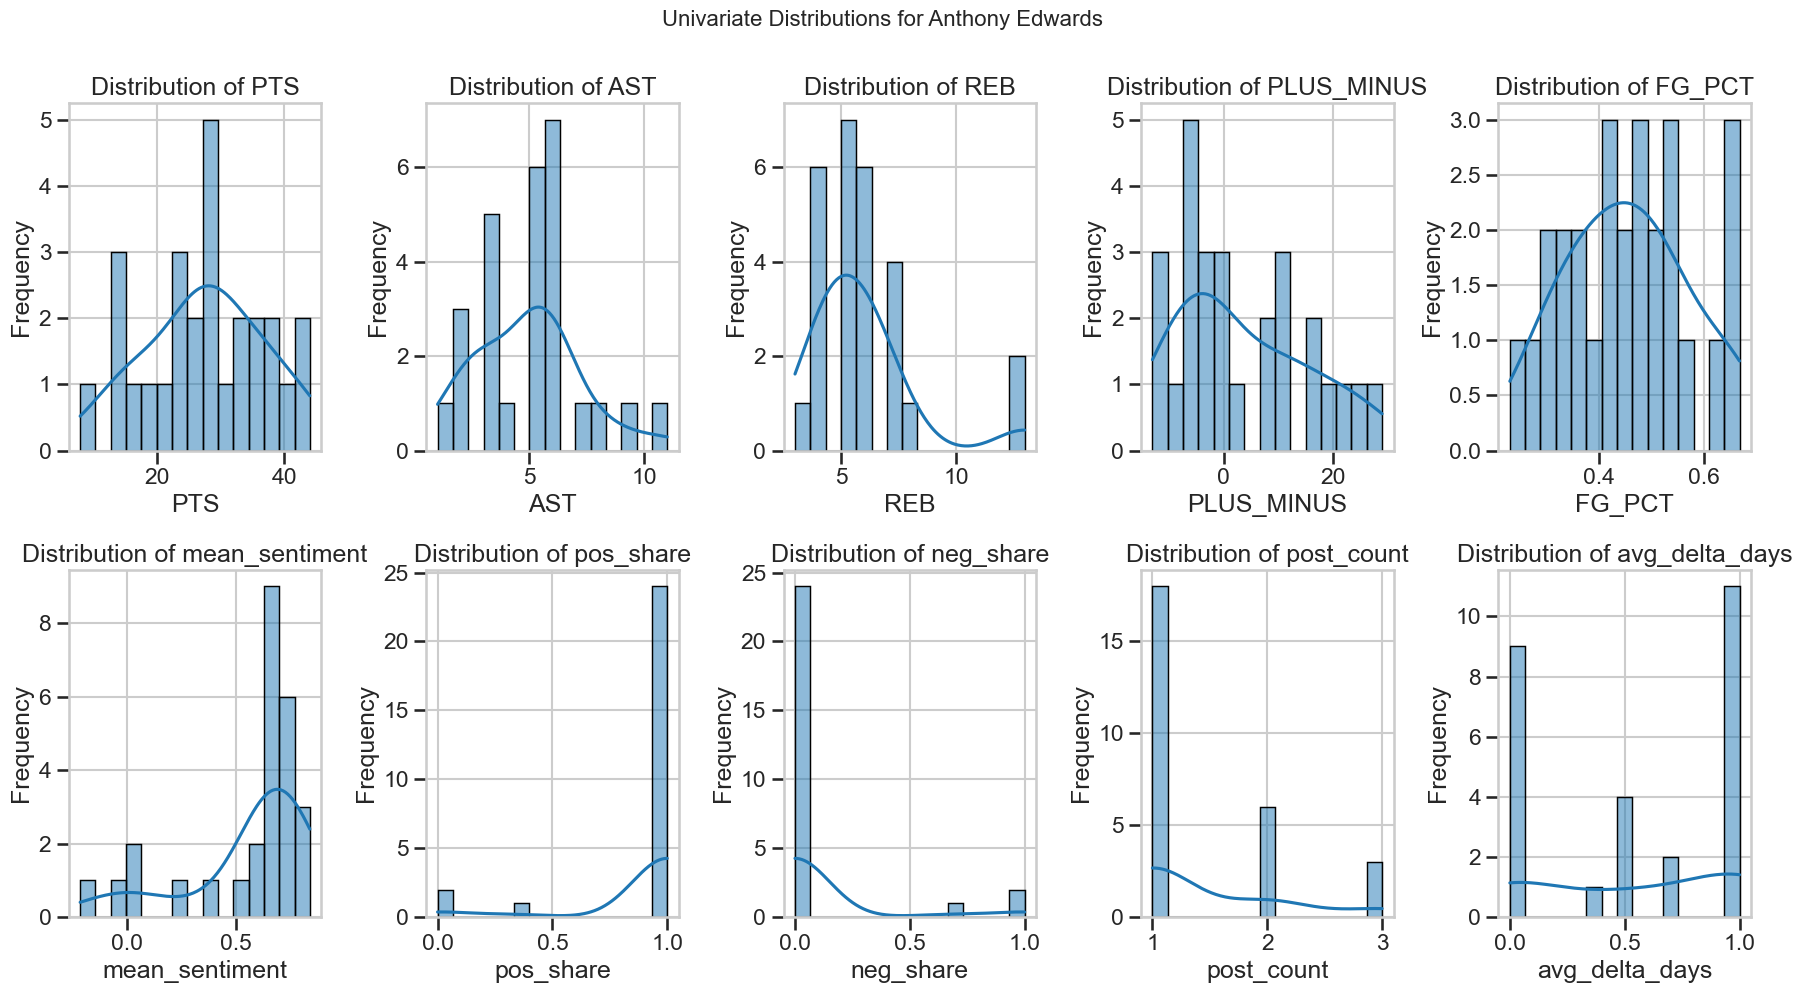


--- Correlation Analysis for Anthony Edwards ---


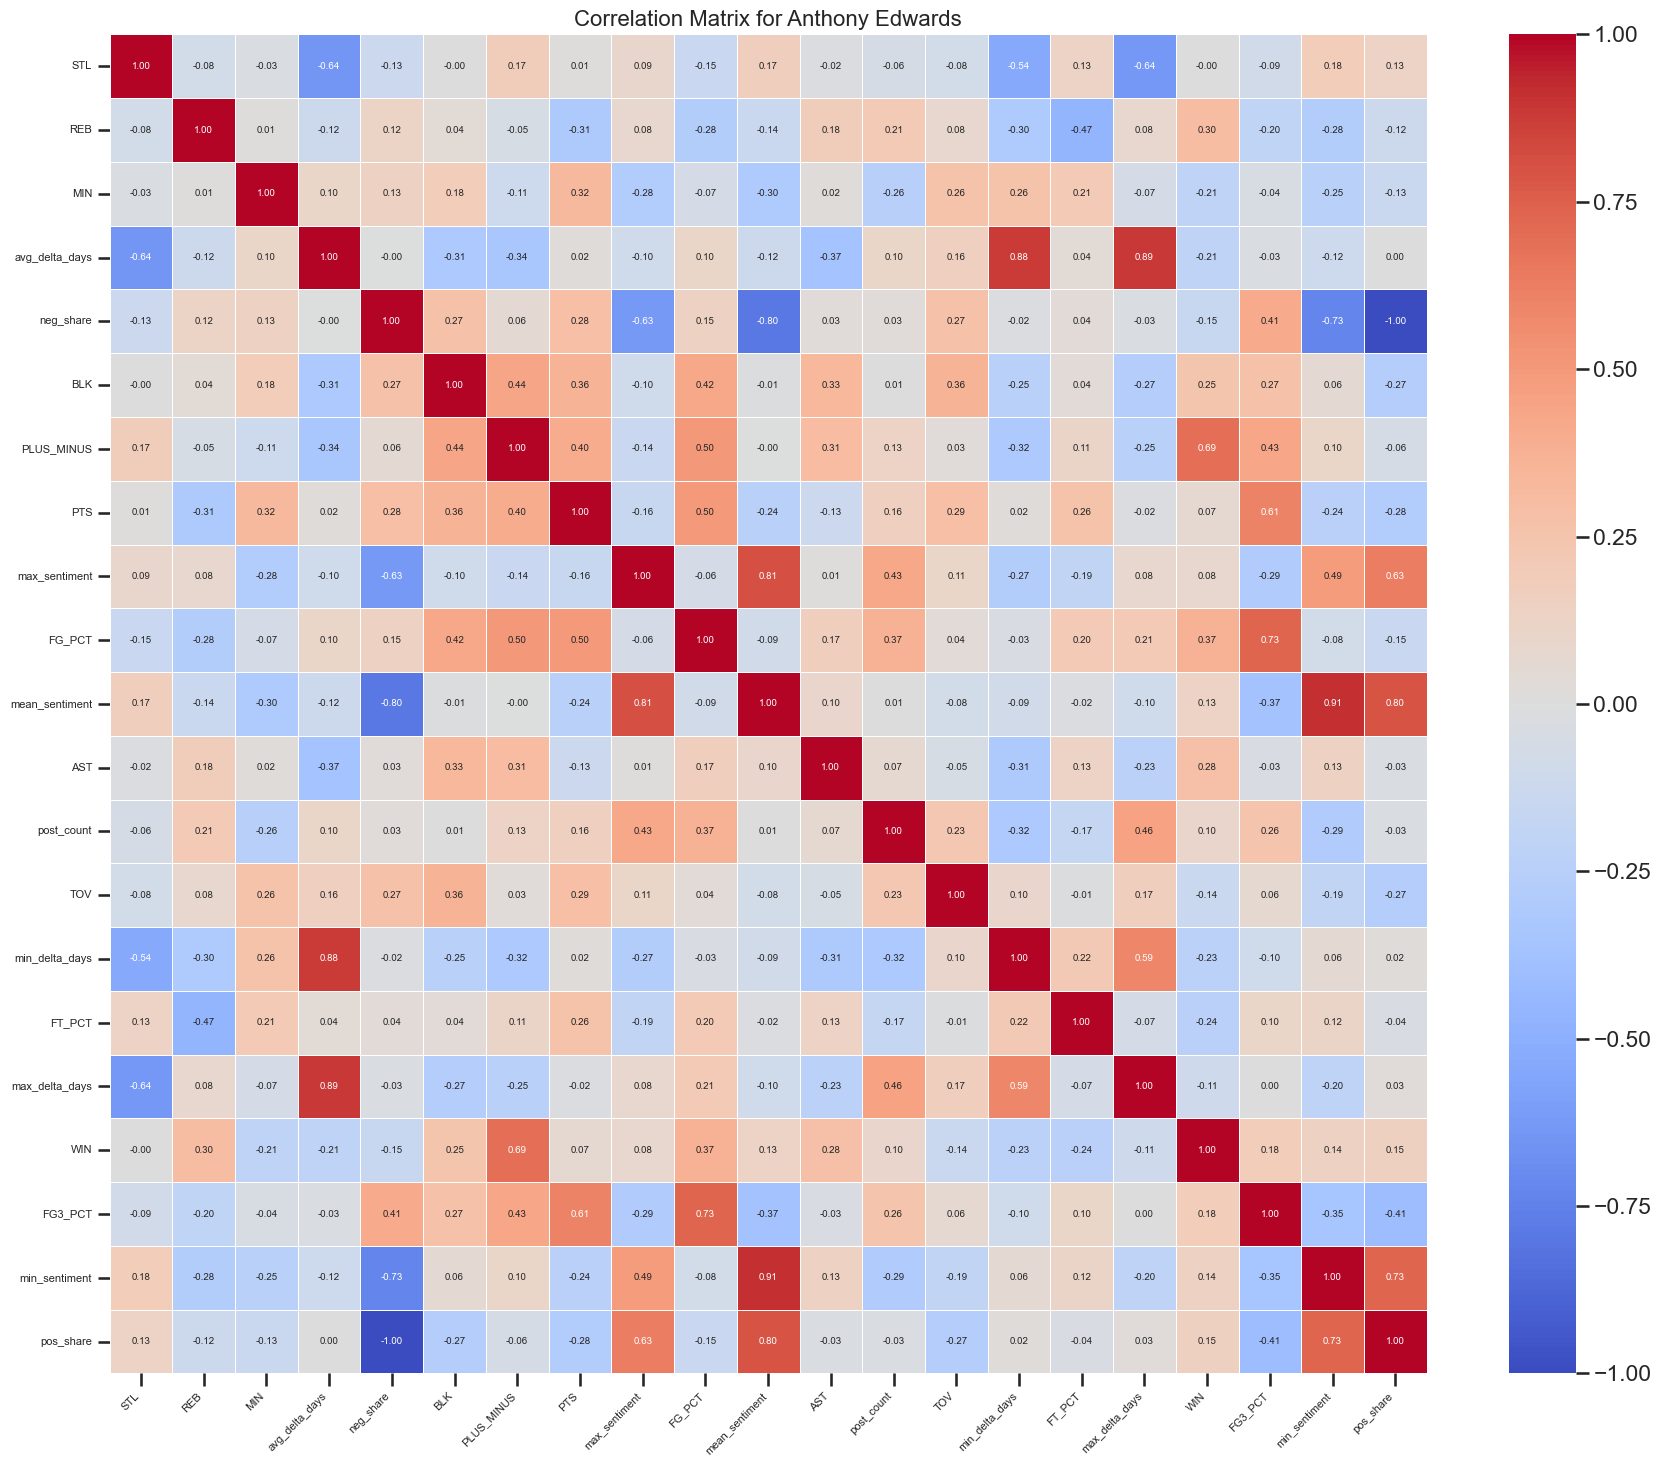


--- Unsupervised Clustering for Anthony Edwards ---
   • PCA two‑component variance: 0.568


C:\Users\realo\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


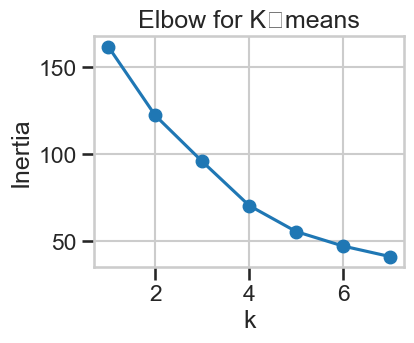

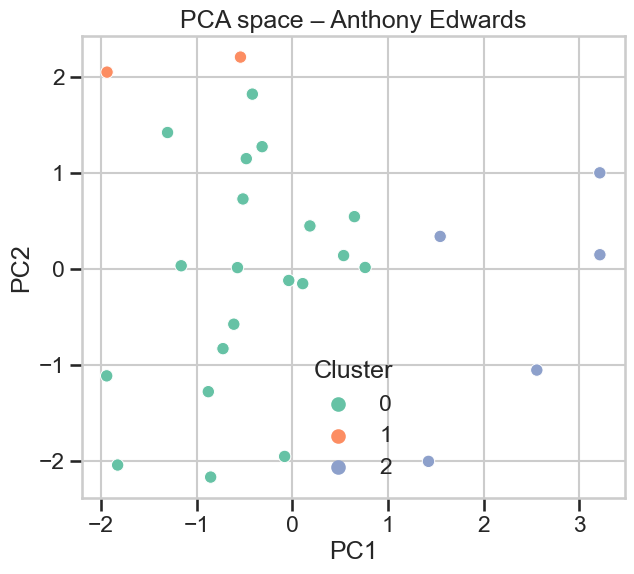

Cluster medians:


PTS  AST   REB  PLUS_MINUS  mean_sentiment  sent_intensity  WIN
cluster                                                                  
0        27.5  5.0   5.0         0.5            0.67            0.75  1.0
1        15.0  7.0  13.0        -3.5            0.54            1.08  1.0
2        36.0  2.0   6.0        -2.0            0.03            0.04  0.0


--- Bivariate Scatter Plots for Anthony Edwards ---


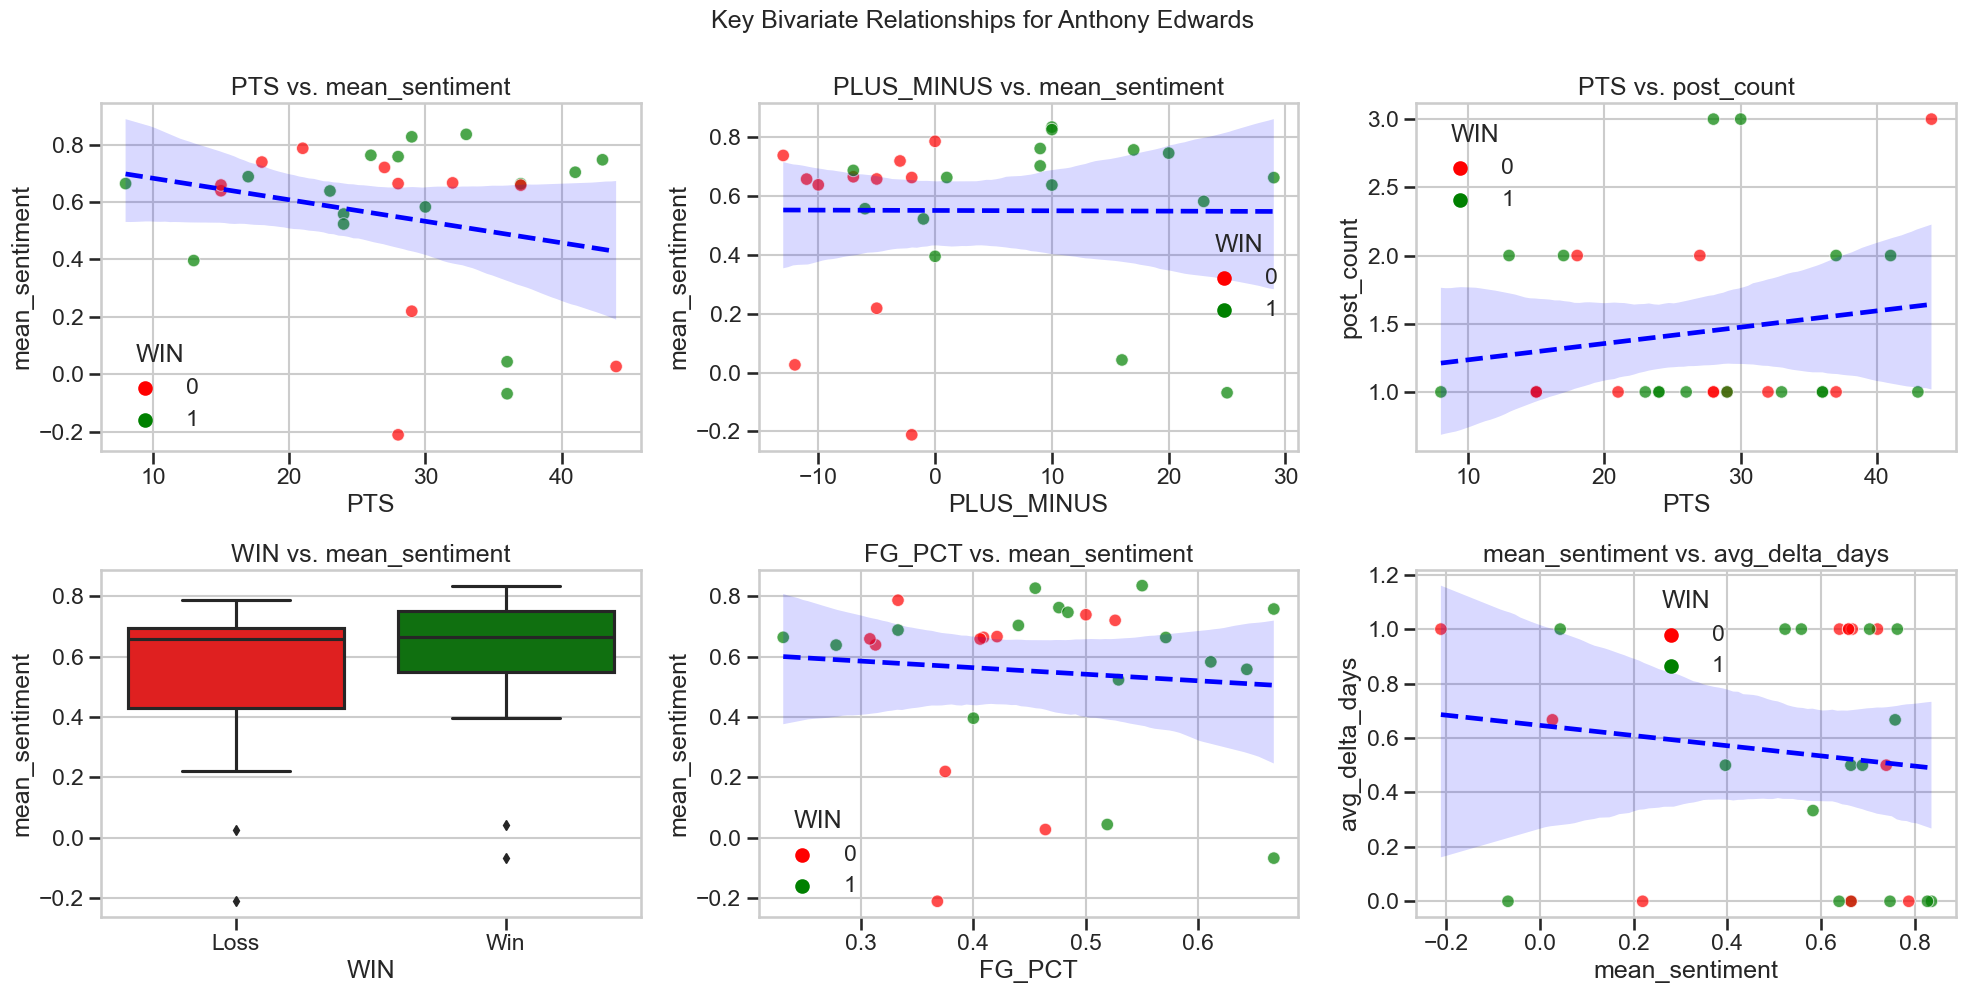


--- Sentiment Analysis by Game Outcome for Anthony Edwards ---


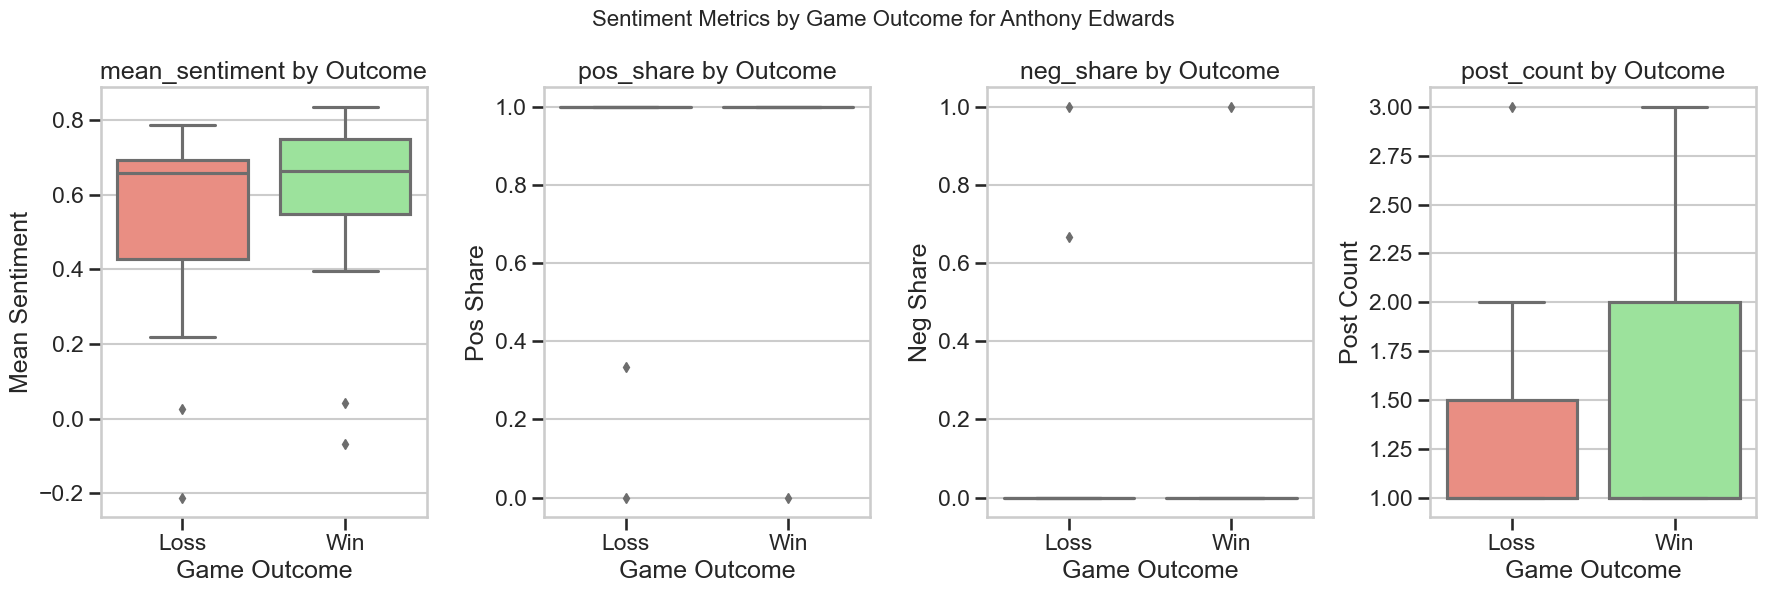


--- Finished processing Anthony Edwards ---


==================== PROCESSING: Donovan Mitchell ====================

--- Loading data for Donovan Mitchell from donovan_mitchell_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 194
Rows before filtering on post_count: 194
Rows after filtering for post_count > 0: 24
Filtered data to 24 games with sentiment (post_count > 0).

--- Univariate Distributions for Donovan Mitchell ---


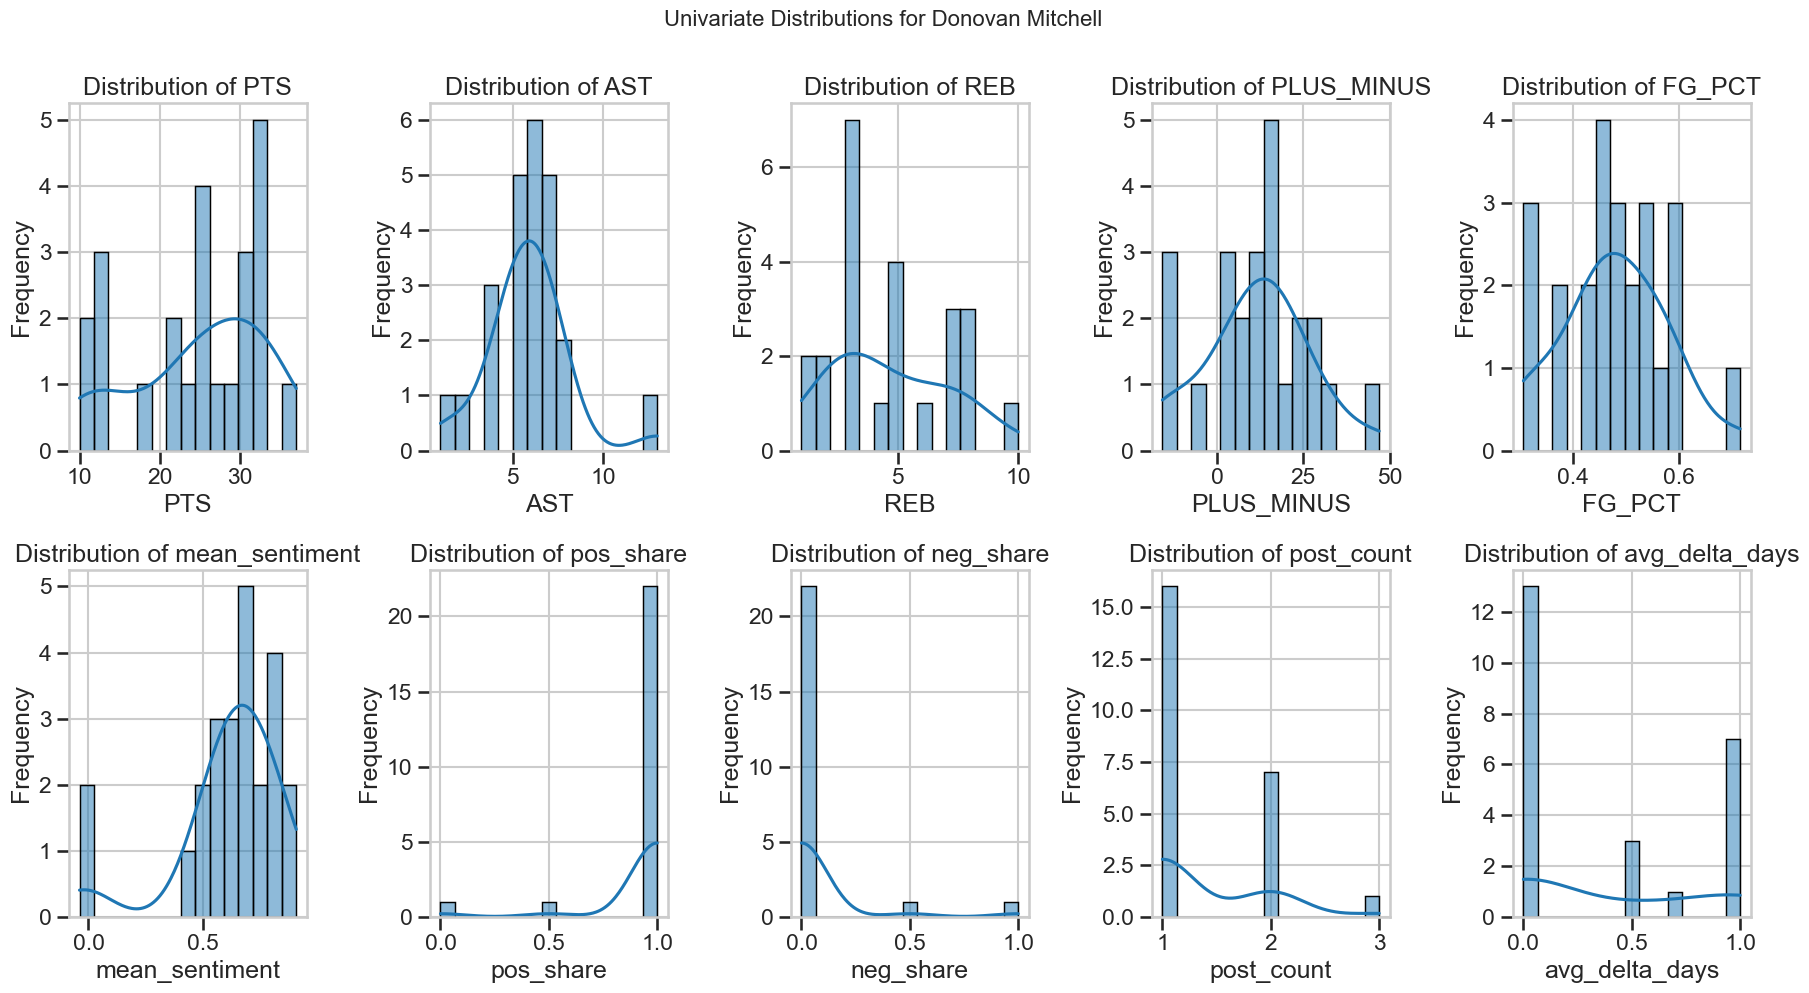


--- Correlation Analysis for Donovan Mitchell ---


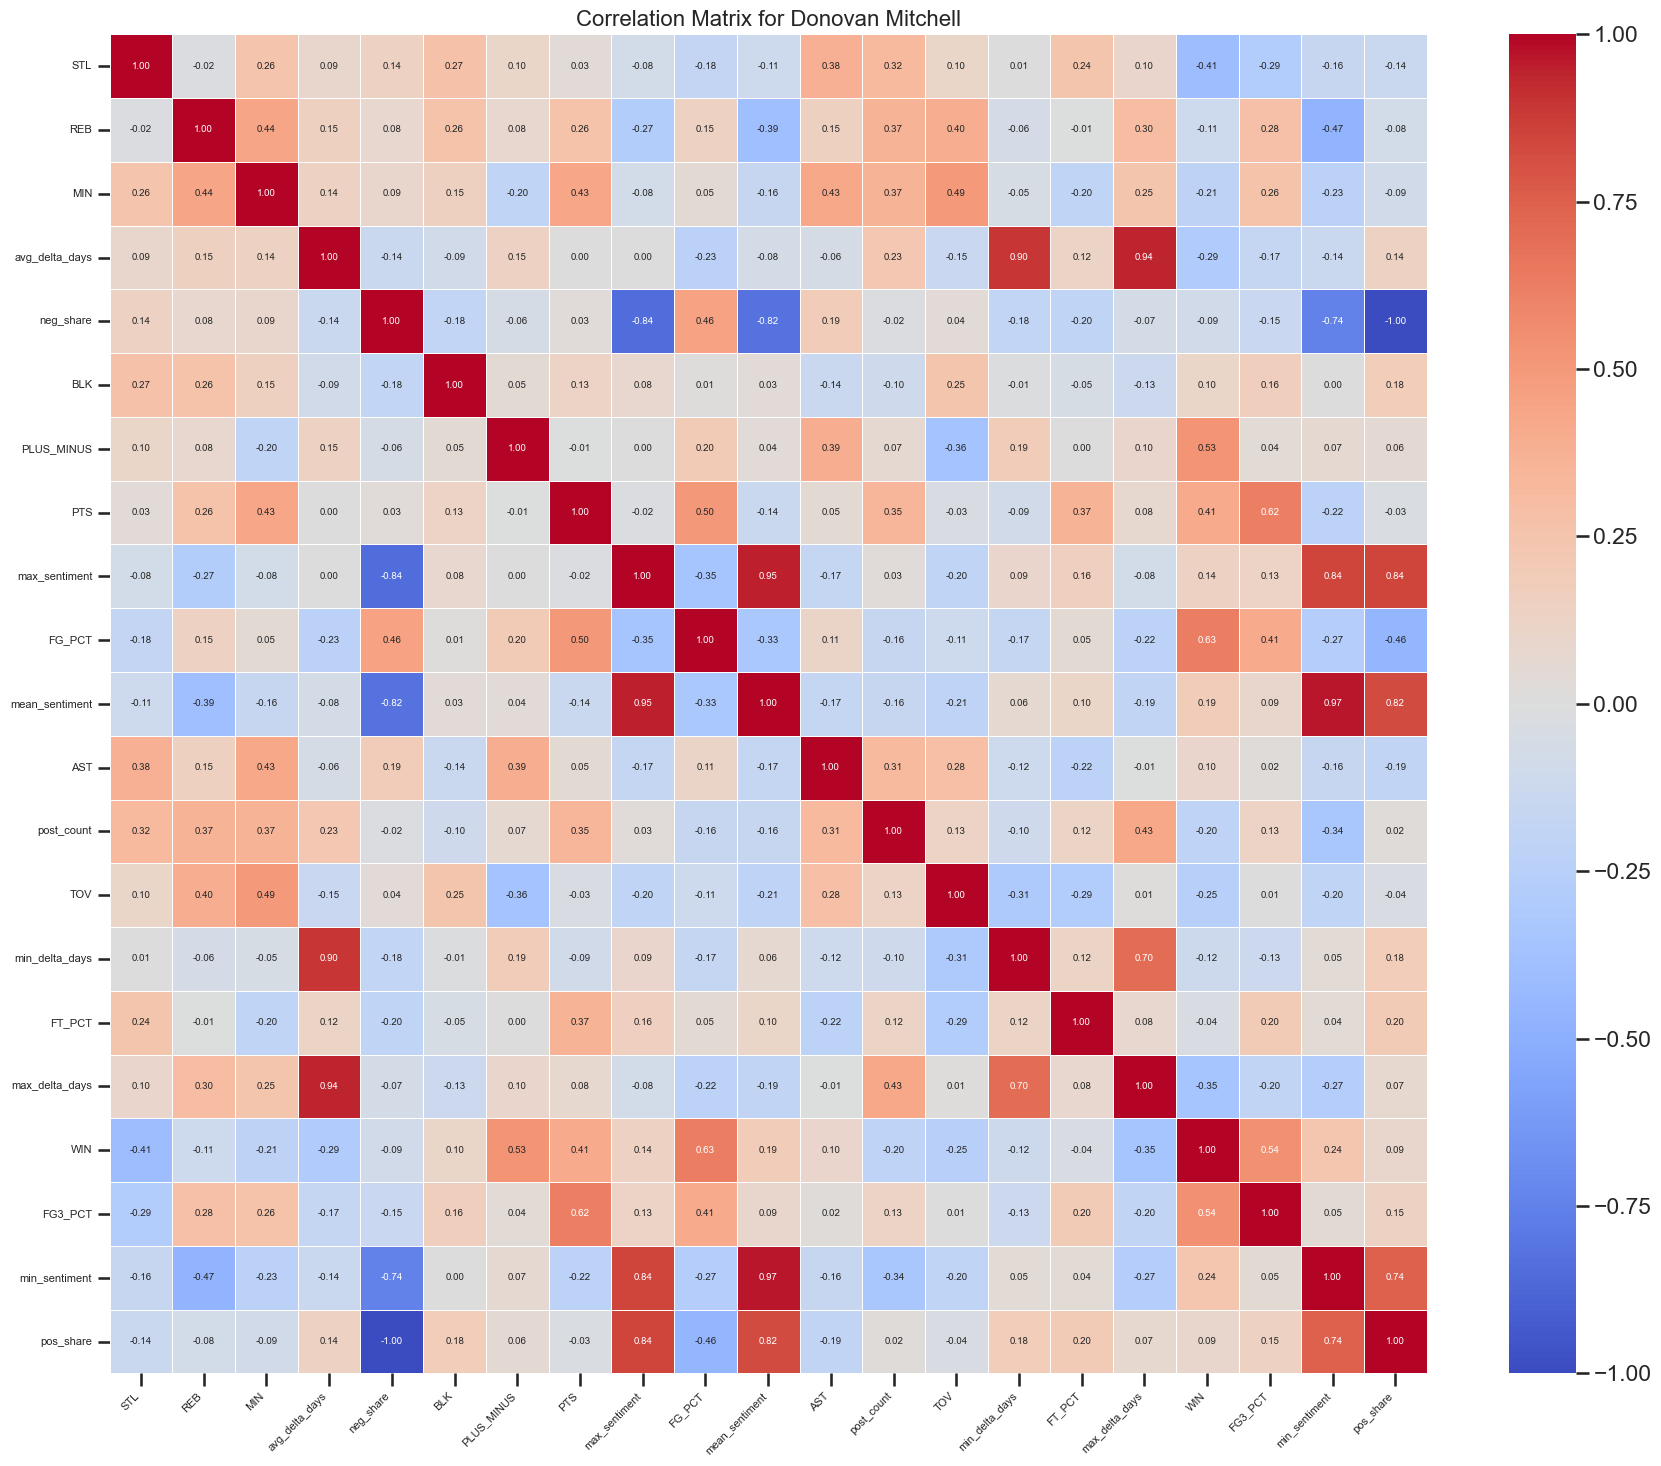


--- Unsupervised Clustering for Donovan Mitchell ---
   • PCA two‑component variance: 0.56


C:\Users\realo\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


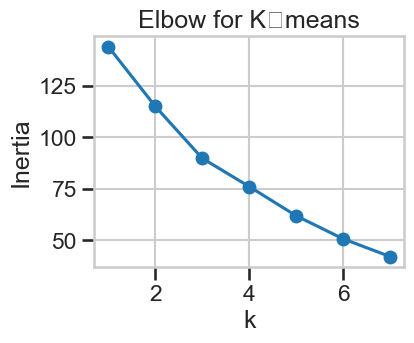

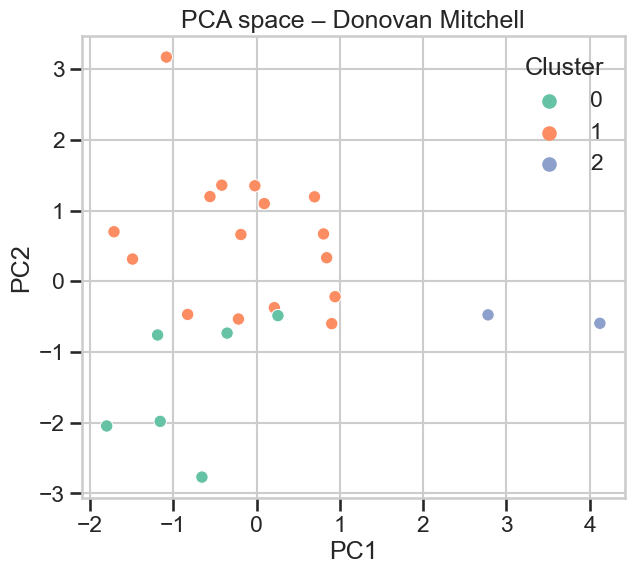

Cluster medians:


PTS  AST  REB  PLUS_MINUS  mean_sentiment  sent_intensity  WIN
cluster                                                                 
0        12.5  4.5  3.0         5.5            0.73            0.73  0.5
1        30.0  6.0  5.0        15.5            0.66            0.85  1.0
2        27.0  7.0  6.5         5.0           -0.02           -0.02  0.5


--- Bivariate Scatter Plots for Donovan Mitchell ---


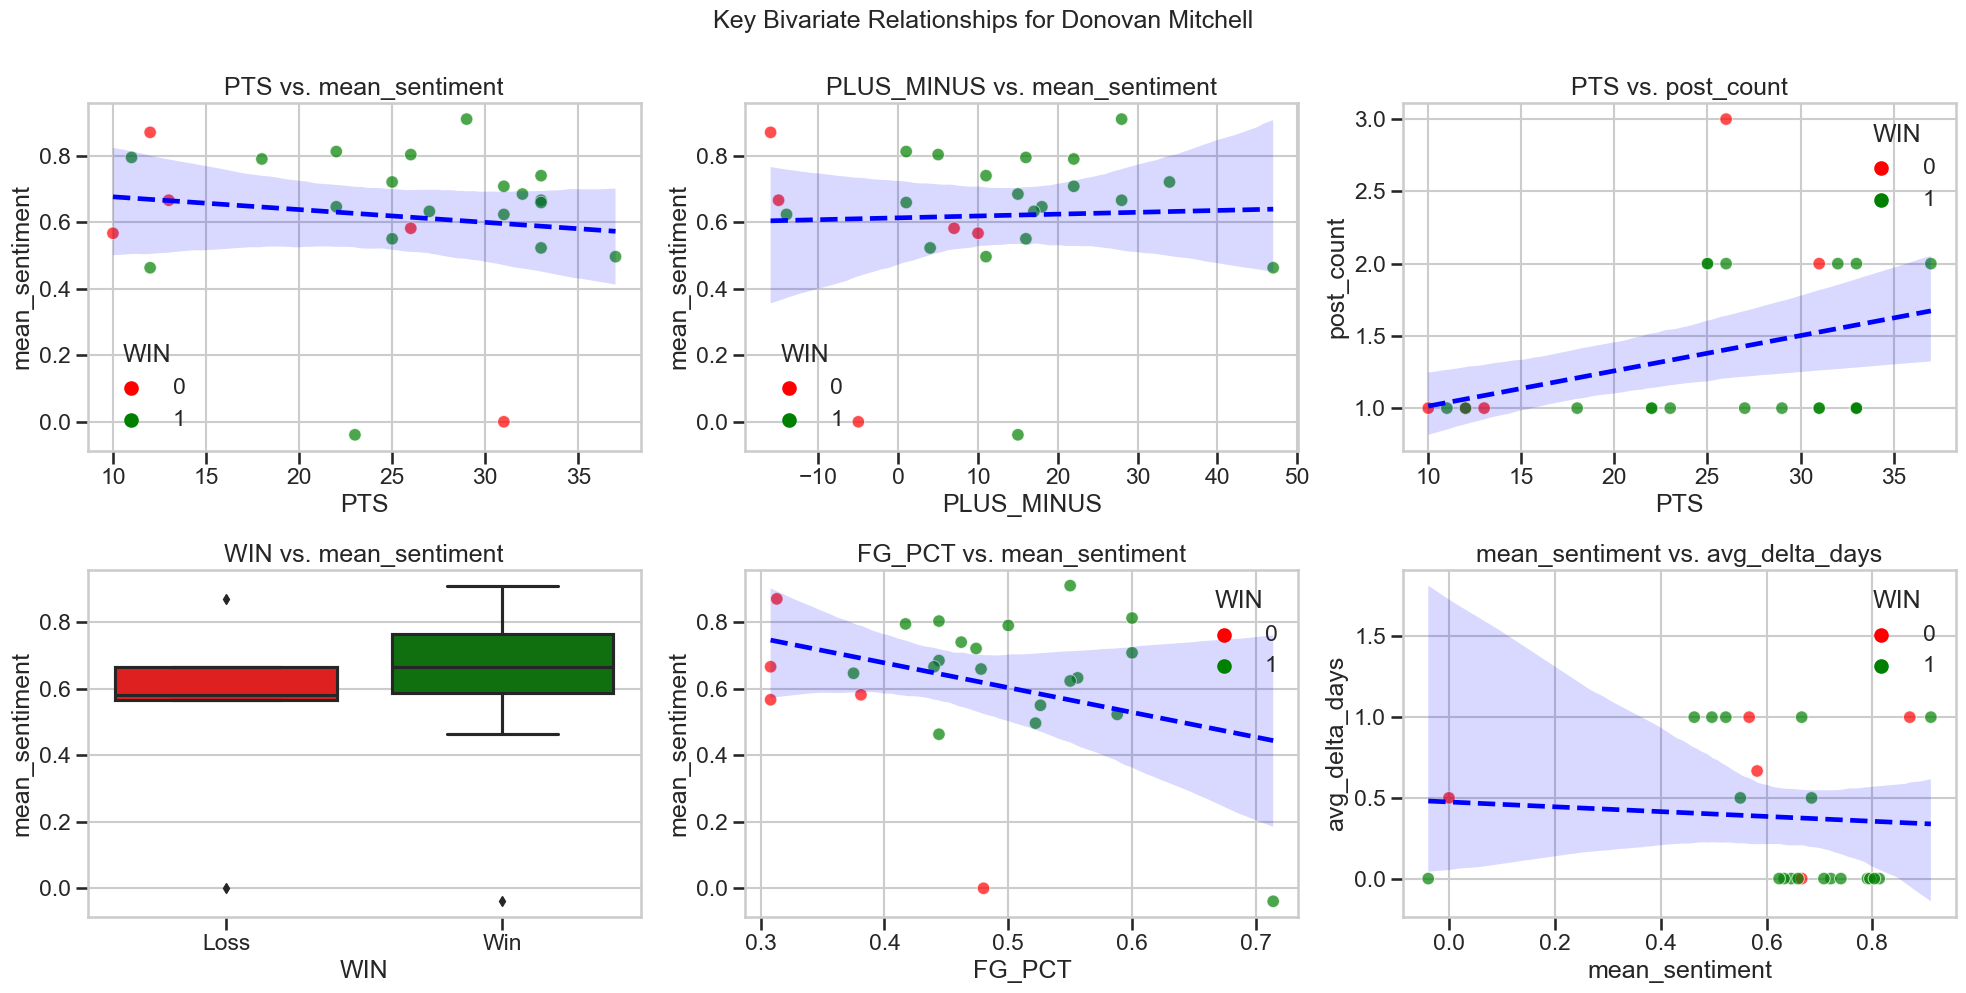


--- Sentiment Analysis by Game Outcome for Donovan Mitchell ---


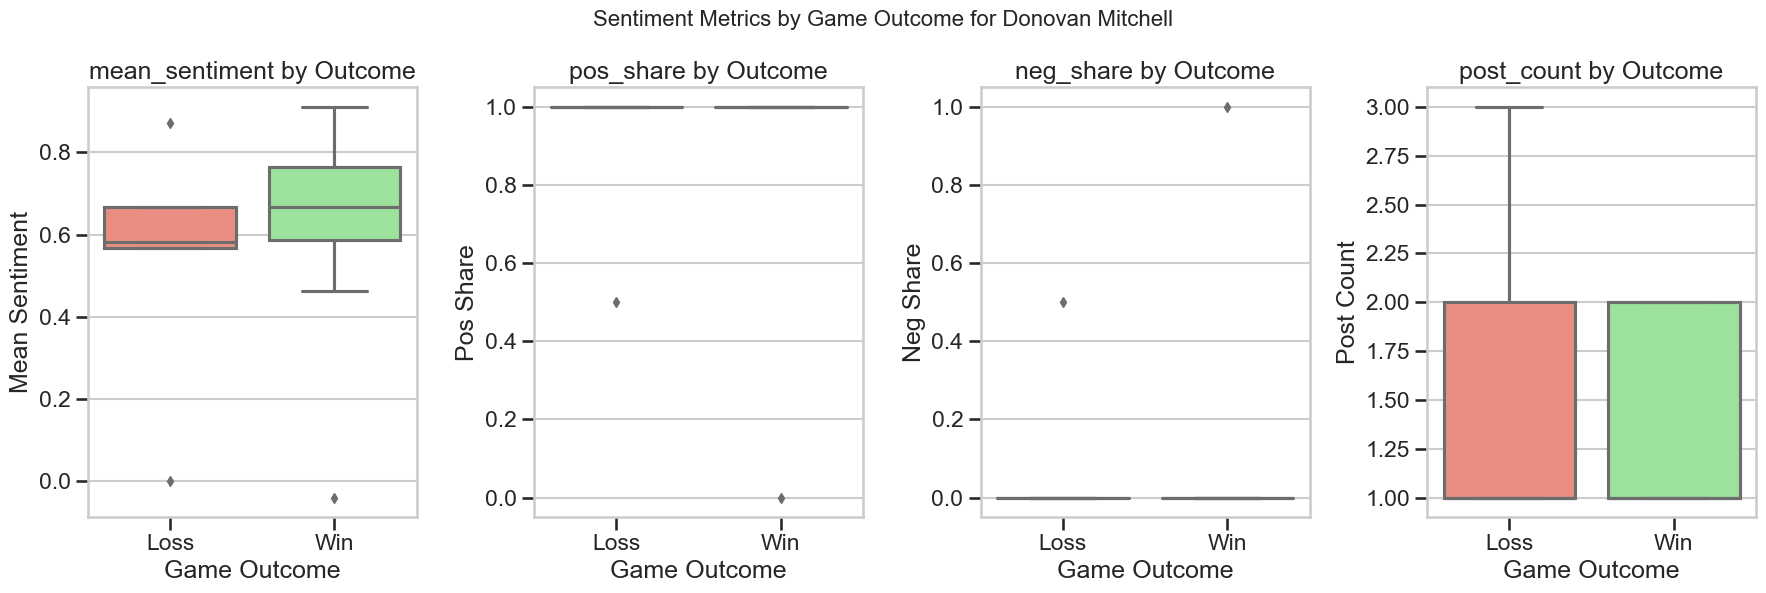


--- Finished processing Donovan Mitchell ---


==================== PROCESSING: Giannis Antetokounmpo ====================

--- Loading data for Giannis Antetokounmpo from giannis_antetokounmpo_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 203
Rows before filtering on post_count: 203
Rows after filtering for post_count > 0: 24
Filtered data to 24 games with sentiment (post_count > 0).

--- Univariate Distributions for Giannis Antetokounmpo ---


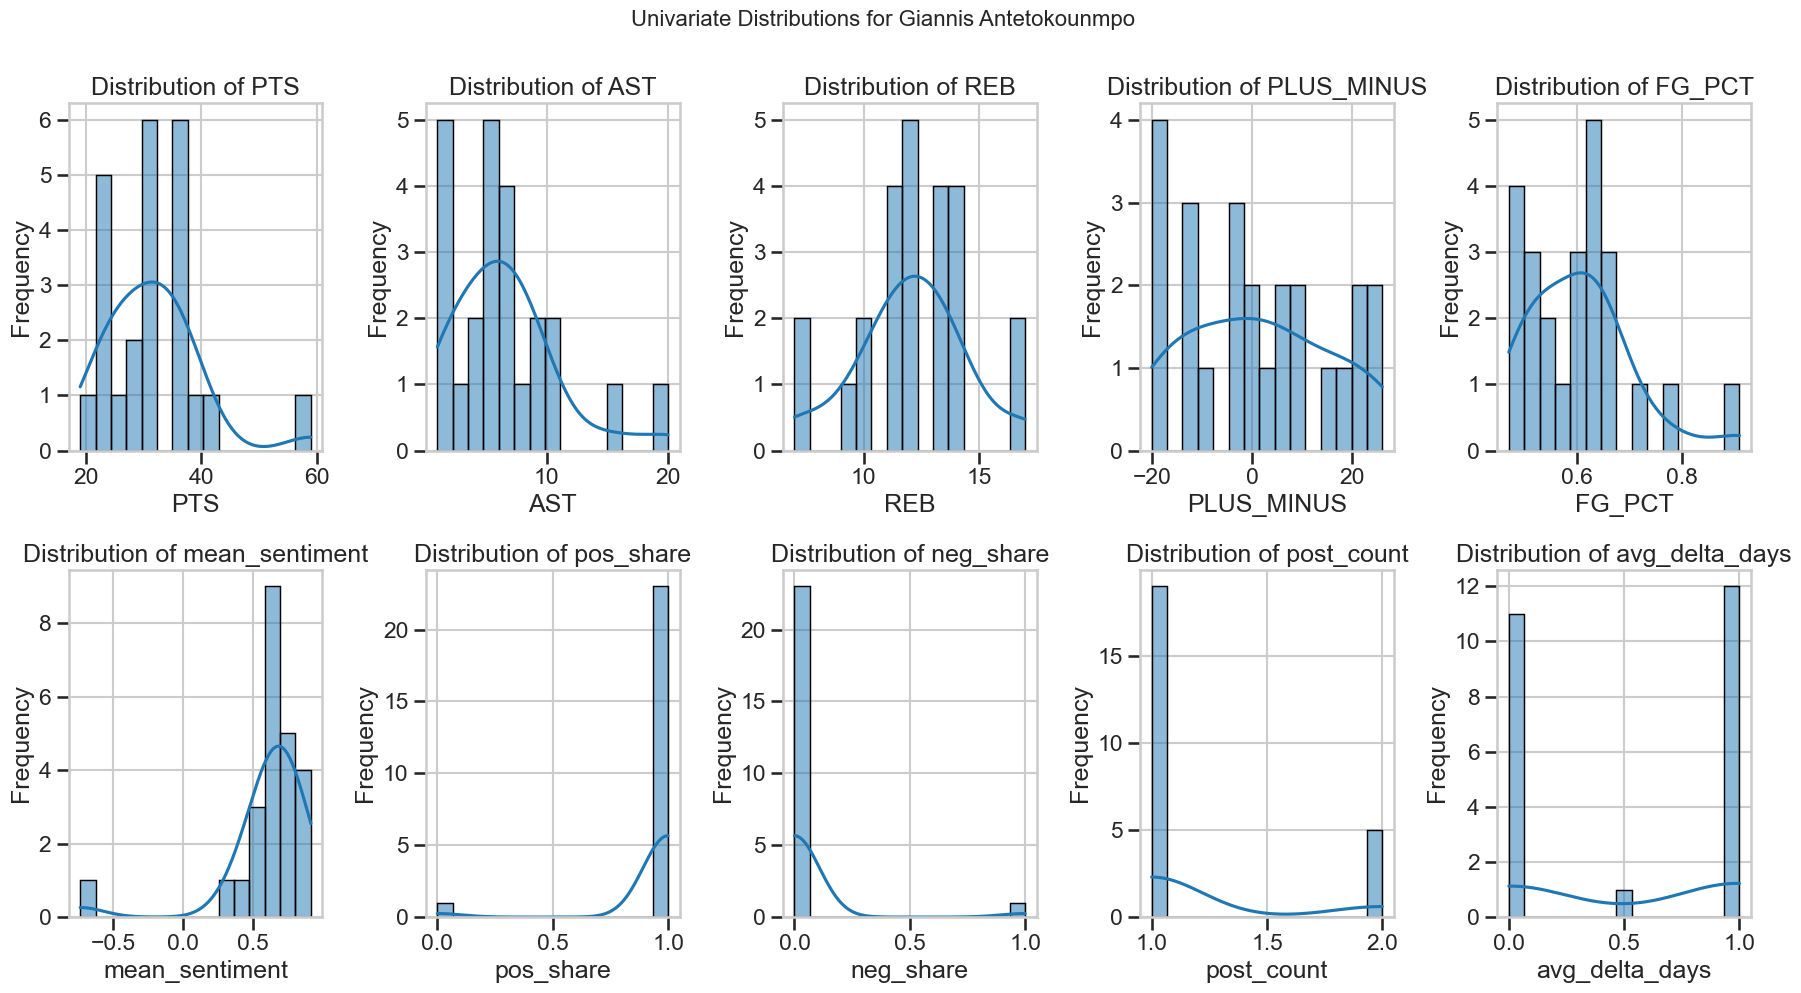


--- Correlation Analysis for Giannis Antetokounmpo ---


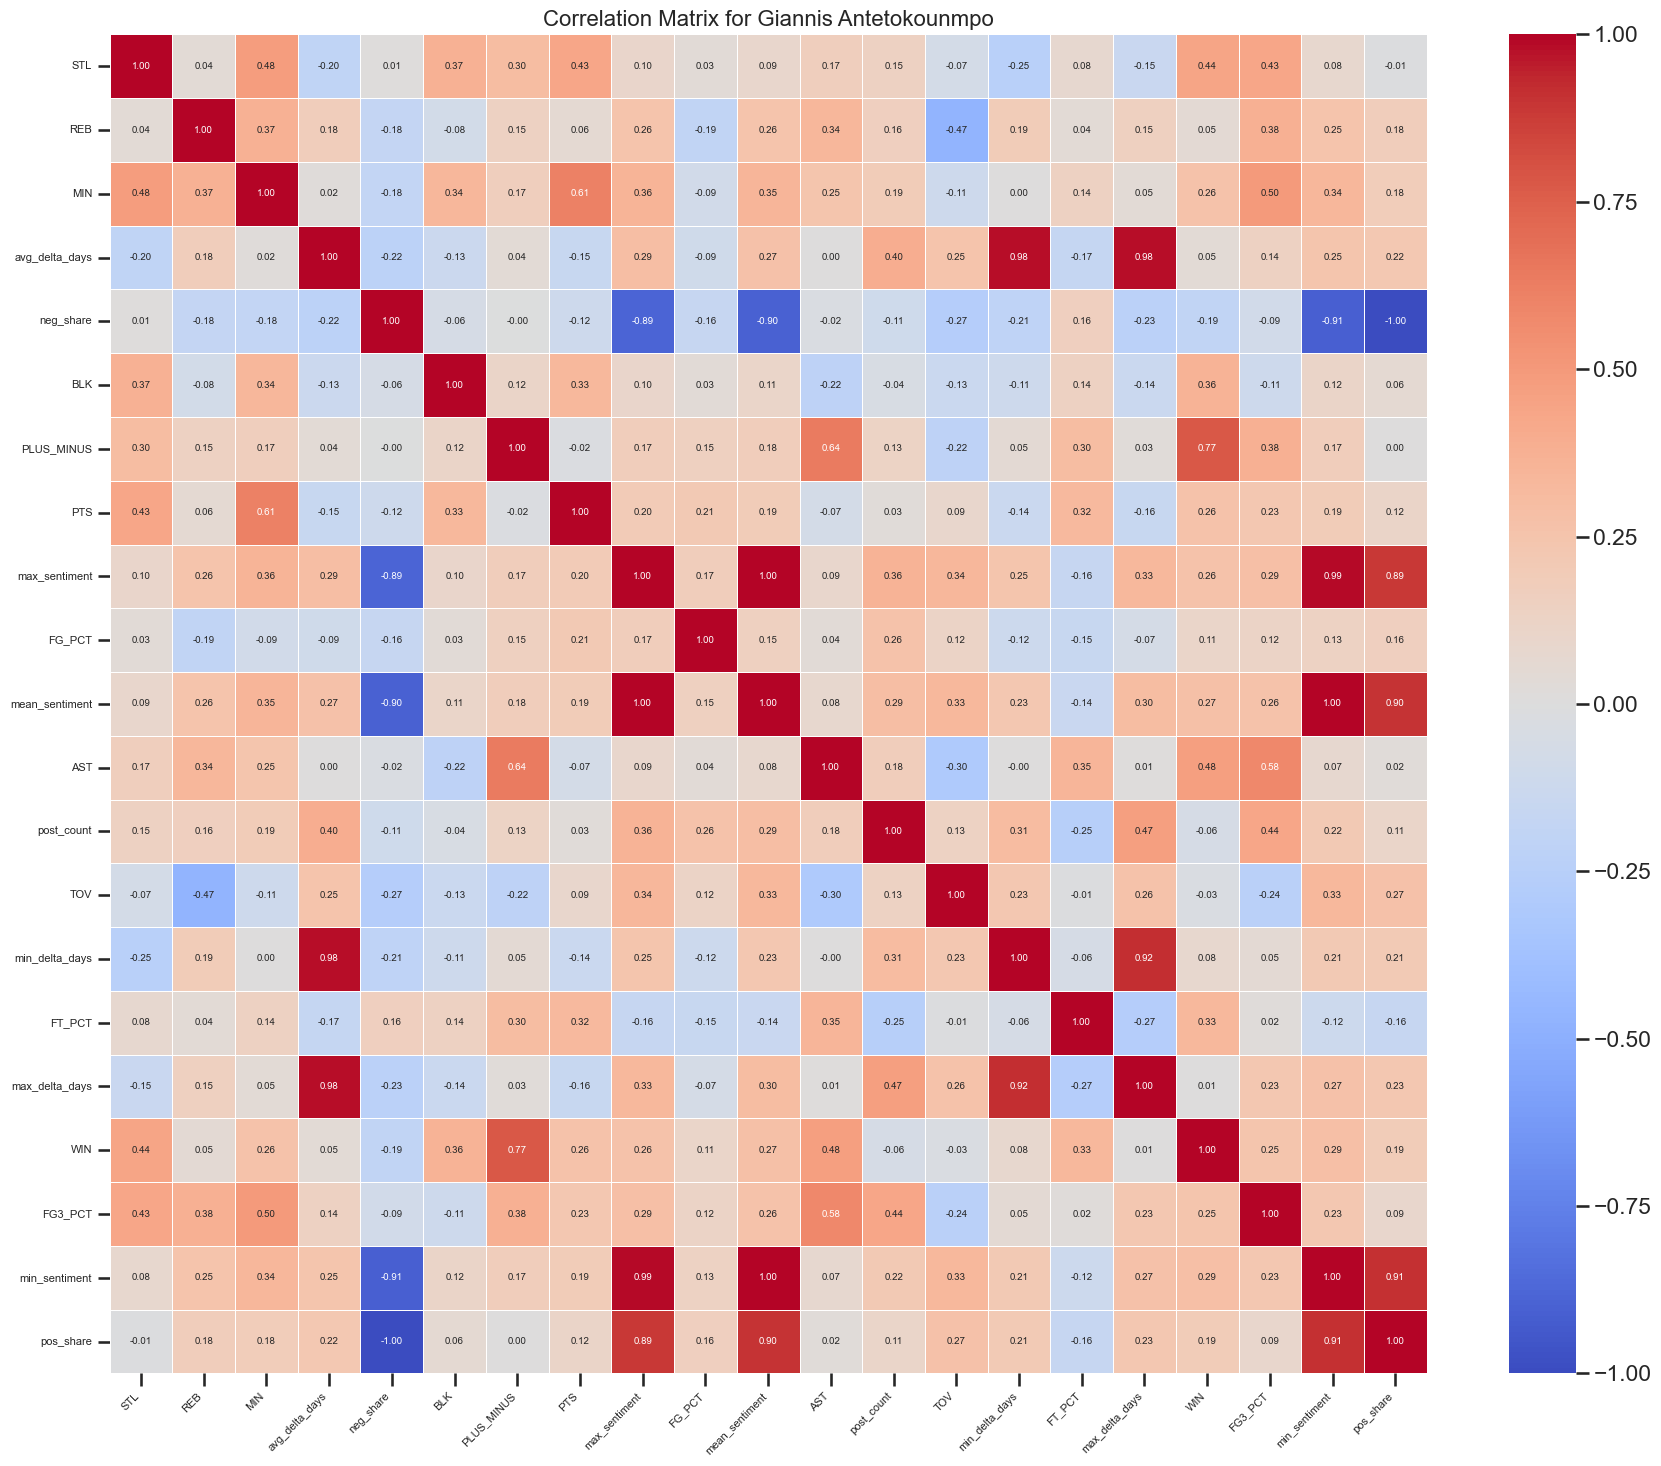


--- Unsupervised Clustering for Giannis Antetokounmpo ---
   • PCA two‑component variance: 0.623


C:\Users\realo\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


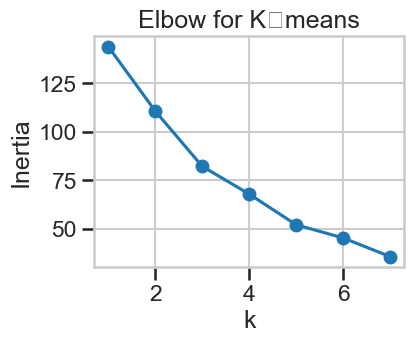

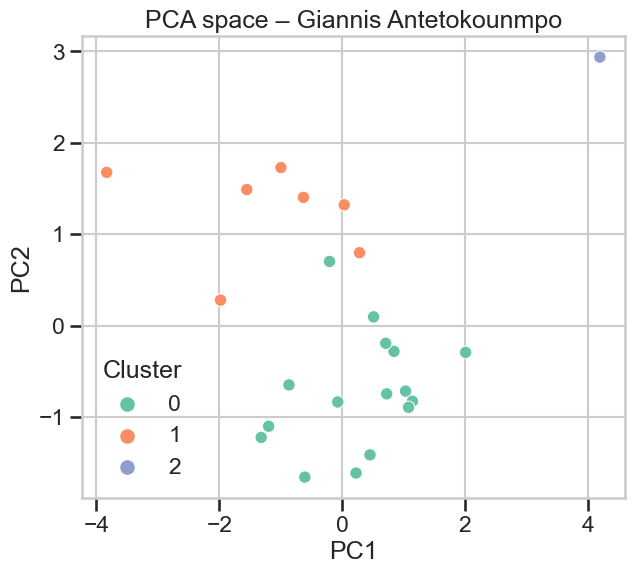

Cluster medians:


PTS   AST   REB  PLUS_MINUS  mean_sentiment  sent_intensity  WIN
cluster                                                                   
0        33.5   4.5  12.0        -6.5            0.66            0.66  0.0
1        26.0  10.0  12.0        22.0            0.66            0.66  1.0
2        27.0   6.0  10.0         1.0           -0.73           -0.73  0.0


--- Bivariate Scatter Plots for Giannis Antetokounmpo ---


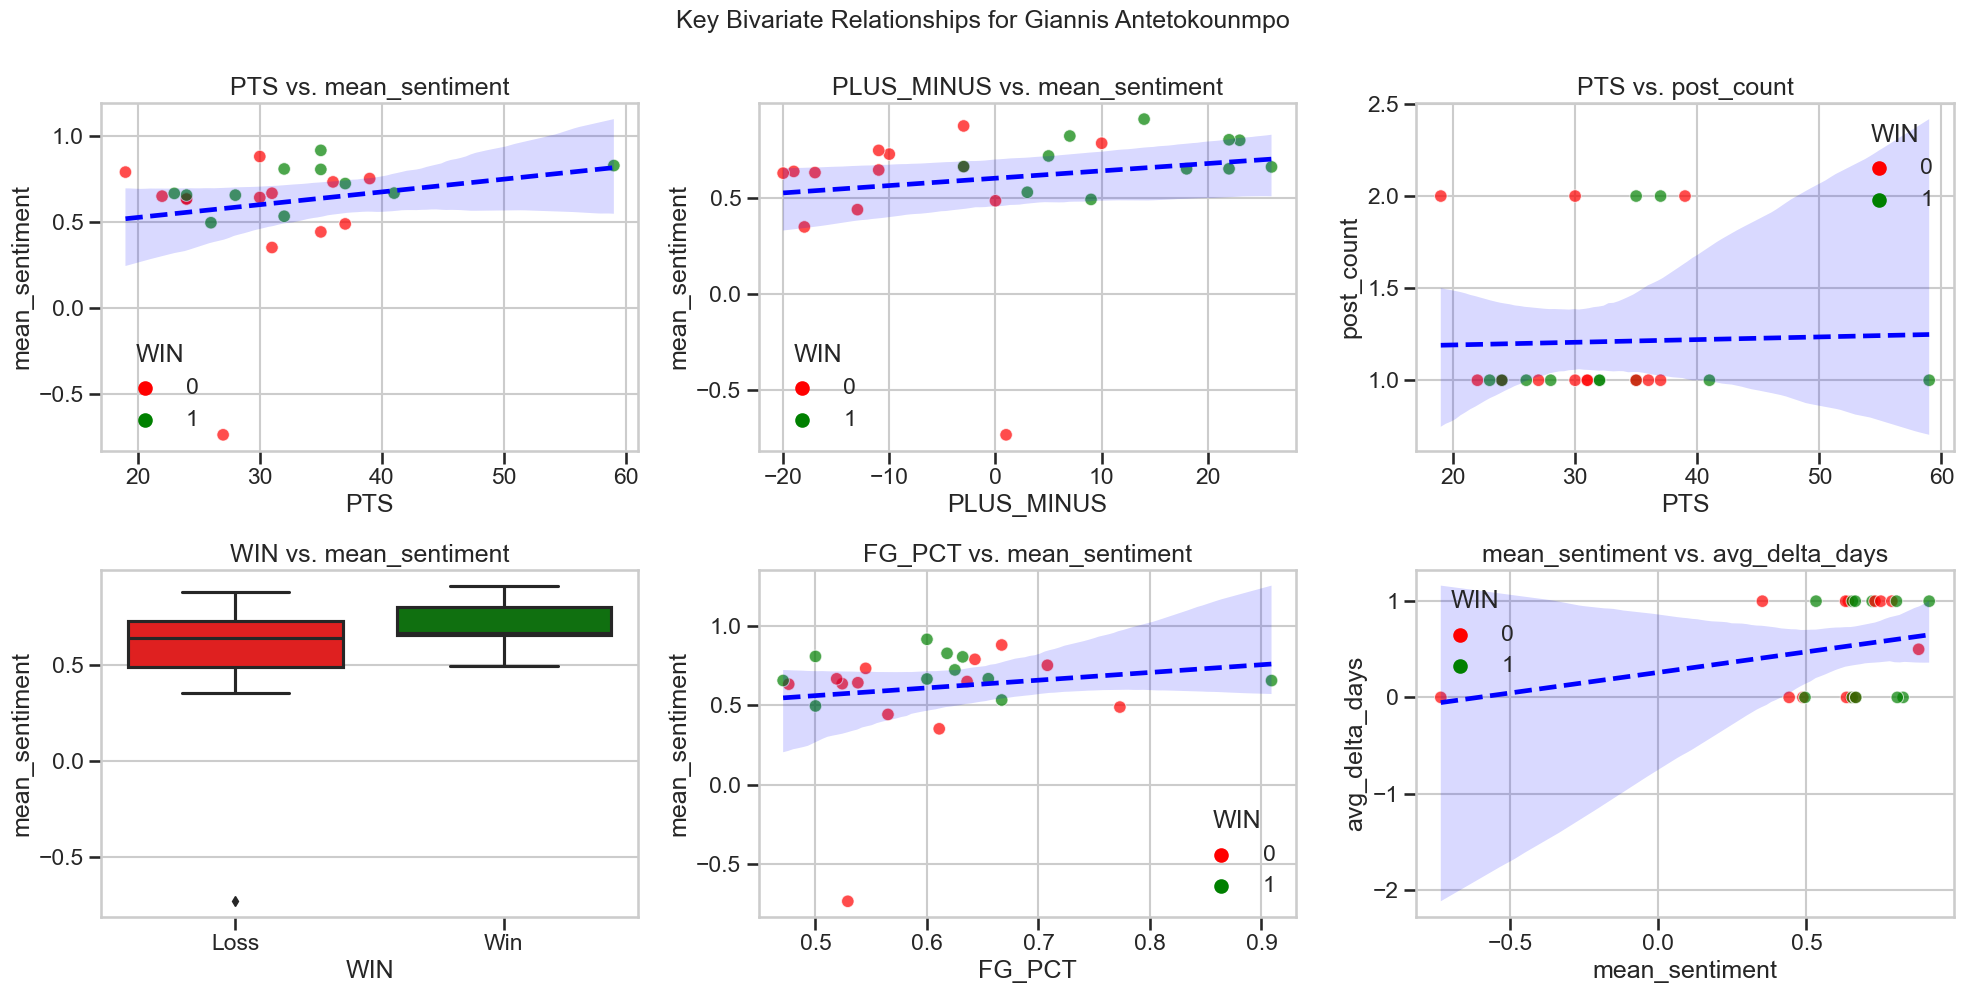


--- Sentiment Analysis by Game Outcome for Giannis Antetokounmpo ---


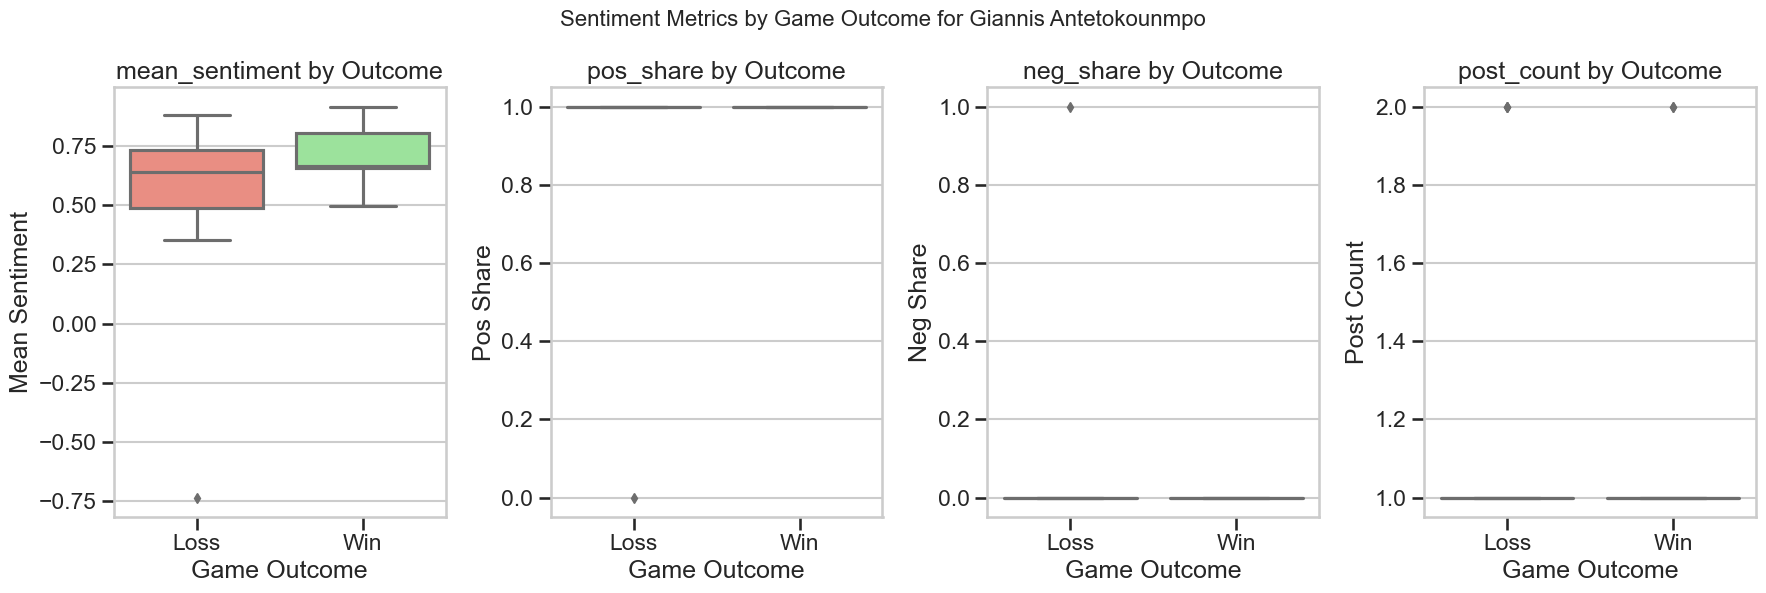


--- Finished processing Giannis Antetokounmpo ---


==================== PROCESSING: Jalen Brunson ====================

--- Loading data for Jalen Brunson from jalen_brunson_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 210
Rows before filtering on post_count: 210
Rows after filtering for post_count > 0: 24
Filtered data to 24 games with sentiment (post_count > 0).

--- Univariate Distributions for Jalen Brunson ---


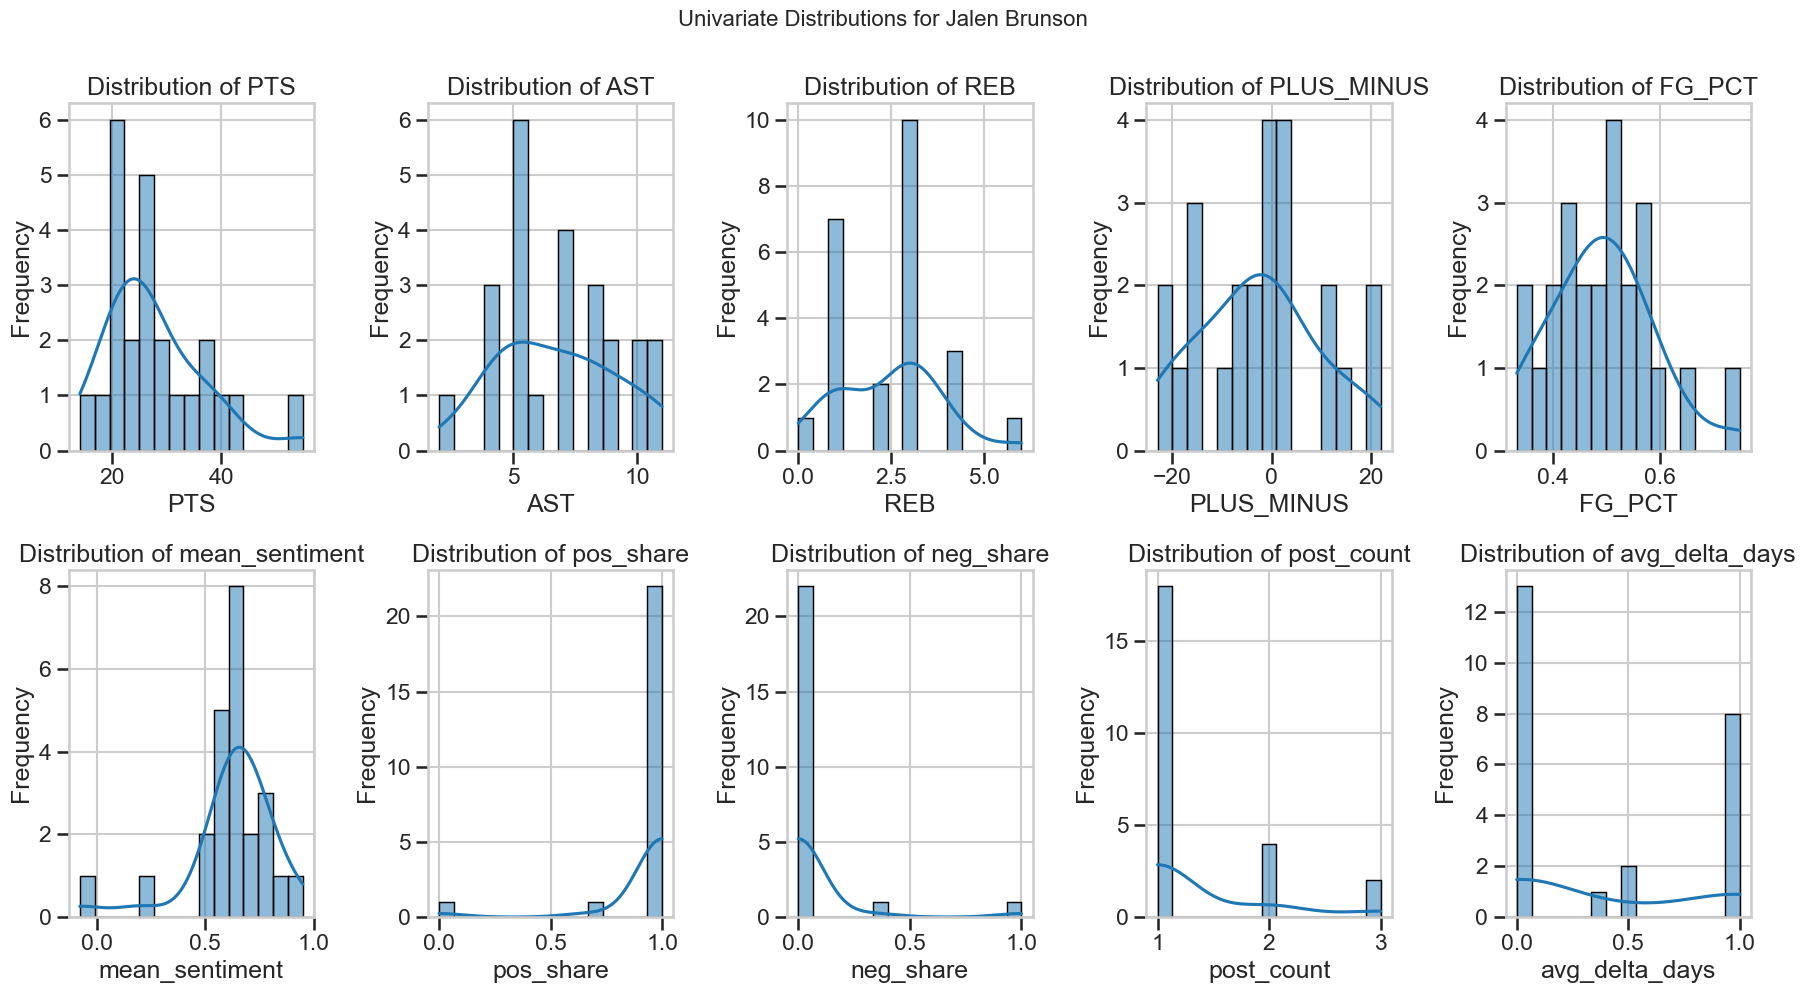


--- Correlation Analysis for Jalen Brunson ---


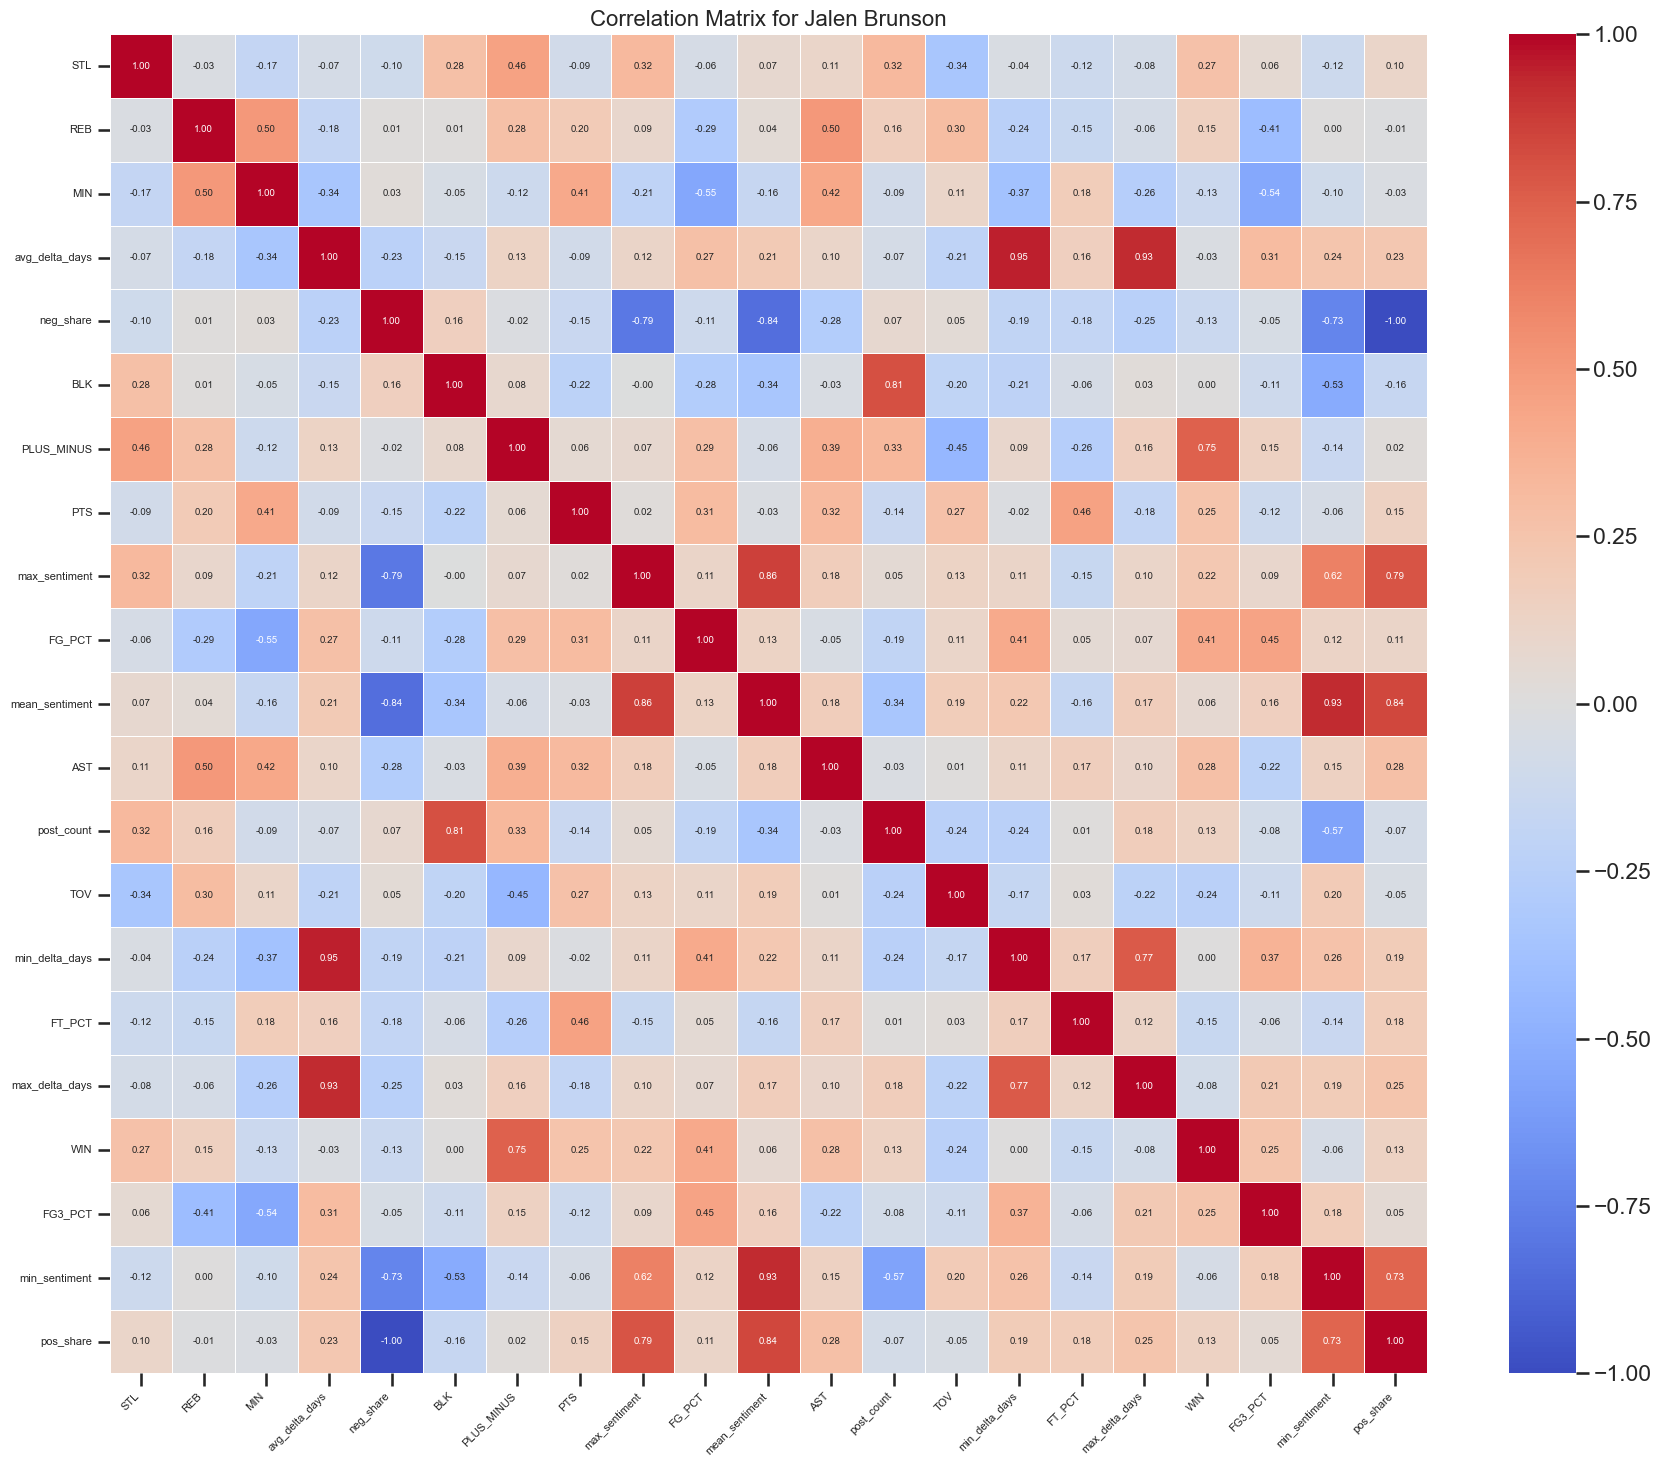


--- Unsupervised Clustering for Jalen Brunson ---
   • PCA two‑component variance: 0.583


C:\Users\realo\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


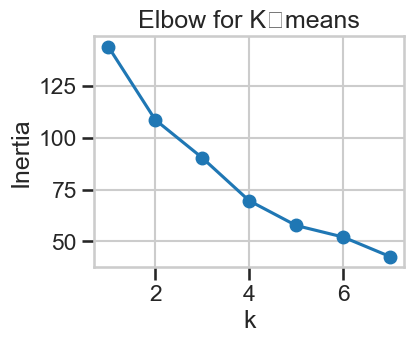

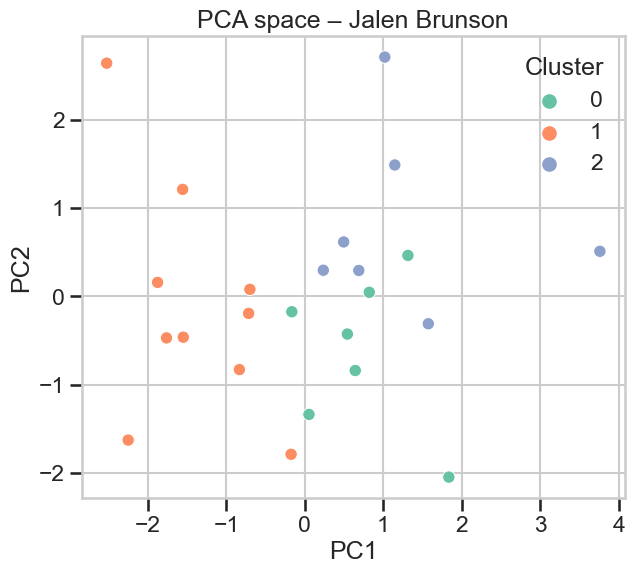

Cluster medians:


PTS  AST  REB  PLUS_MINUS  mean_sentiment  sent_intensity  WIN
cluster                                                                 
0        24.0  7.0  3.0        10.0            0.60            0.95  1.0
1        24.0  5.0  1.5       -15.0            0.66            0.66  0.0
2        37.0  9.0  3.0        -1.0            0.67            0.67  1.0


--- Bivariate Scatter Plots for Jalen Brunson ---


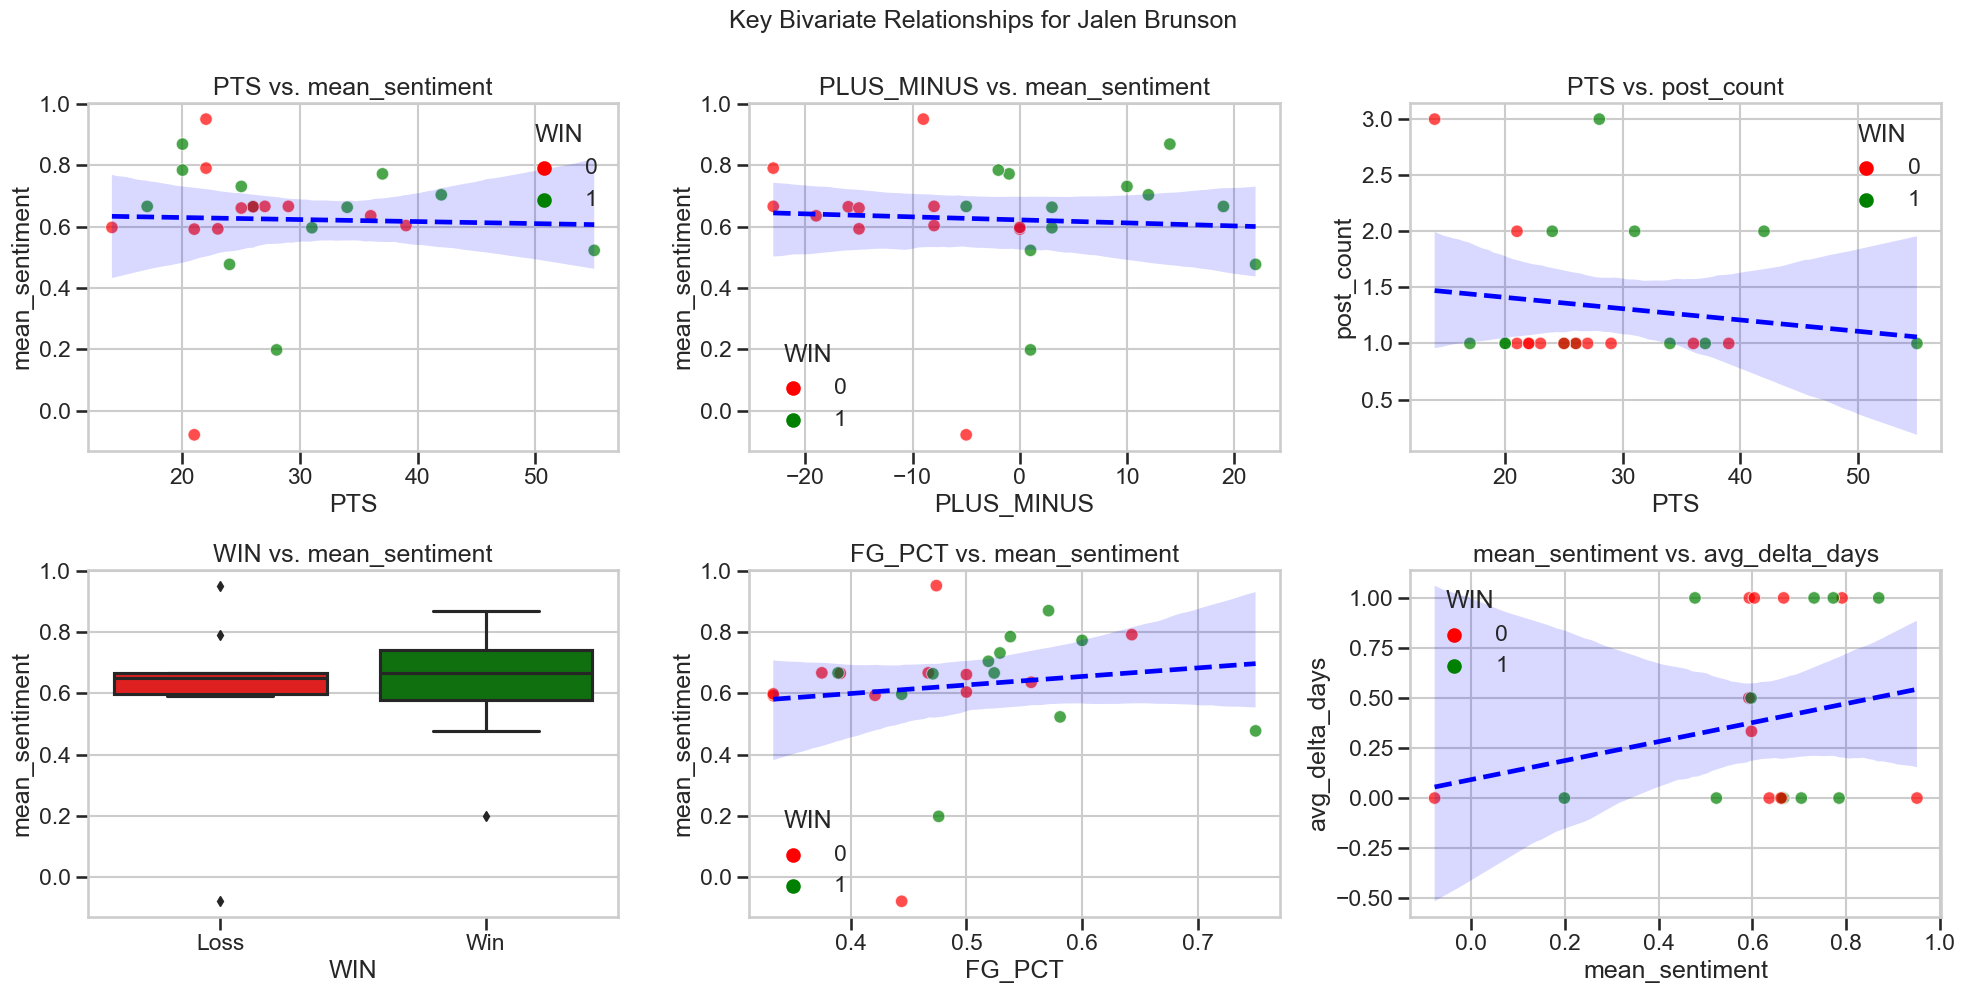


--- Sentiment Analysis by Game Outcome for Jalen Brunson ---


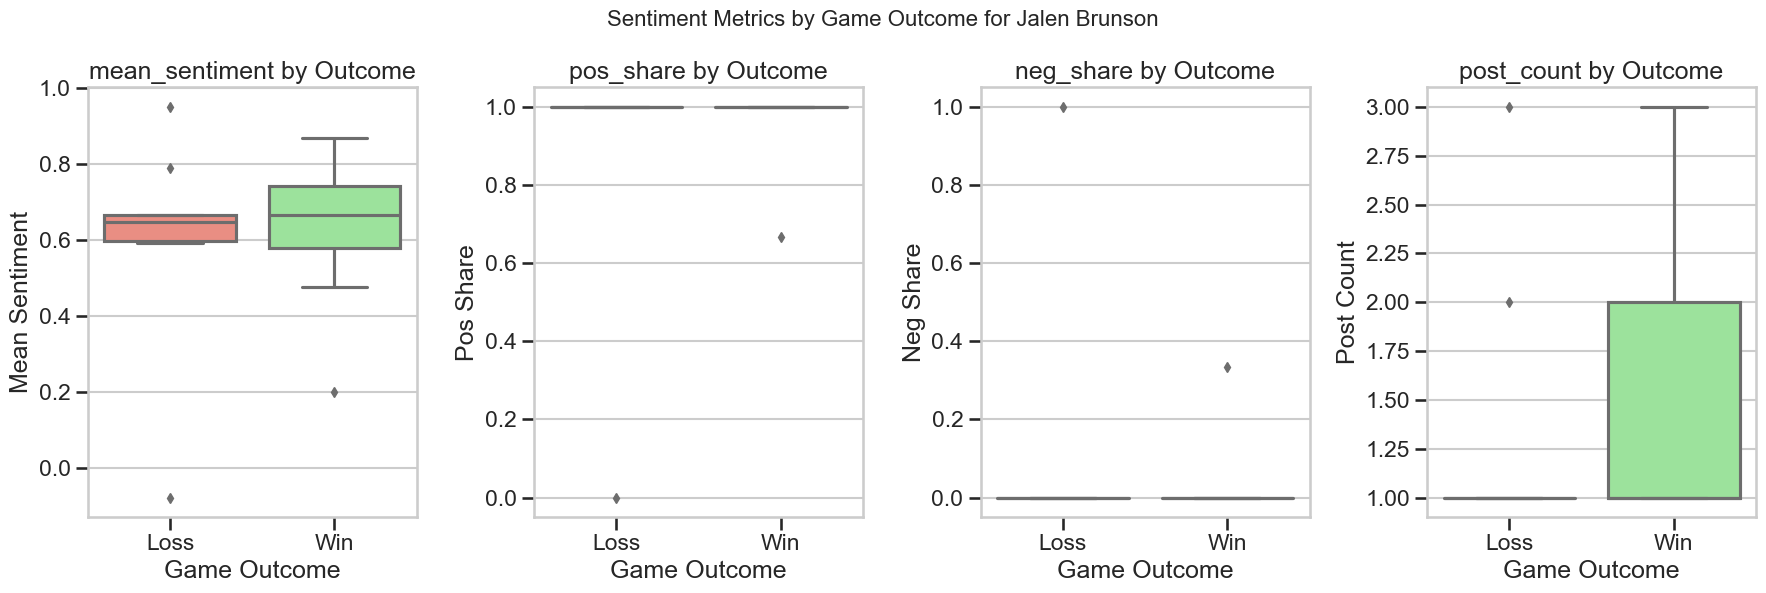


--- Finished processing Jalen Brunson ---


==================== PROCESSING: Lebron James ====================

--- Loading data for Lebron James from lebron_james_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 196
Rows before filtering on post_count: 196
Rows after filtering for post_count > 0: 21
Filtered data to 21 games with sentiment (post_count > 0).

--- Univariate Distributions for Lebron James ---


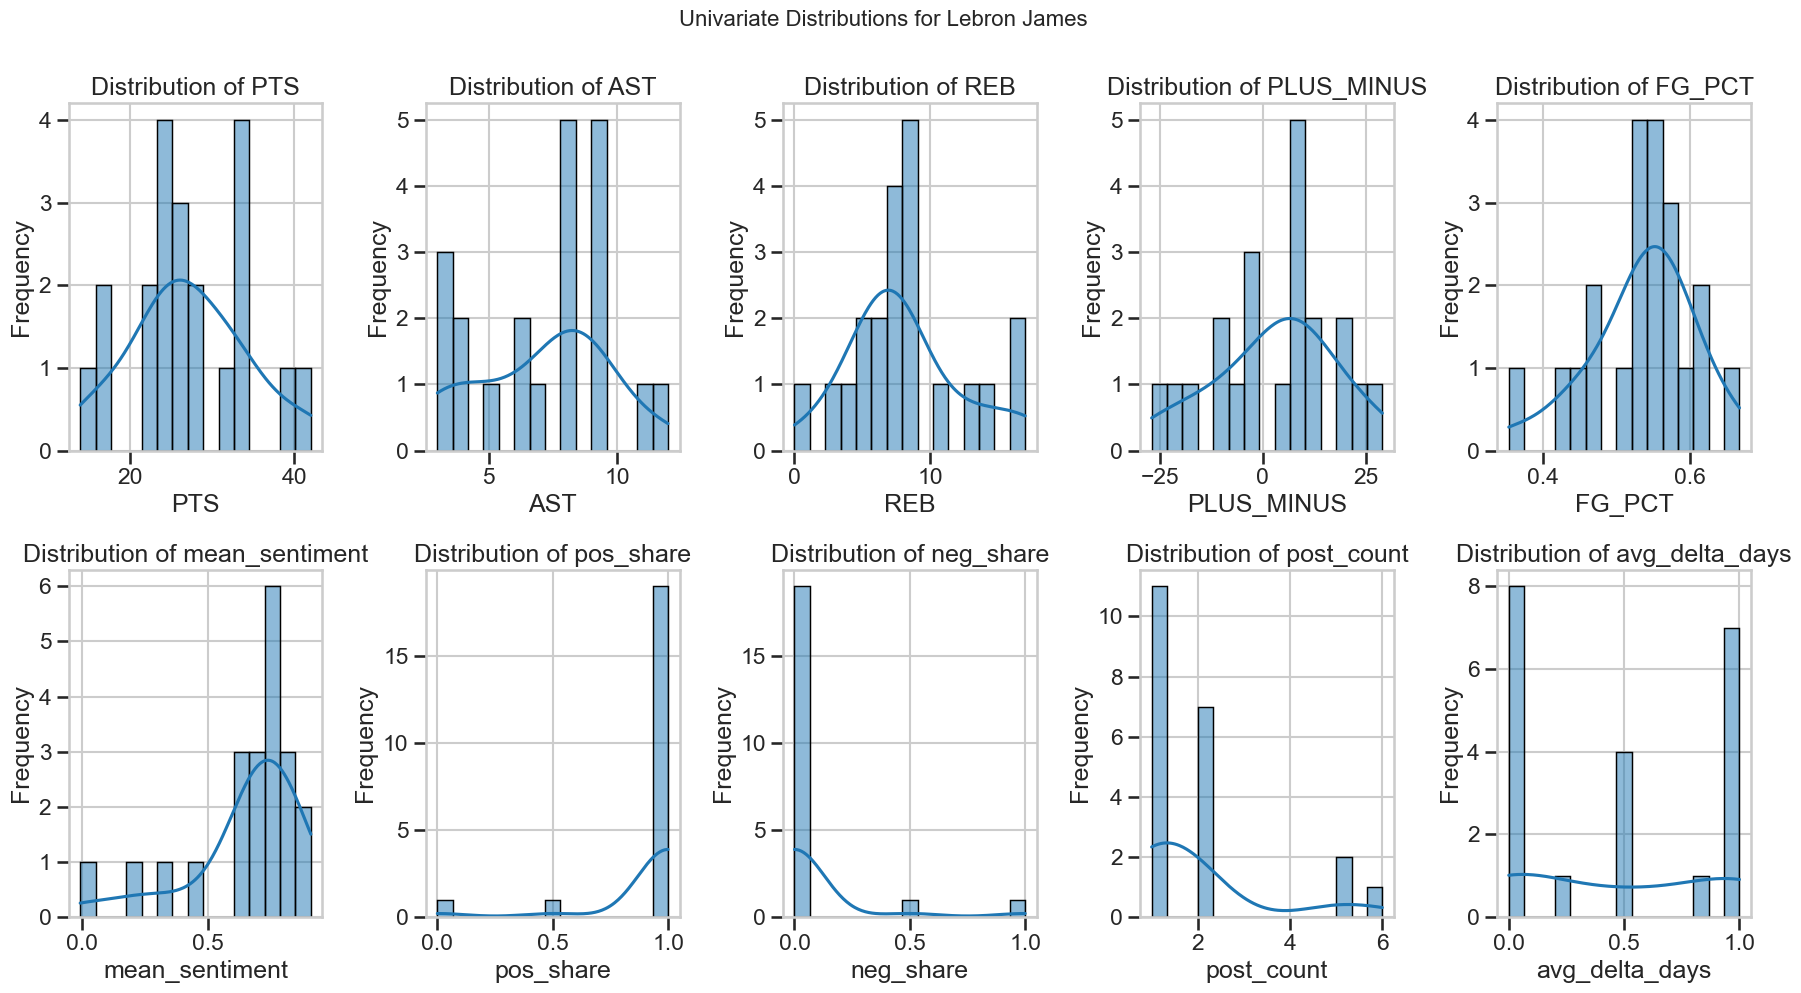


--- Correlation Analysis for Lebron James ---


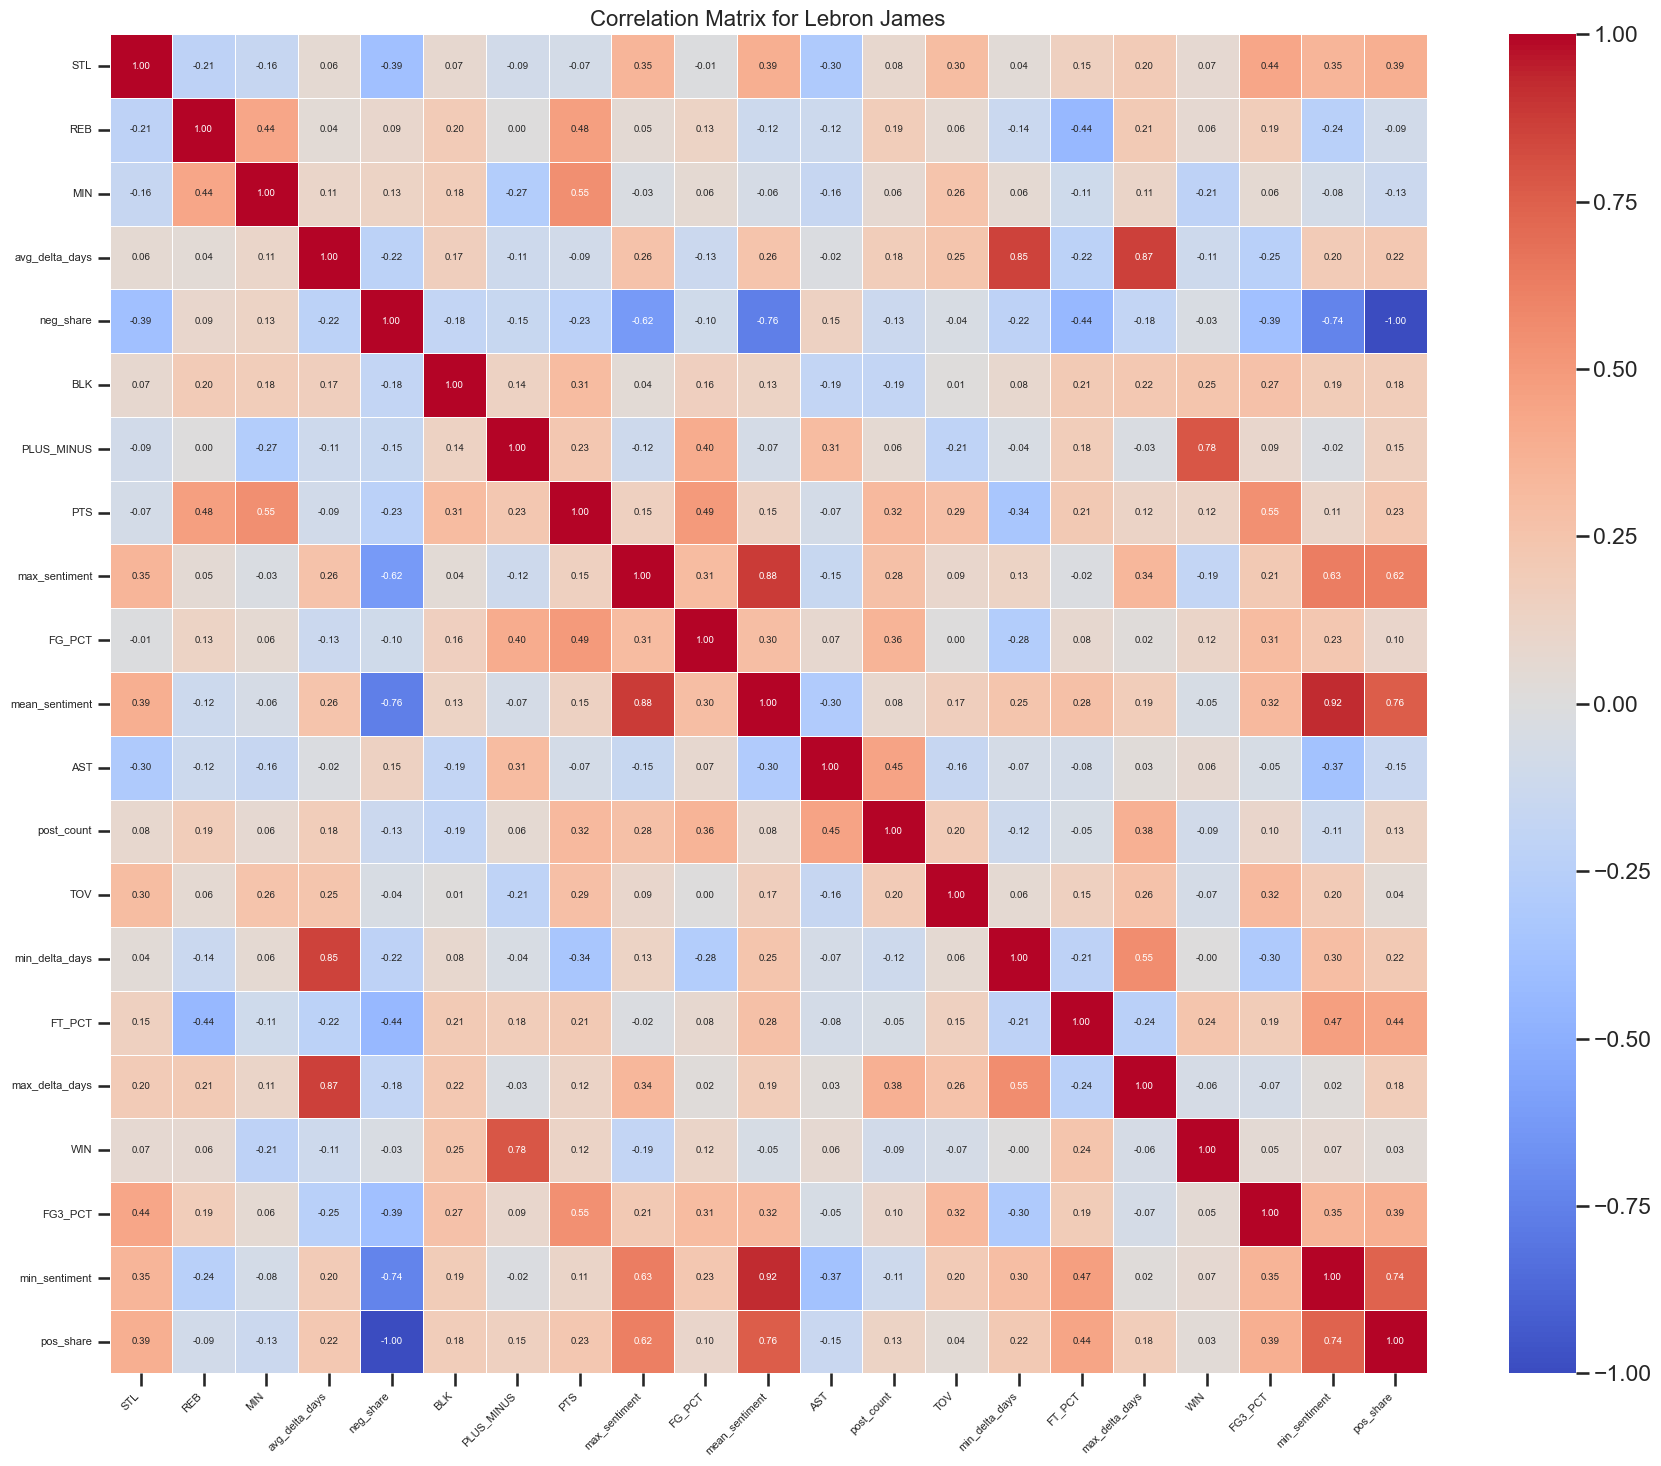


--- Unsupervised Clustering for Lebron James ---
   • PCA two‑component variance: 0.535


C:\Users\realo\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


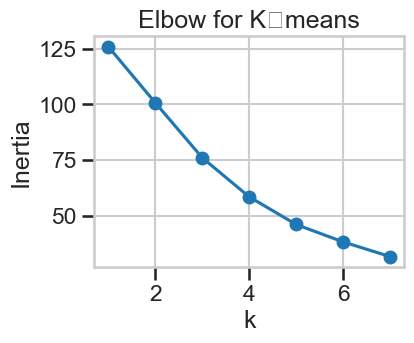

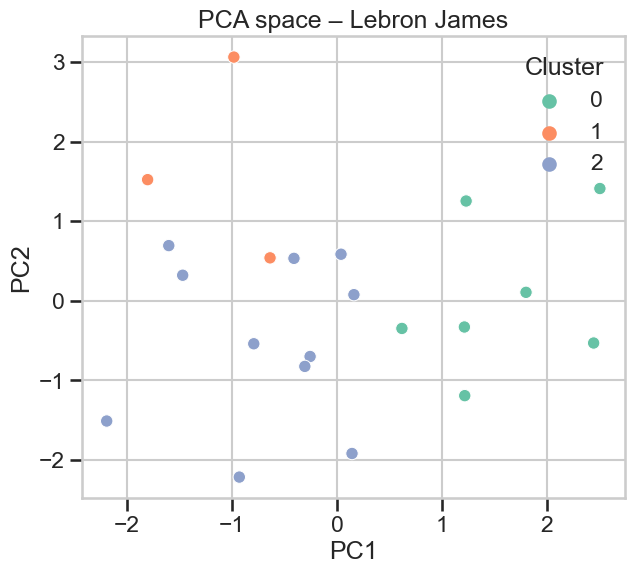

Cluster medians:


PTS  AST  REB  PLUS_MINUS  mean_sentiment  sent_intensity  WIN
cluster                                                                 
0        33.0  8.0  8.0         8.0            0.69            1.48  1.0
1        22.0  9.0  7.0        -1.0            0.20            0.20  1.0
2        25.0  7.0  6.0        -1.0            0.78            0.80  1.0


--- Bivariate Scatter Plots for Lebron James ---


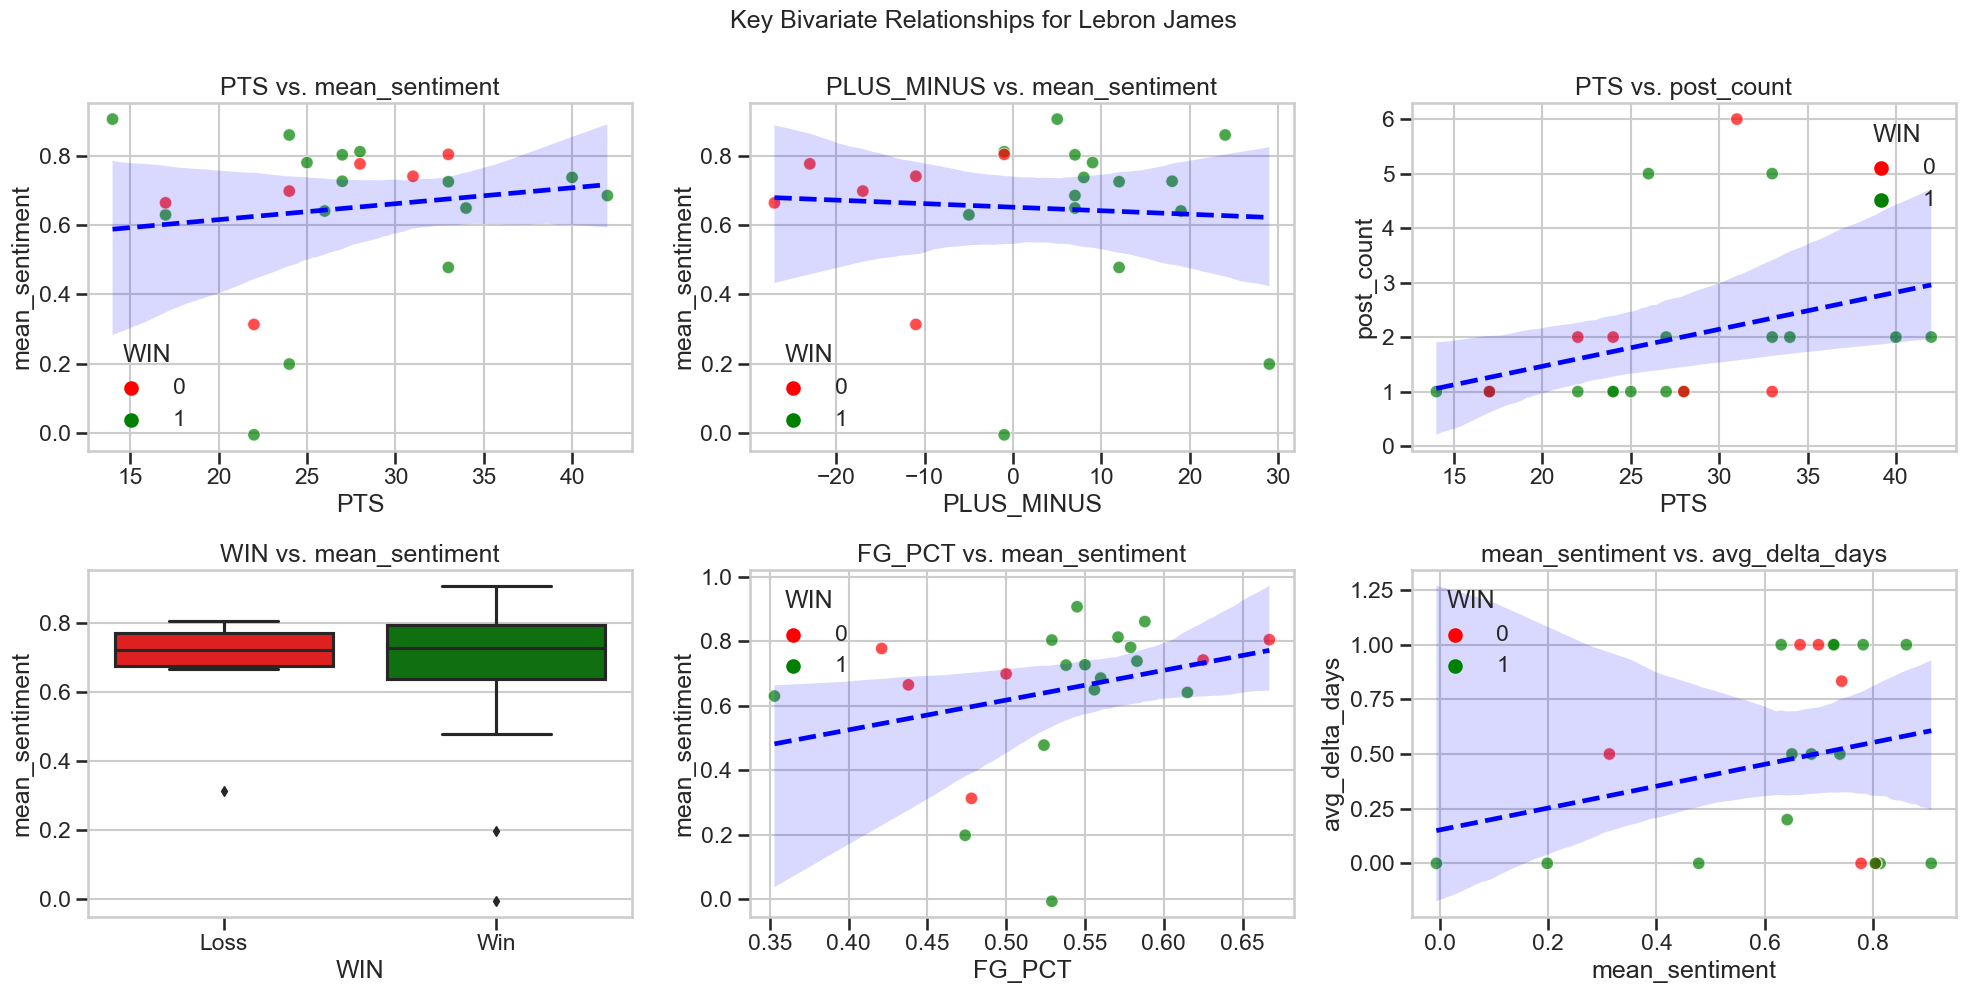


--- Sentiment Analysis by Game Outcome for Lebron James ---


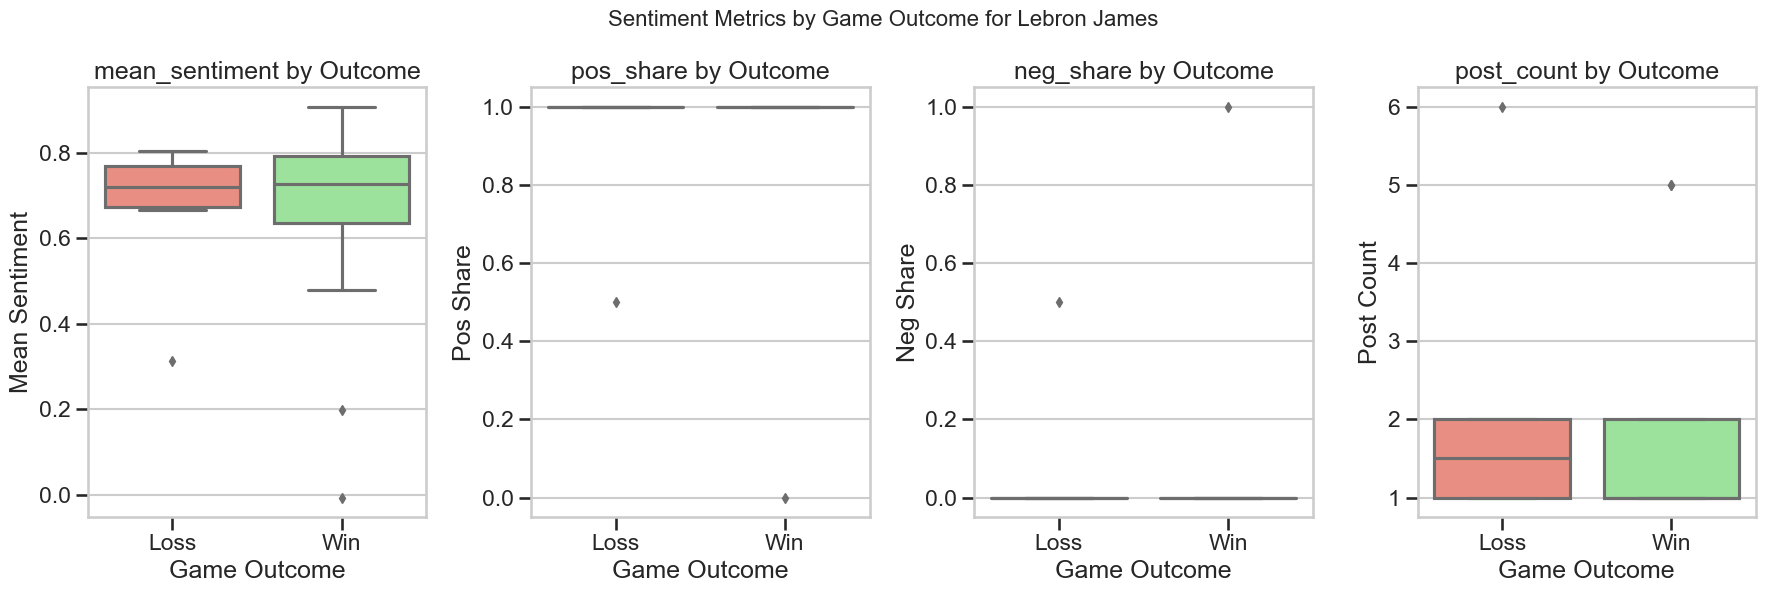


--- Finished processing Lebron James ---


==================== PROCESSING: Luka Doncic ====================

--- Loading data for Luka Doncic from luka_doncic_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 186
Rows before filtering on post_count: 186
Rows after filtering for post_count > 0: 15
Filtered data to 15 games with sentiment (post_count > 0).

--- Univariate Distributions for Luka Doncic ---


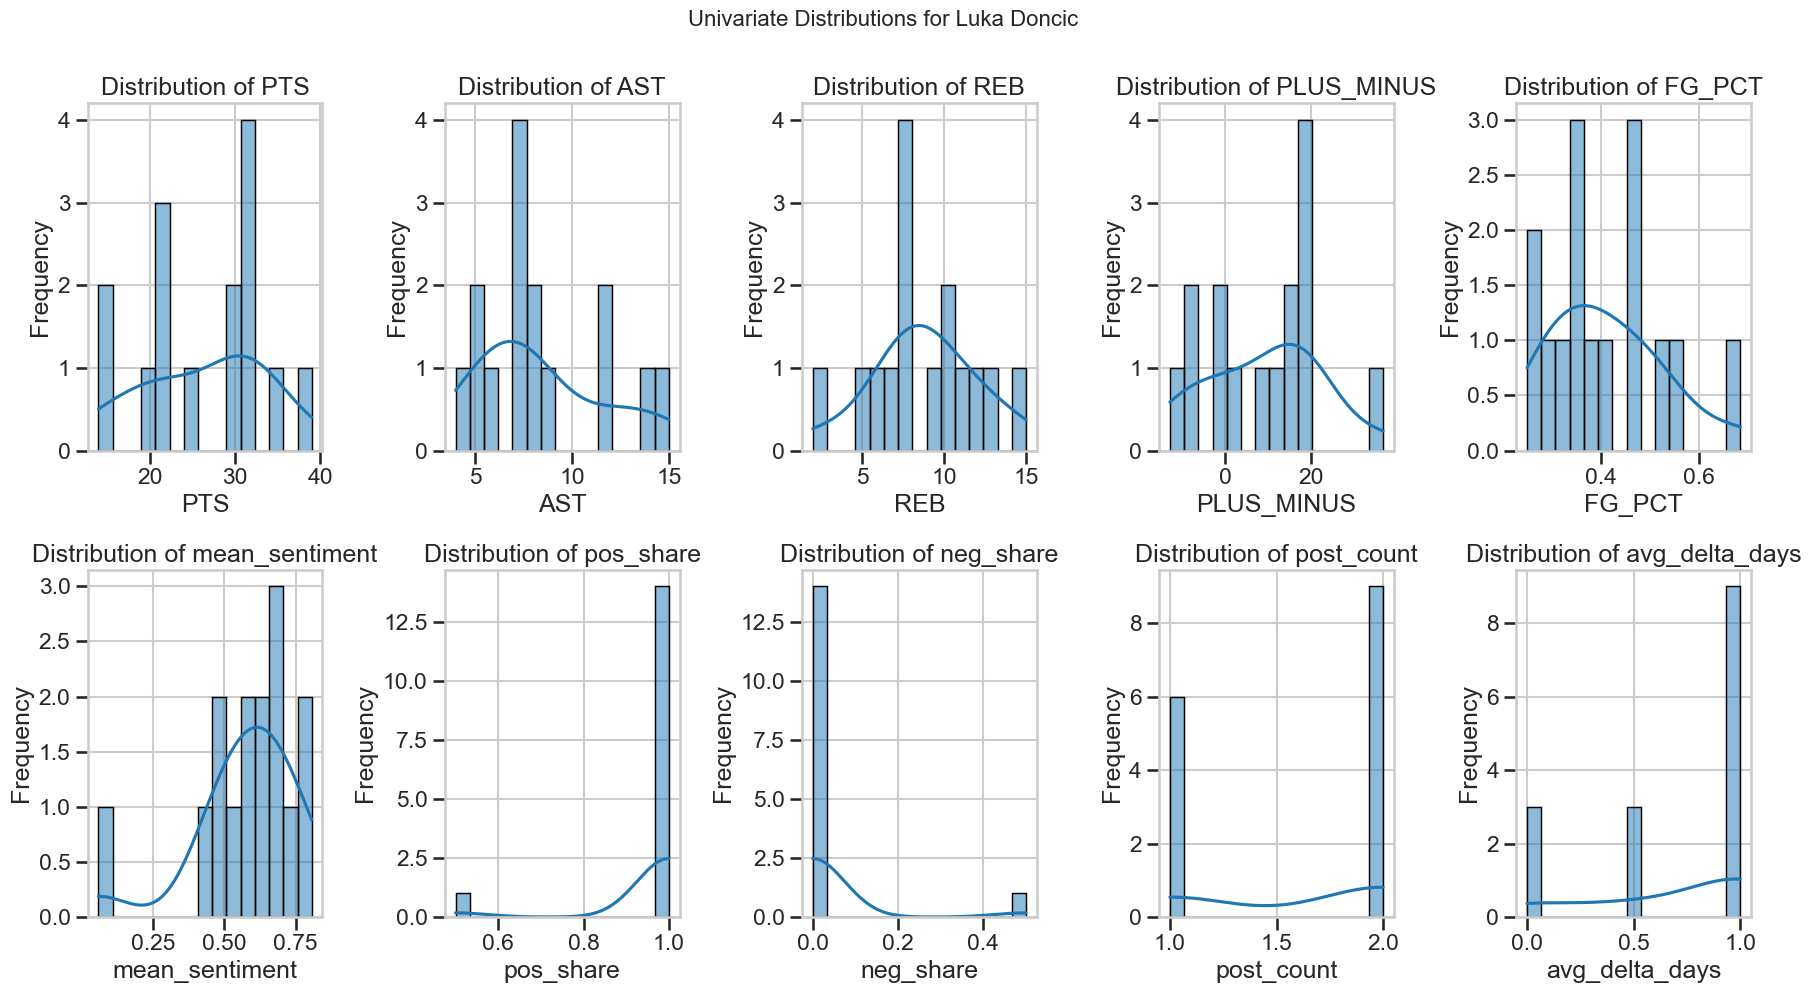


--- Correlation Analysis for Luka Doncic ---


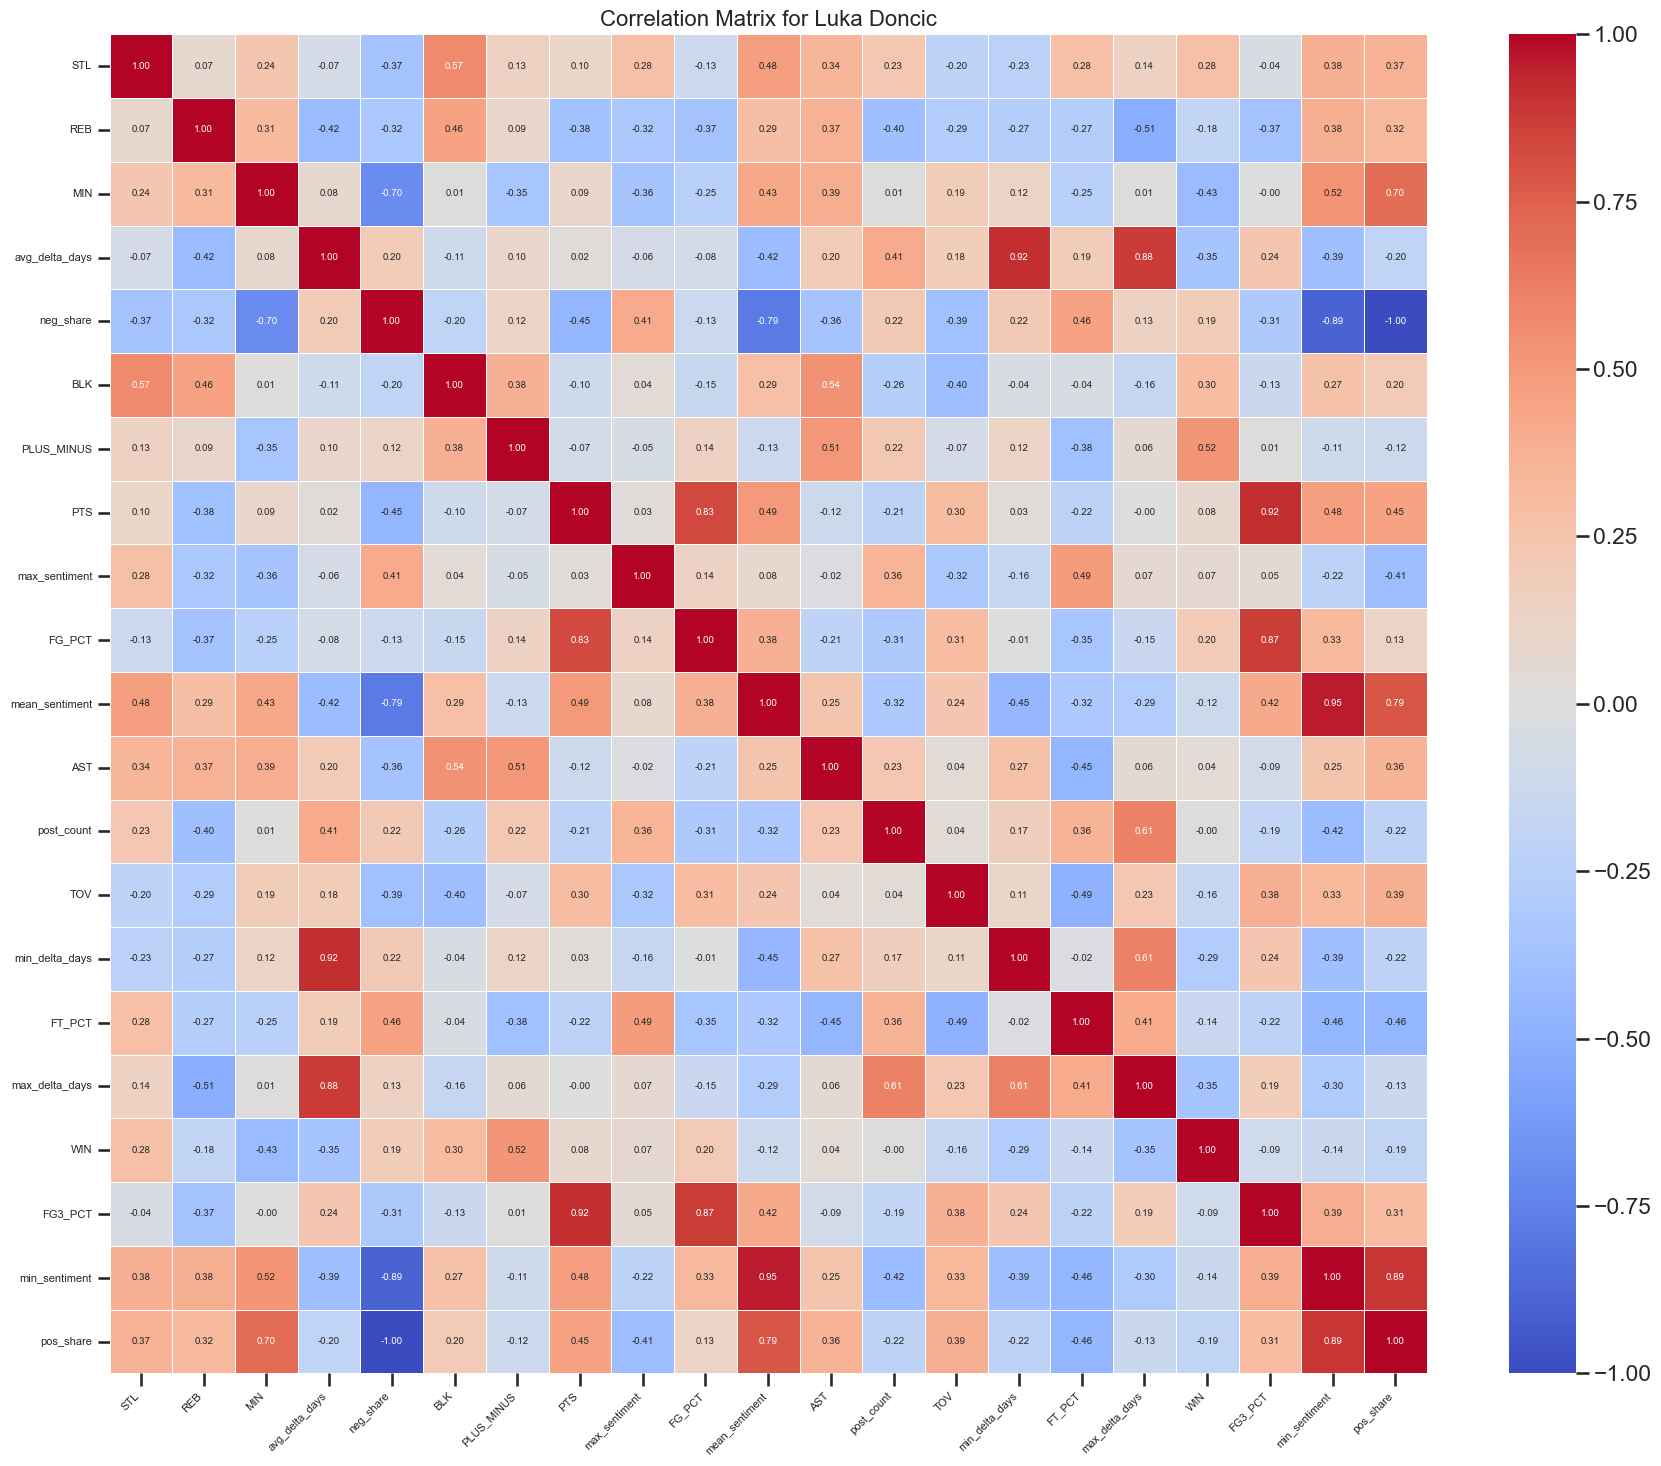


--- Unsupervised Clustering for Luka Doncic ---
   • PCA two‑component variance: 0.635


C:\Users\realo\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


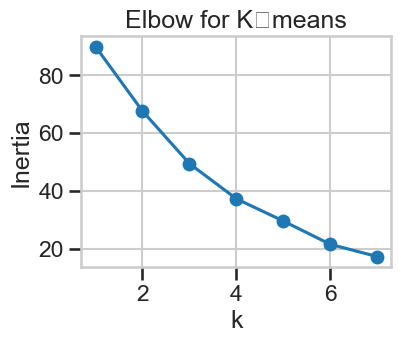

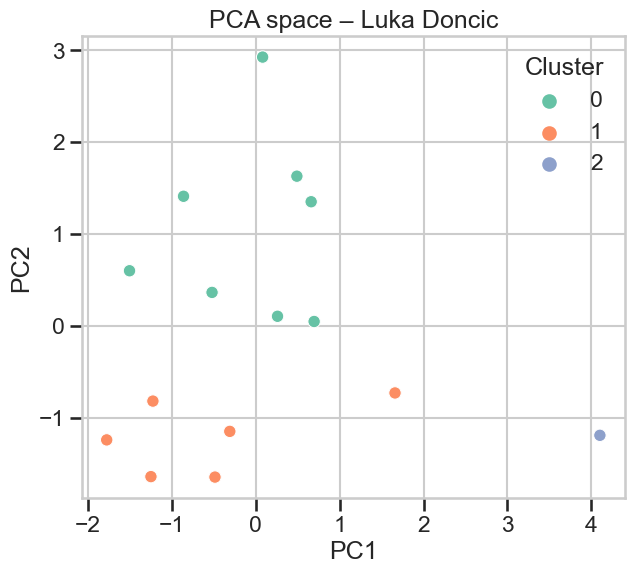

Cluster medians:


PTS   AST   REB  PLUS_MINUS  mean_sentiment  sent_intensity  WIN
cluster                                                                   
0        31.5   7.0   8.0         7.0            0.66            0.88  1.0
1        21.0  12.0  11.5        10.5            0.59            1.03  1.0
2        14.0   4.0   5.0        15.0            0.06            0.12  1.0


--- Bivariate Scatter Plots for Luka Doncic ---


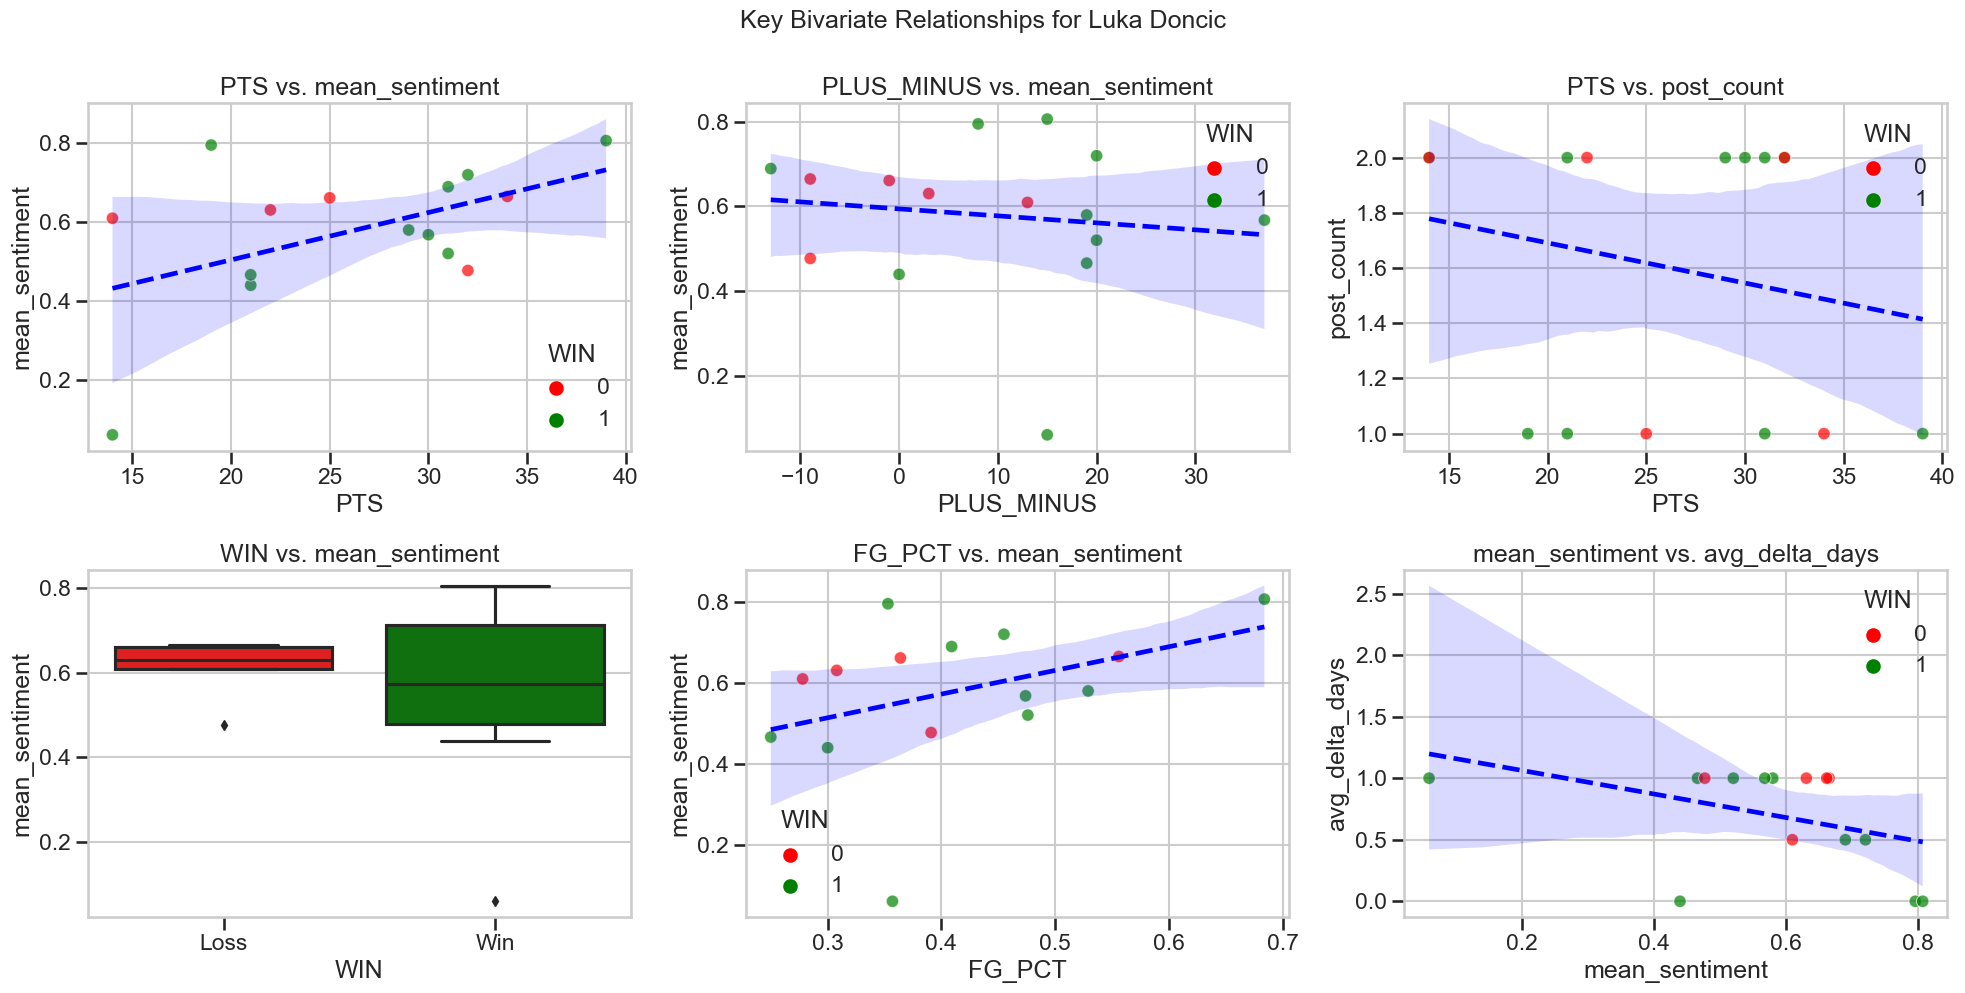


--- Sentiment Analysis by Game Outcome for Luka Doncic ---


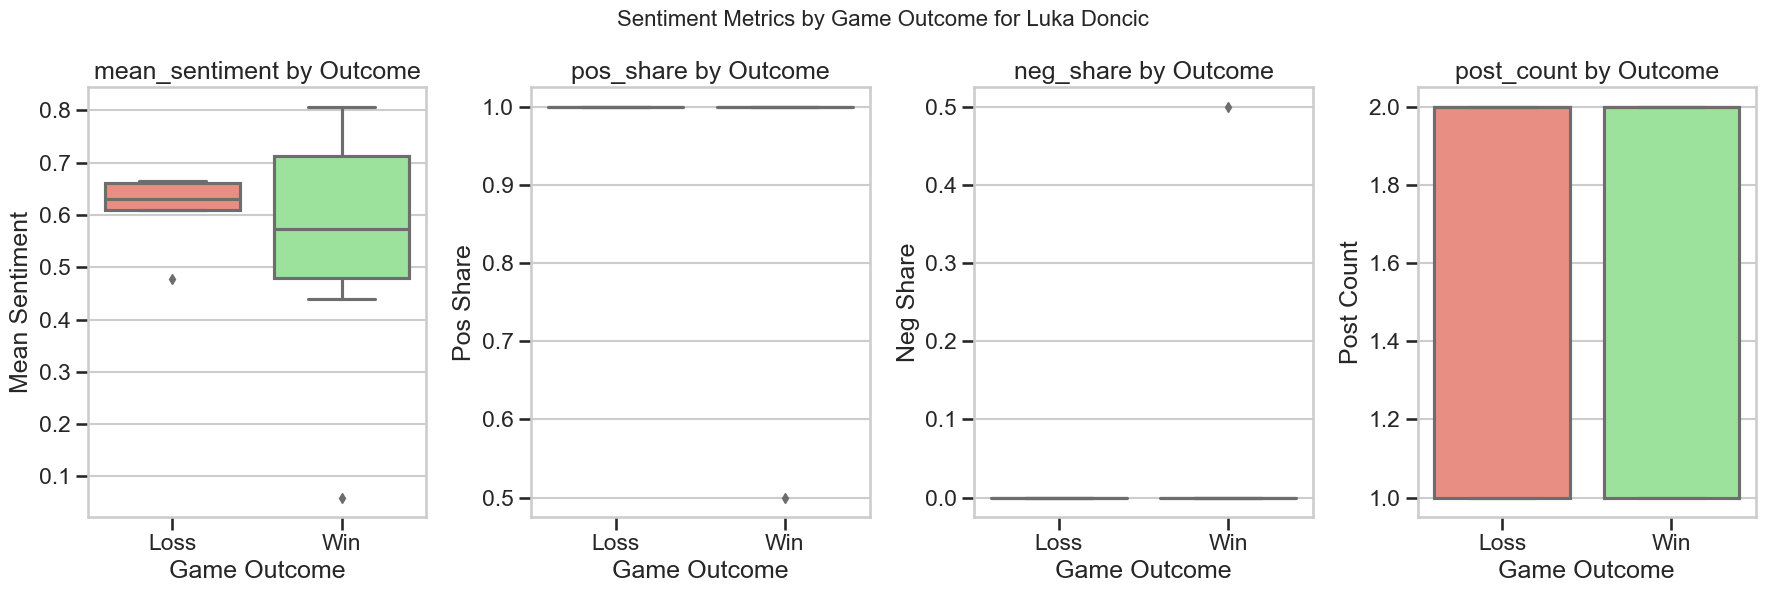


--- Finished processing Luka Doncic ---


==================== PROCESSING: Shai Gilgeous-Alexander ====================

--- Loading data for Shai Gilgeous-Alexander from shai_gilgeous-alexander_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 219
Rows before filtering on post_count: 219
Rows after filtering for post_count > 0: 31
Filtered data to 31 games with sentiment (post_count > 0).

--- Univariate Distributions for Shai Gilgeous-Alexander ---


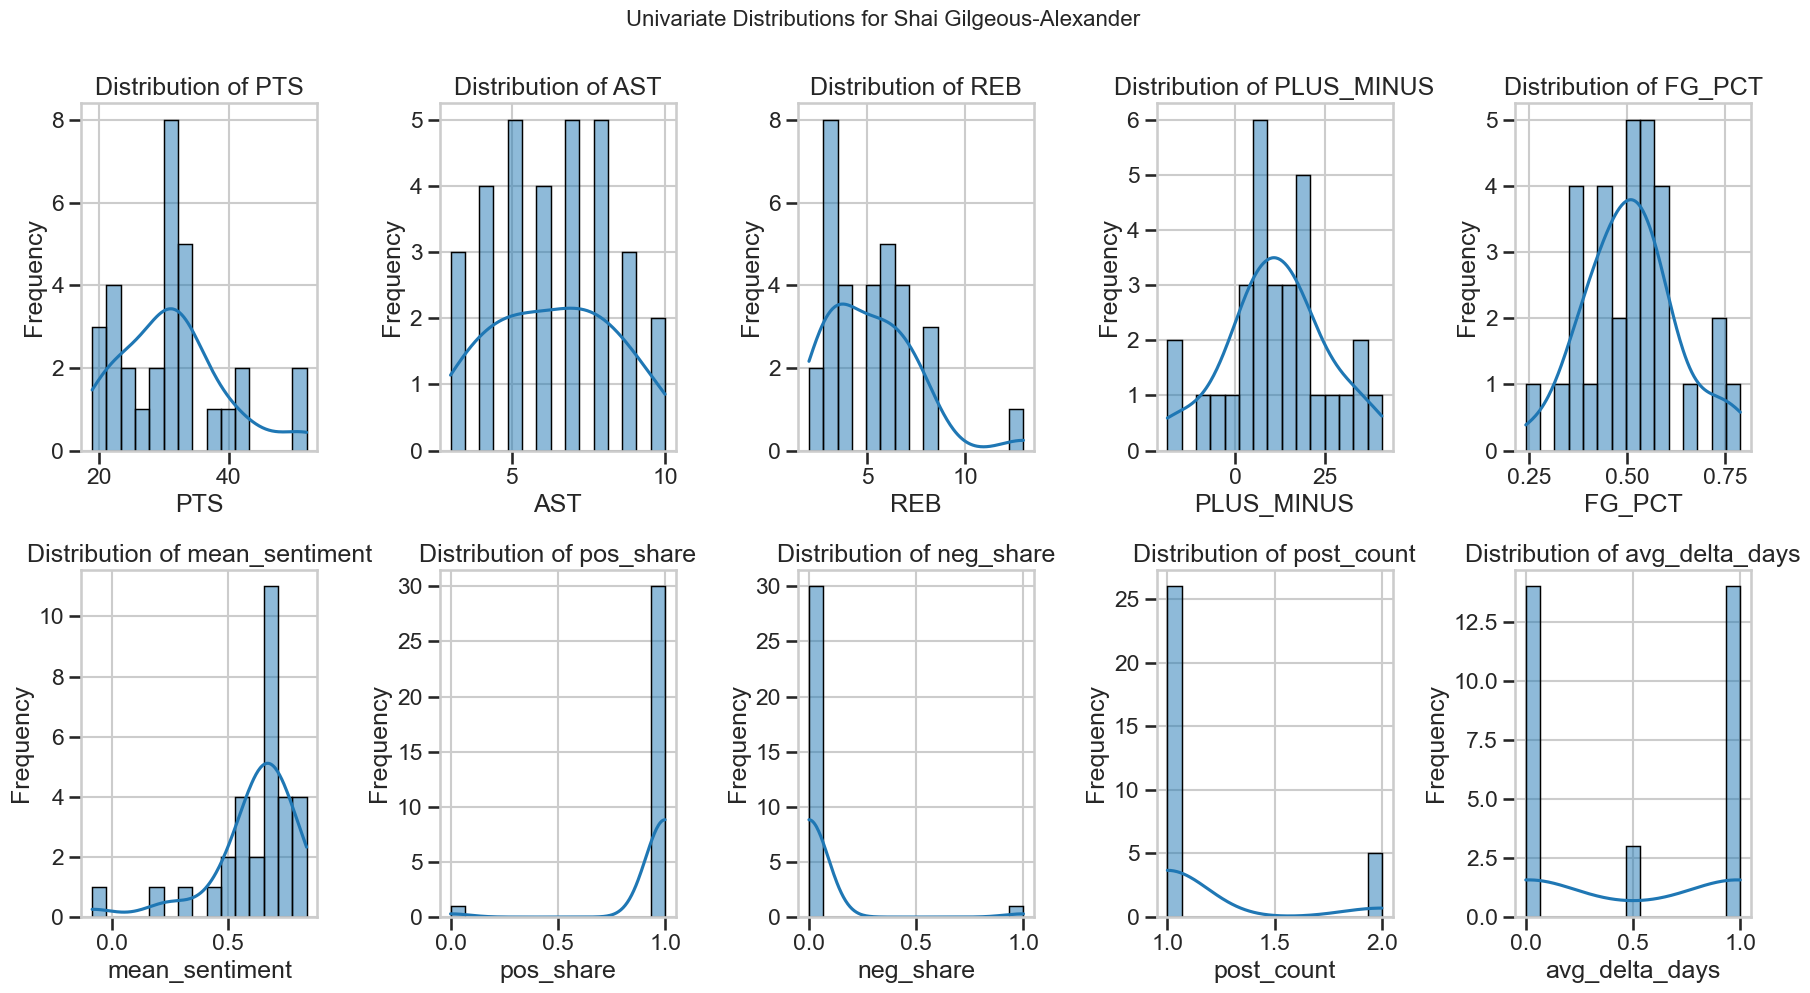


--- Correlation Analysis for Shai Gilgeous-Alexander ---


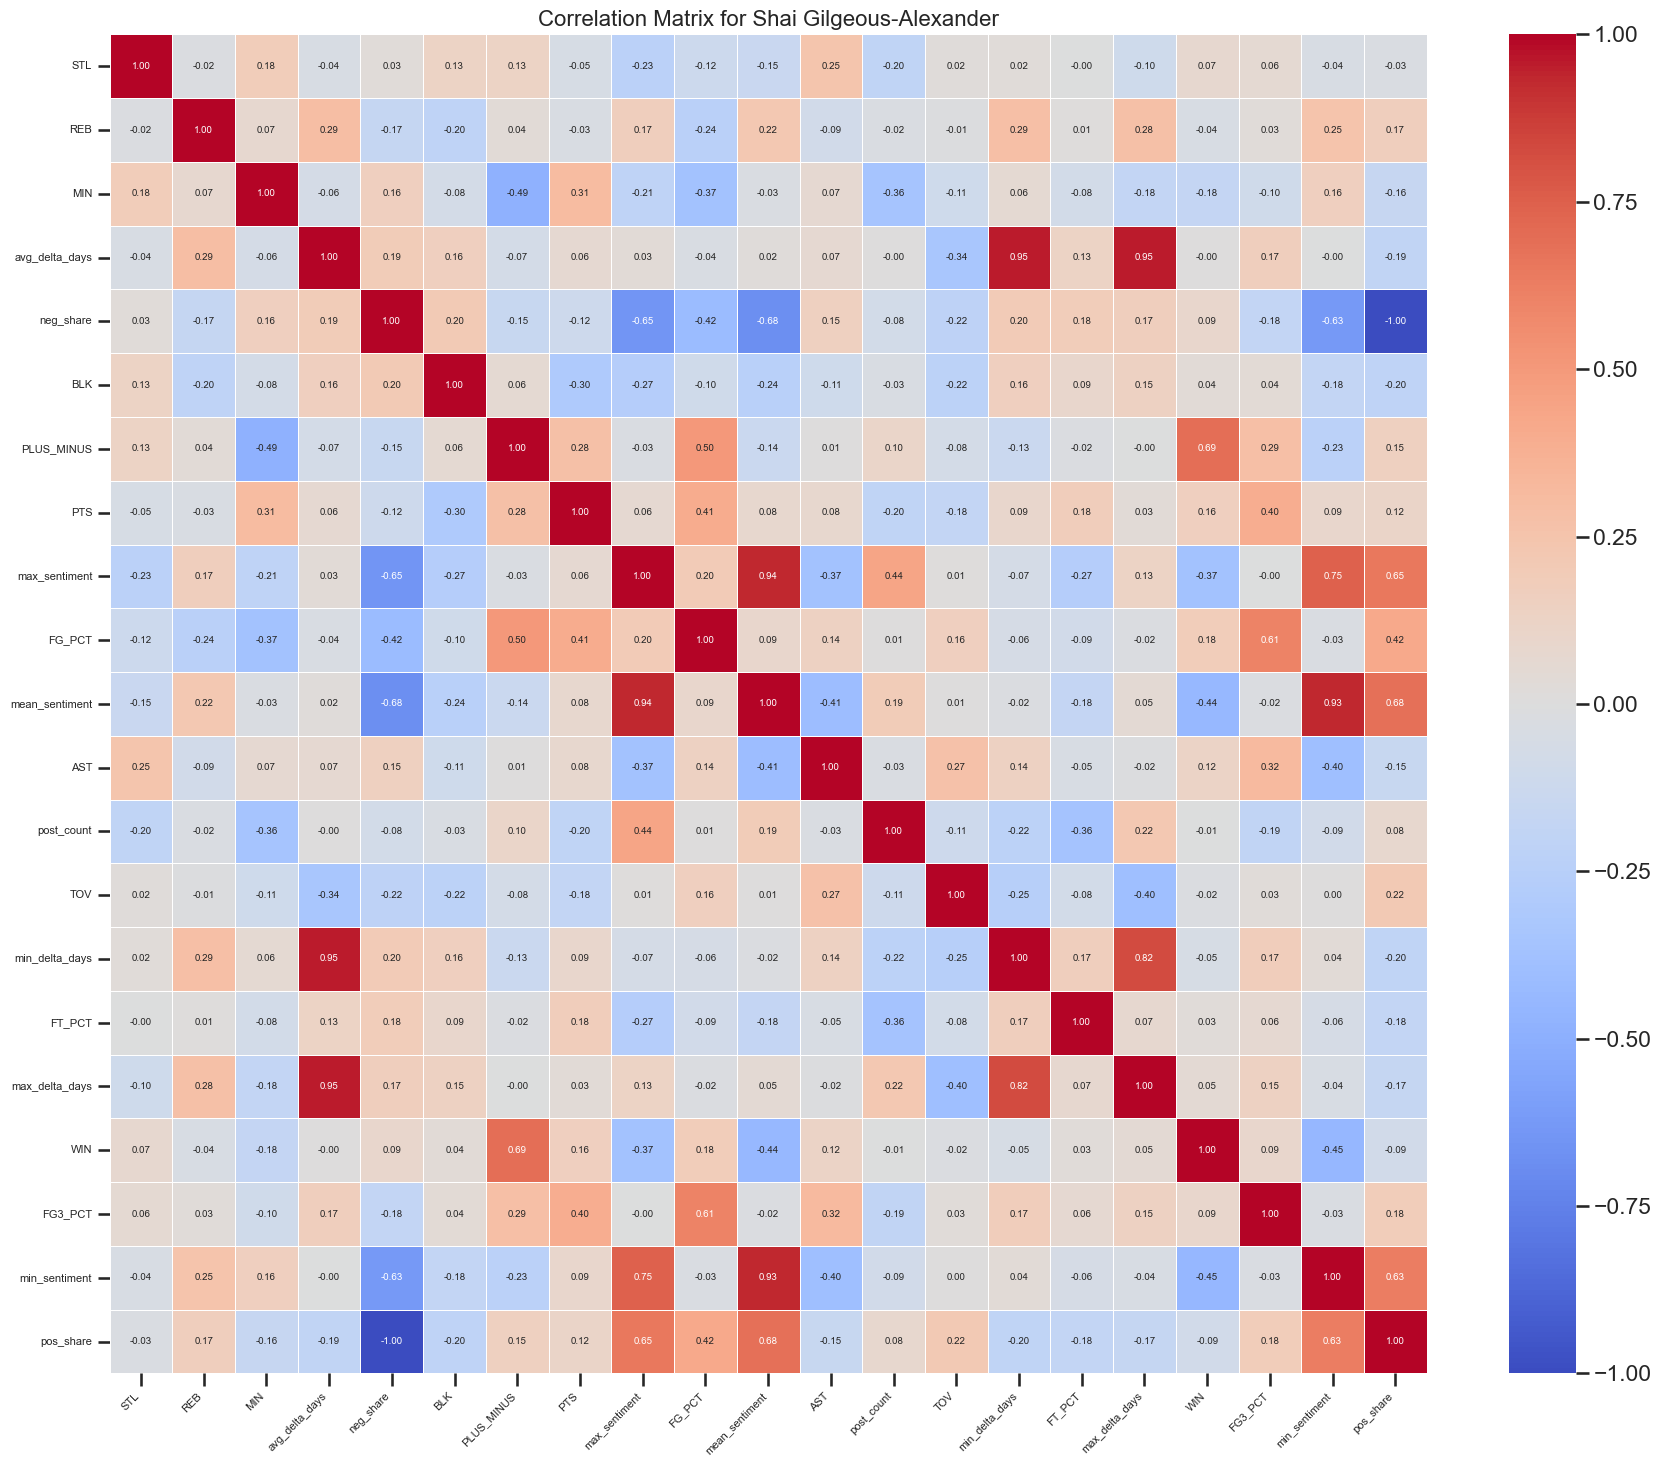


--- Unsupervised Clustering for Shai Gilgeous-Alexander ---
   • PCA two‑component variance: 0.545


C:\Users\realo\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


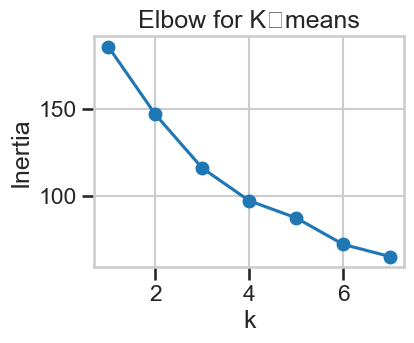

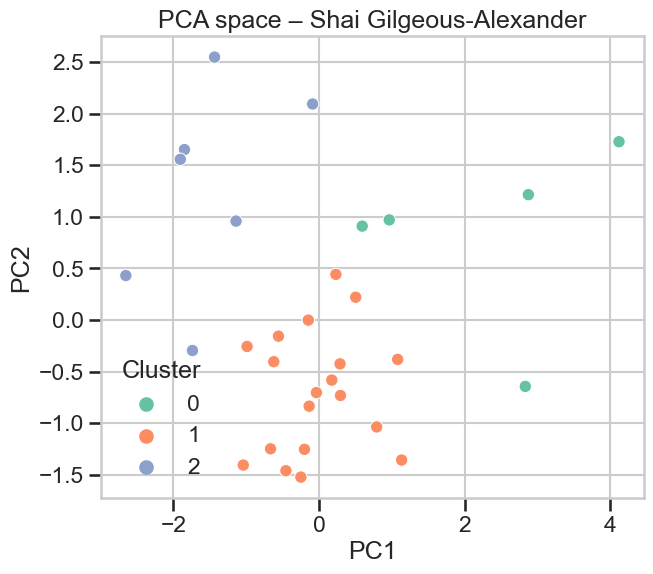

Cluster medians:


PTS  AST  REB  PLUS_MINUS  mean_sentiment  sent_intensity  WIN
cluster                                                                 
0        25.0  8.0  3.0         8.0            0.29            0.29  1.0
1        33.0  6.0  5.0        16.0            0.66            0.67  1.0
2        22.0  4.0  5.0        -6.0            0.74            0.82  0.0


--- Bivariate Scatter Plots for Shai Gilgeous-Alexander ---


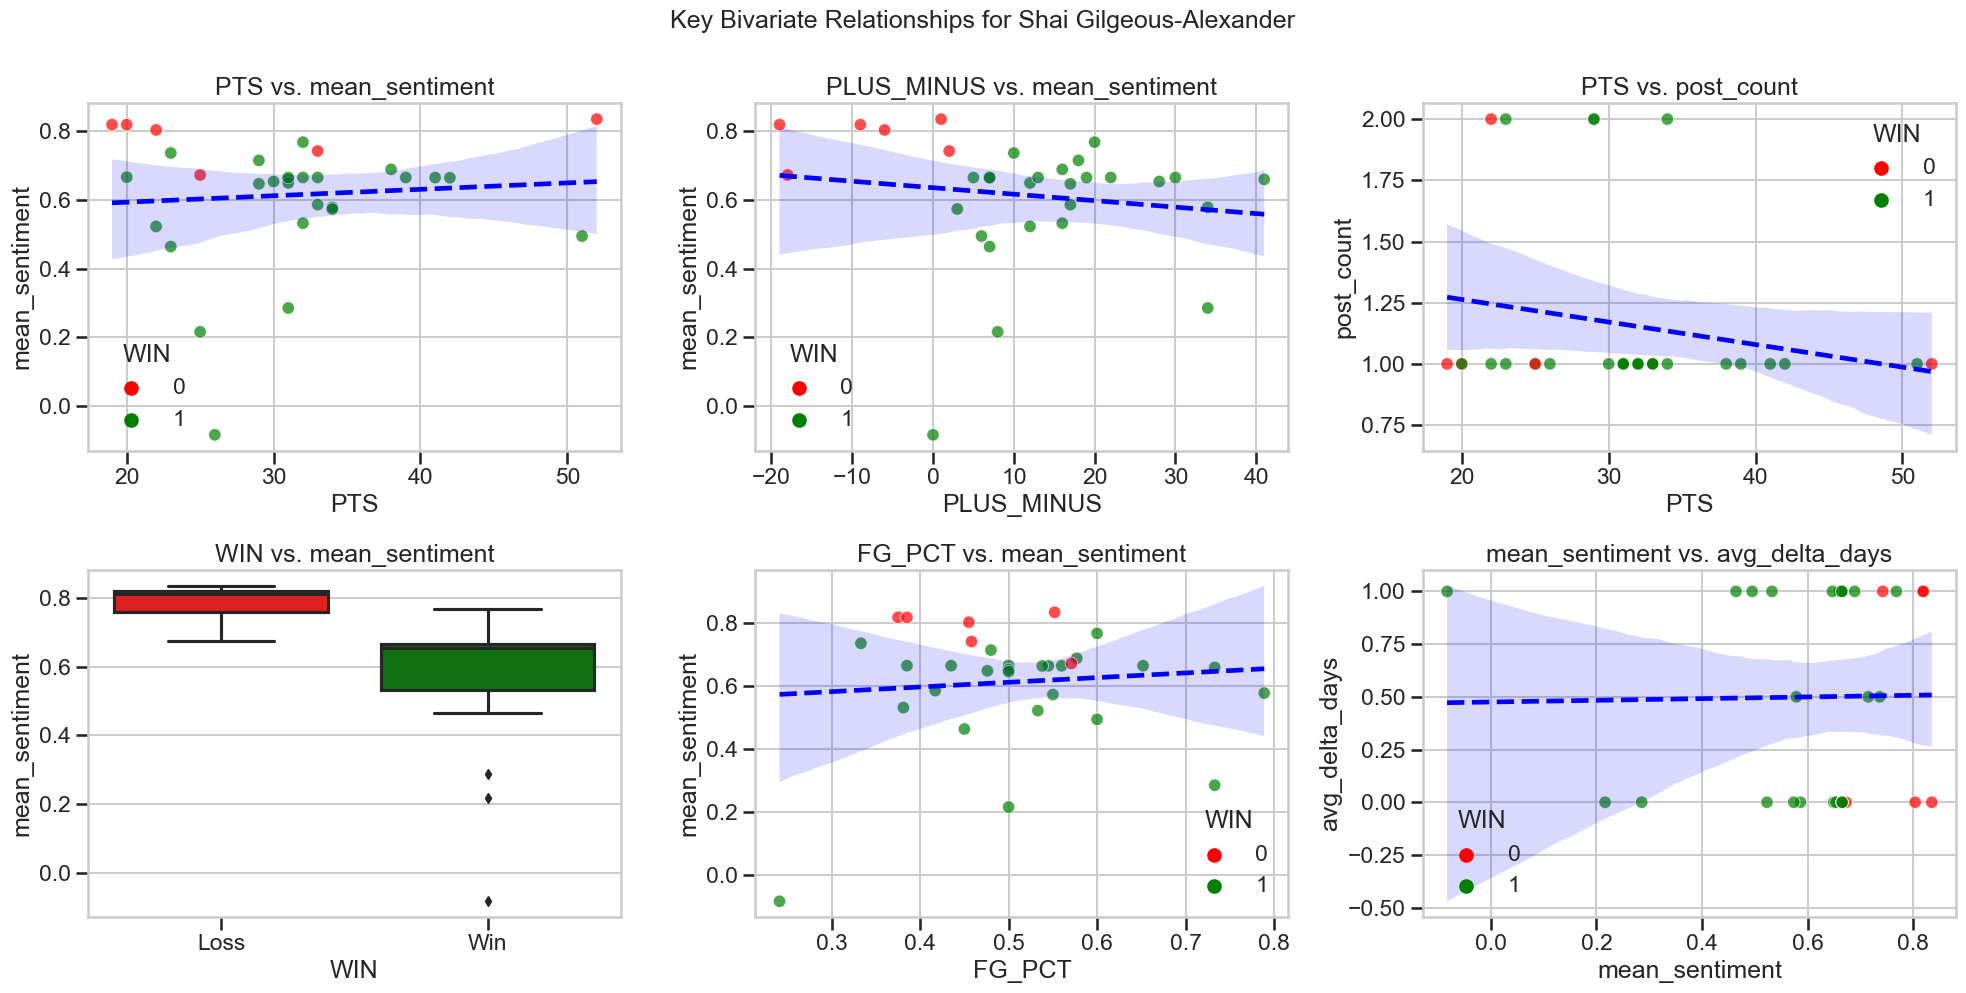


--- Sentiment Analysis by Game Outcome for Shai Gilgeous-Alexander ---


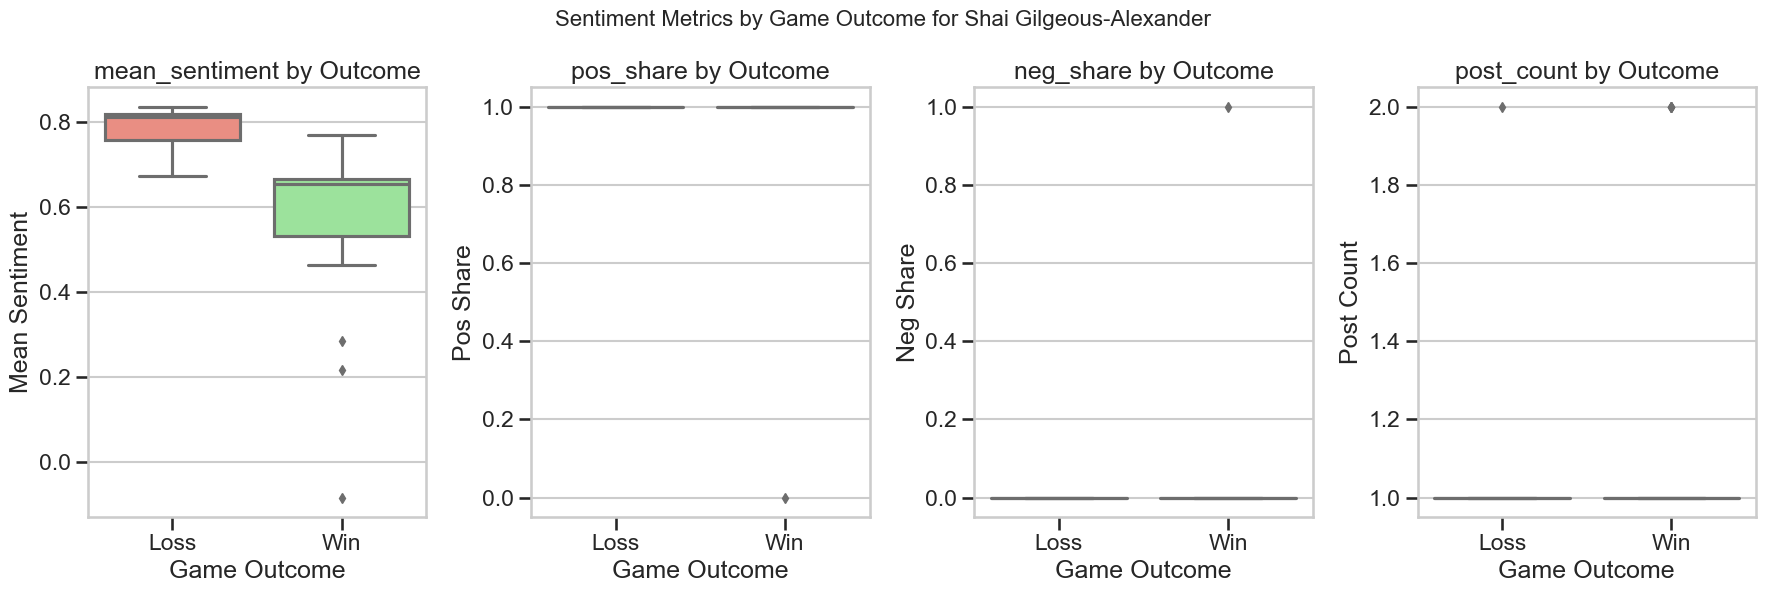


--- Finished processing Shai Gilgeous-Alexander ---


==================== PROCESSING: Stephen Curry ====================

--- Loading data for Stephen Curry from stephen_curry_stats_sentiment_2022_2024.csv ---
Initial rows loaded: 200
Rows before filtering on post_count: 200
Rows after filtering for post_count > 0: 27
Filtered data to 27 games with sentiment (post_count > 0).

--- Univariate Distributions for Stephen Curry ---


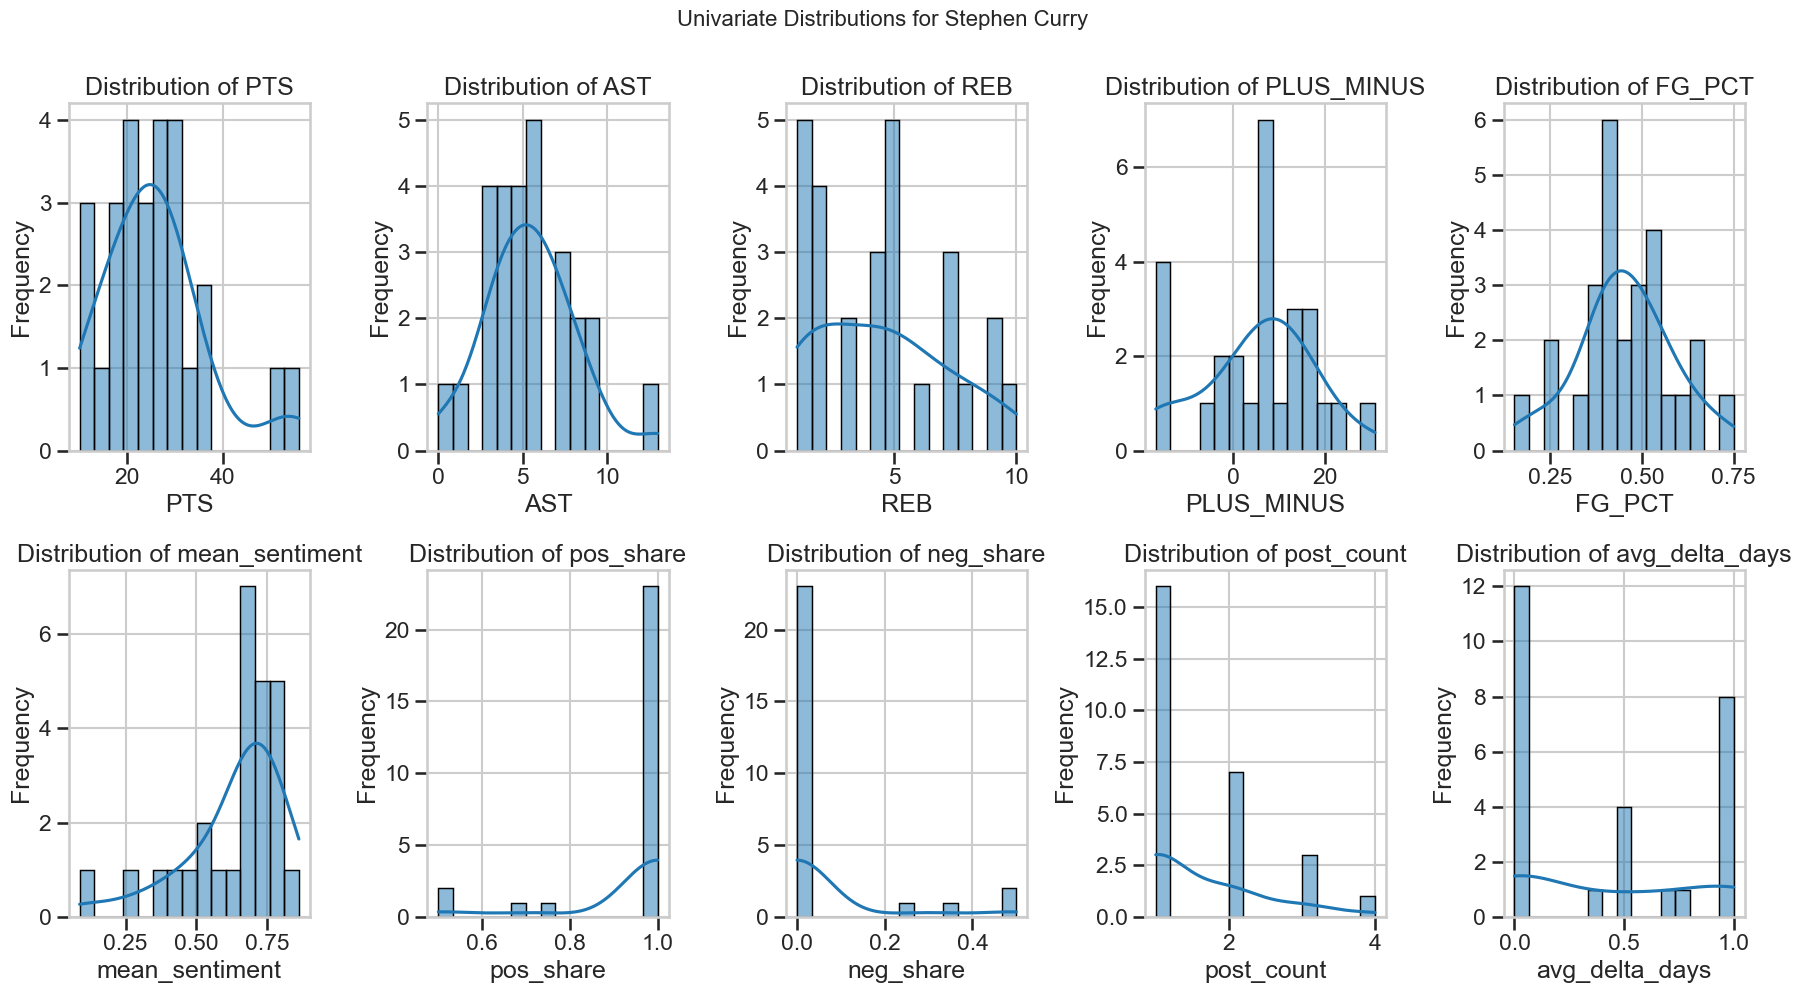


--- Correlation Analysis for Stephen Curry ---


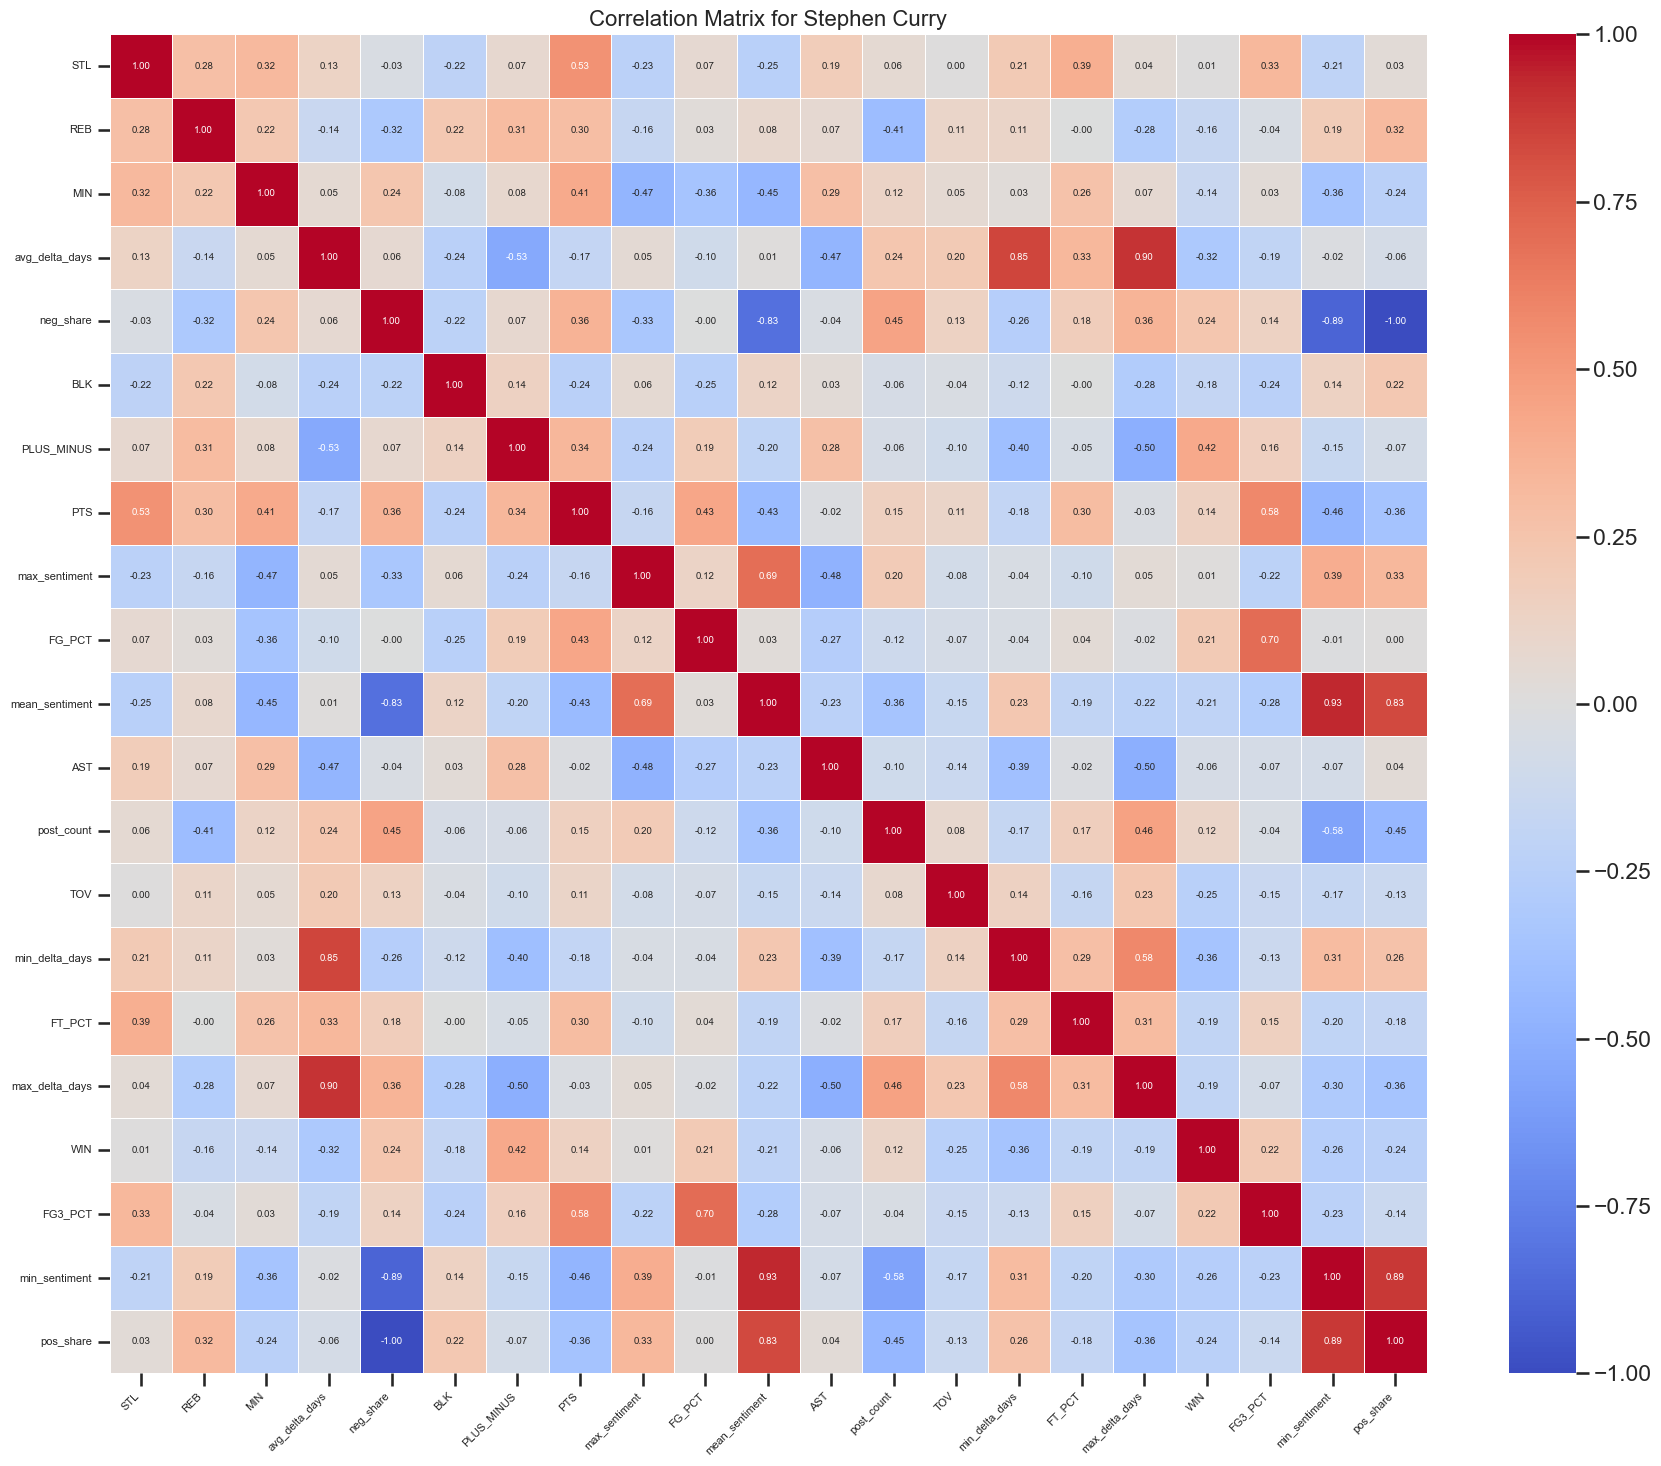


--- Unsupervised Clustering for Stephen Curry ---
   • PCA two‑component variance: 0.545


C:\Users\realo\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


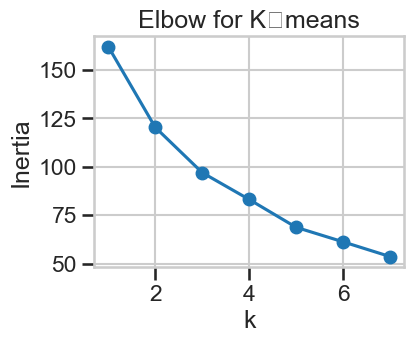

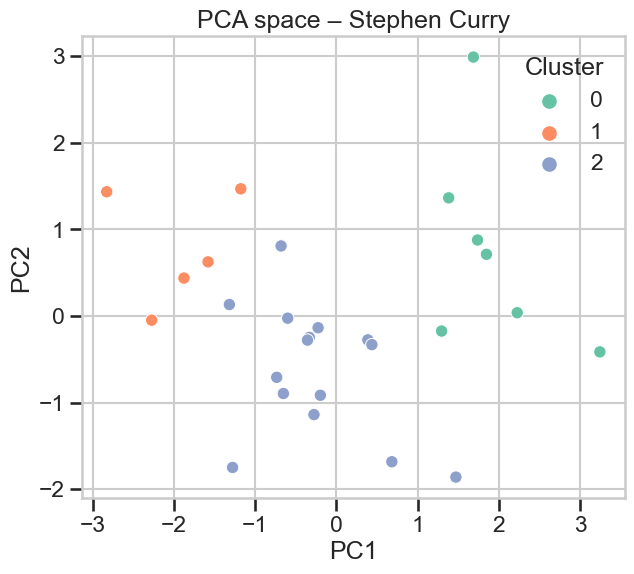

Cluster medians:


PTS  AST  REB  PLUS_MINUS  mean_sentiment  sent_intensity  WIN
cluster                                                                 
0        31.0  8.0  5.0        15.0            0.41            0.52  1.0
1        17.0  5.0  1.0        -2.0            0.71            1.96  1.0
2        25.0  5.0  5.0         6.0            0.73            0.78  1.0


--- Bivariate Scatter Plots for Stephen Curry ---


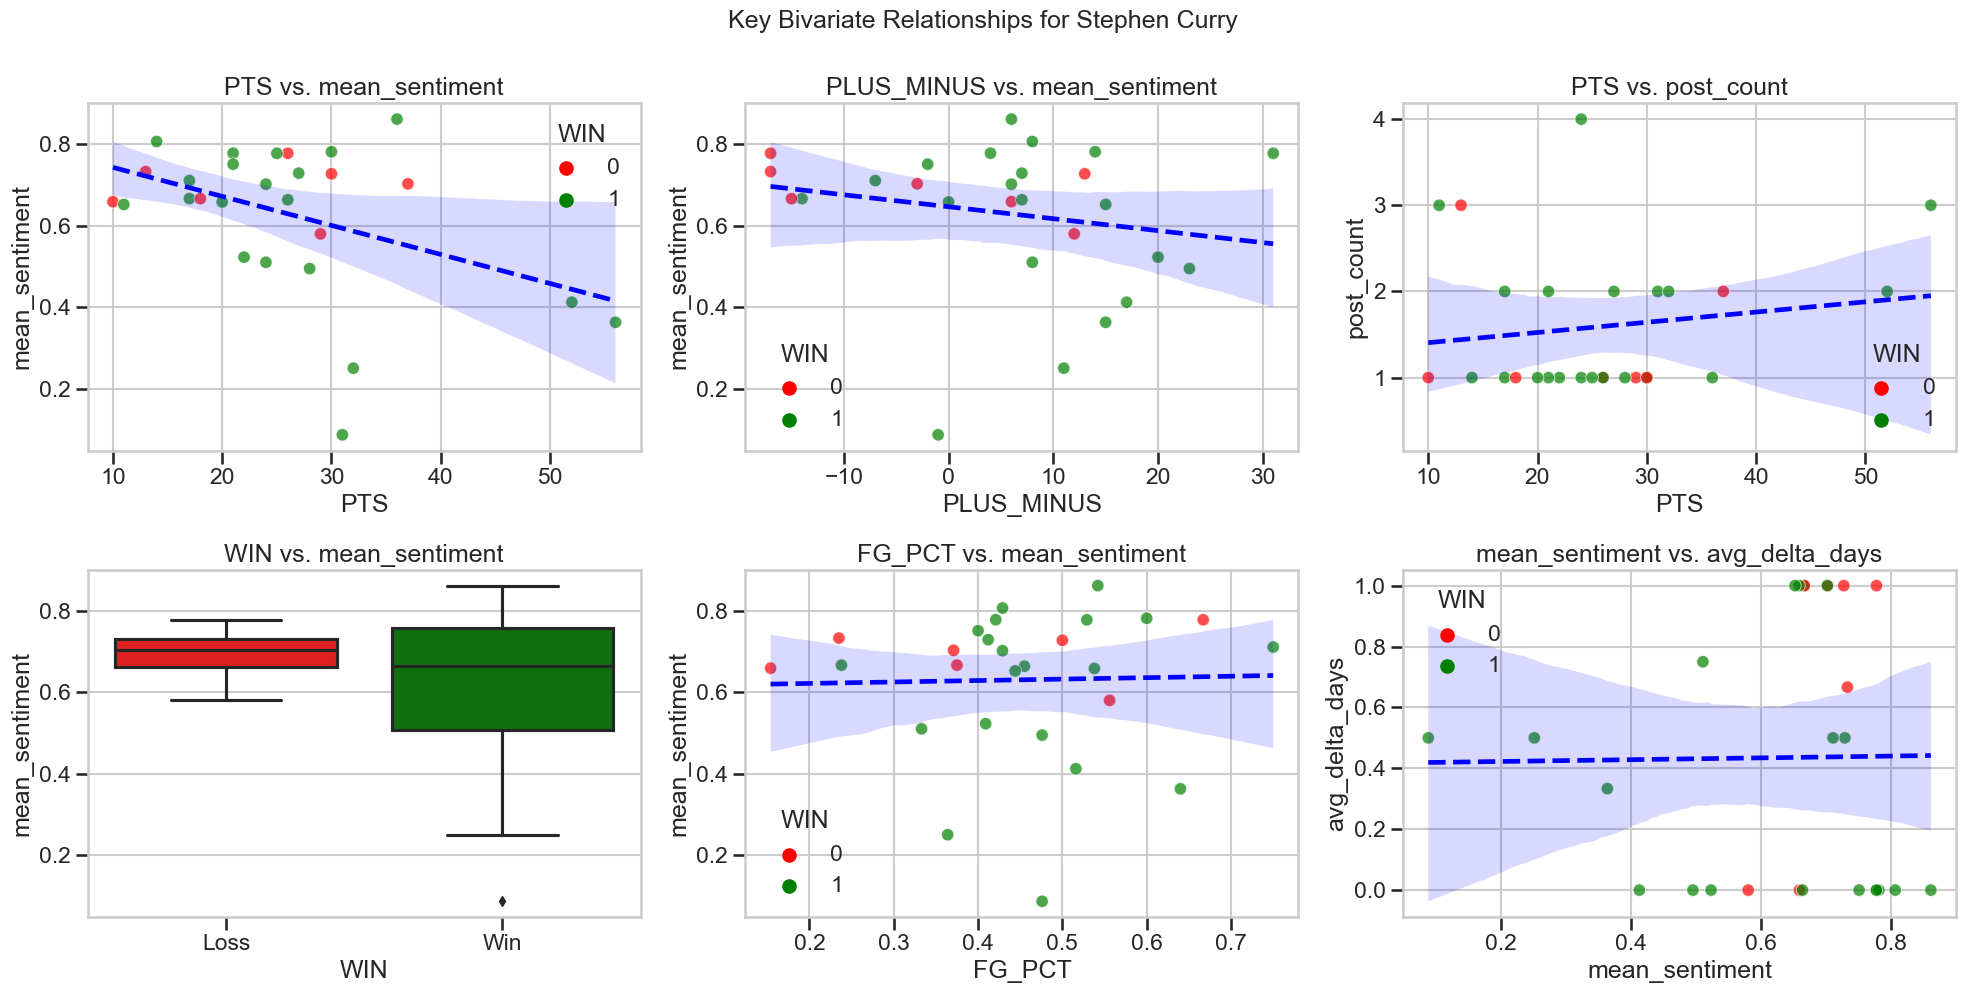


--- Sentiment Analysis by Game Outcome for Stephen Curry ---


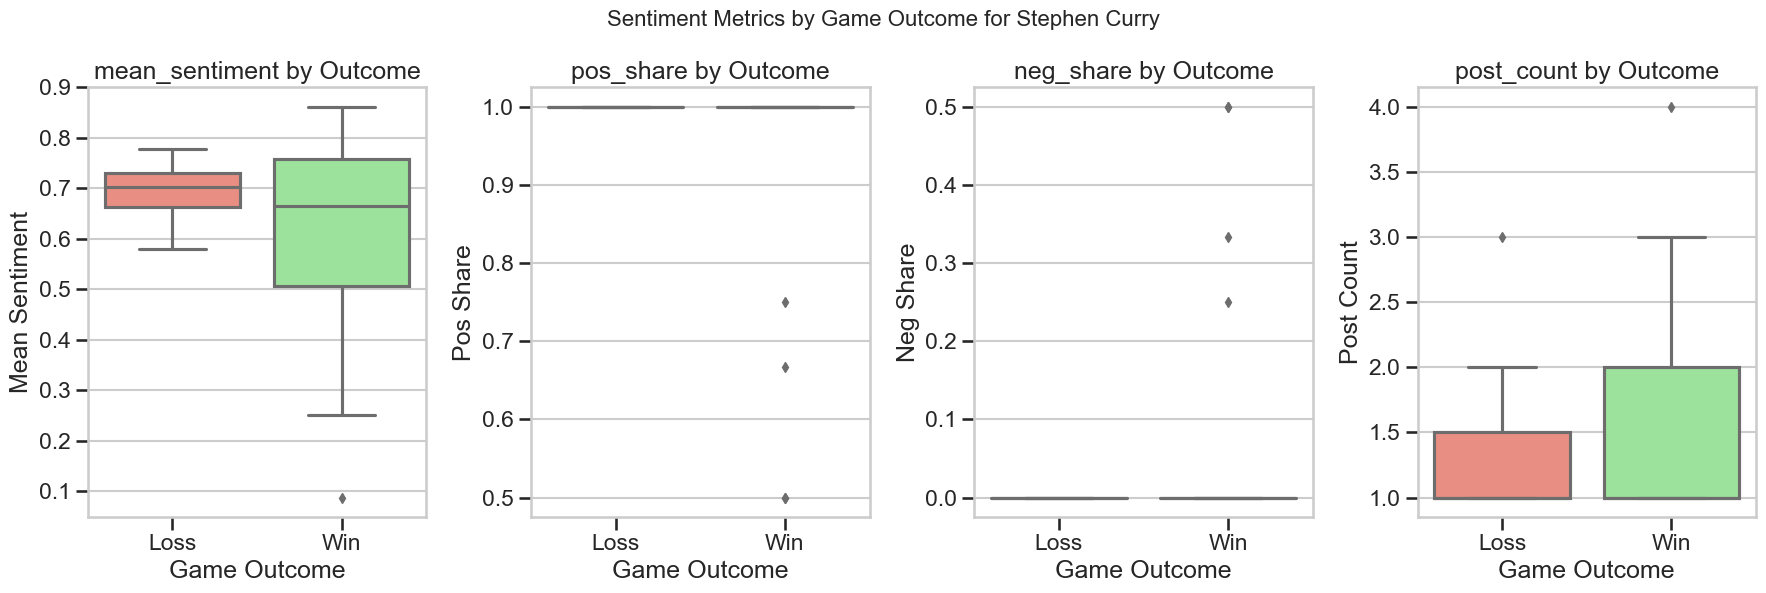


--- Finished processing Stephen Curry ---


✅ Combined data for 8 players into df_all_players_combined (193 total game rows with sentiment).


In [ ]:
all_players_data_list = []
if not player_files_info:
    print("No player files were found to process. Halting execution.")
else:
    for player_info in player_files_info:
        PLAYER_SLUG = player_info["slug"]
        PLAYER_NAME_DISPLAY = player_info["display_name"]
        input_file_path = player_info["file_path"]

        print(f"\n\n{'='*20} PROCESSING: {PLAYER_NAME_DISPLAY} {'='*20}")
        
        df_player = load_and_preprocess_data(input_file_path, PLAYER_NAME_DISPLAY)

        if df_player is None or df_player.empty:
            print(f"--- Skipping further analysis for {PLAYER_NAME_DISPLAY} due to missing data or no games with sentiment ---")
            continue

        print(f"\n--- Univariate Distributions for {PLAYER_NAME_DISPLAY} ---")
        performance_features_to_plot = ['PTS', 'AST', 'REB', 'PLUS_MINUS', 'FG_PCT']
        sentiment_features_to_plot = ['mean_sentiment', 'pos_share', 
                                      'neg_share' if 'neg_share' in df_player.columns else 'min_sentiment', 
                                      'post_count', 'avg_delta_days']
        
        plt.figure(figsize=(18, 10))
        plot_idx = 1
        for col_list, sup_title_part in [(performance_features_to_plot, "Performance"), (sentiment_features_to_plot, "Sentiment Metrics")]:
            for col in col_list:
                if col in df_player.columns and not df_player[col].isnull().all():
                    plt.subplot(2, max(len(performance_features_to_plot), len(sentiment_features_to_plot)), plot_idx)
                    sns.histplot(df_player[col].dropna(), kde=True, bins=15)
                    plt.title(f'Distribution of {col}')
                    plt.xlabel(col)
                    plt.ylabel('Frequency')
                    plot_idx +=1
                else:
                    print(f"  Skipping histogram for missing/empty column: {col}")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.suptitle(f'Univariate Distributions for {PLAYER_NAME_DISPLAY}', y=1.00, fontsize=16)
        plt.show()

        print(f"\n--- Correlation Analysis for {PLAYER_NAME_DISPLAY} ---")
        numerical_stats_cols = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'WIN', 'MIN']
        numerical_sentiment_cols = ['mean_sentiment', 'min_sentiment', 'max_sentiment', 'pos_share', 
                                    'neg_share' if 'neg_share' in df_player.columns else None, 
                                    'post_count', 'avg_delta_days', 'min_delta_days', 'max_delta_days']
        numerical_sentiment_cols = [col for col in numerical_sentiment_cols if col is not None]

        correlation_features = [col for col in numerical_stats_cols if col in df_player.columns and pd.api.types.is_numeric_dtype(df_player[col])] + \
                               [col for col in numerical_sentiment_cols if col in df_player.columns and pd.api.types.is_numeric_dtype(df_player[col])]
        
        df_corr = df_player[list(set(correlation_features))].copy()
        
        for col in df_corr.columns:
            df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')
        df_corr.dropna(inplace=True)

        if len(df_corr) > 1 and len(df_corr.columns) > 1:
            correlation_matrix = df_corr.corr()
            plt.figure(figsize=(18, 15))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 7})
            plt.title(f'Correlation Matrix for {PLAYER_NAME_DISPLAY}', fontsize=16)
            plt.xticks(rotation=45, ha='right', fontsize=8)
            plt.yticks(rotation=0, fontsize=8)
            plt.tight_layout()
            plt.show()
        else:
            print("  Not enough data or columns for correlation matrix.")

        print(f"\n--- Unsupervised Clustering for {PLAYER_NAME_DISPLAY} ---")

        cluster_features = [
            'PTS', 'AST', 'REB', 'PLUS_MINUS',
            'mean_sentiment', 'sent_intensity'
        ]
        cluster_features = [c for c in cluster_features if c in df_player.columns]

        X = df_player[cluster_features].fillna(0)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        print("   • PCA two‑component variance:",
              round(pca.explained_variance_ratio_.sum(), 3))

        inertias = []
        for k in range(1, 8):
            inertias.append(
                KMeans(n_clusters=k, n_init=10, random_state=42)
                .fit(X_scaled).inertia_
            )
        plt.figure(figsize=(4, 3))
        plt.plot(range(1, 8), inertias, marker='o')
        plt.title('Elbow for K‑means'); plt.xlabel('k'); plt.ylabel('Inertia')
        plt.show()

        k = 3
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        df_player['cluster'] = kmeans.fit_predict(X_scaled)

        plt.figure(figsize=(7, 6))
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                        hue=df_player['cluster'], palette='Set2', s=80)
        plt.title(f'PCA space – {PLAYER_NAME_DISPLAY}')
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.legend(title='Cluster')
        plt.show()

        profile_cols = cluster_features + (['WIN'] if 'WIN' in df_player.columns else [])
        print("Cluster medians:")
        display(
            df_player.groupby('cluster')[profile_cols]
                     .median()
                     .round(2)
        )

        print(f"\n--- Bivariate Scatter Plots for {PLAYER_NAME_DISPLAY} ---")
        key_relationships = [
            ('PTS', 'mean_sentiment'), ('PLUS_MINUS', 'mean_sentiment'),
            ('PTS', 'post_count'), ('WIN', 'mean_sentiment'),
            ('FG_PCT', 'mean_sentiment'), ('mean_sentiment', 'avg_delta_days')
        ]
        plt.figure(figsize=(20, 10))
        plot_idx = 1
        for x_col, y_col in key_relationships:
            if x_col in df_player.columns and y_col in df_player.columns:
                plt.subplot(2, 3, plot_idx)
                if x_col == 'WIN' and not df_player[x_col].isnull().all():
                    sns.boxplot(x=df_player[x_col].astype(int), y=df_player[y_col].dropna(), palette={0: 'red', 1: 'green'})
                    plt.xticks([0,1], ['Loss', 'Win'])
                elif not df_player[x_col].isnull().all() and not df_player[y_col].isnull().all():
                    sns.scatterplot(data=df_player, x=x_col, y=y_col, hue='WIN' if 'WIN' in df_player.columns else None, 
                                    palette={0: 'red', 1: 'green'} if 'WIN' in df_player.columns else None, alpha=0.7)
                    try:
                        sns.regplot(data=df_player, x=x_col, y=y_col, scatter=False, color='blue', line_kws={'linestyle':'--'})
                    except ValueError:
                        print(f"Could not plot regression line for {x_col} vs {y_col} (possibly due to low variance or NaNs).")
                plt.title(f'{x_col} vs. {y_col}')
                plot_idx += 1
            else:
                 print(f"  Skipping bivariate plot: missing {x_col} or {y_col}")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.suptitle(f'Key Bivariate Relationships for {PLAYER_NAME_DISPLAY}', y=1.00, fontsize=18)
        plt.show()

        if 'WIN' in df_player.columns and not df_player['WIN'].isnull().all():
            print(f"\n--- Sentiment Analysis by Game Outcome for {PLAYER_NAME_DISPLAY} ---")
            plt.figure(figsize=(18, 6))
            sentiment_metrics_for_outcome = ['mean_sentiment', 'pos_share', 
                                             'neg_share' if 'neg_share' in df_player.columns else 'min_sentiment', 
                                             'post_count']
            plot_idx = 1
            for metric in sentiment_metrics_for_outcome:
                if metric in df_player.columns and not df_player[metric].isnull().all():
                    plt.subplot(1, len(sentiment_metrics_for_outcome), plot_idx)
                    sns.boxplot(x='WIN', y=metric, data=df_player, palette={0: 'salmon', 1: 'lightgreen'})
                    plt.title(f'{metric} by Outcome')
                    plt.xticks([0, 1], ['Loss', 'Win'])
                    plt.xlabel('Game Outcome')
                    plt.ylabel(metric.replace('_', ' ').title())
                    plot_idx +=1
                else:
                    print(f"  Skipping outcome plot for missing/empty column: {metric}")
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.suptitle(f'Sentiment Metrics by Game Outcome for {PLAYER_NAME_DISPLAY}', y=1.00, fontsize=16)
            plt.show()
        else:
            print(f"  Skipping sentiment by game outcome for {PLAYER_NAME_DISPLAY} (WIN column missing or all NaN).")

        if df_player is not None and not df_player.empty:
            df_player_copy = df_player.copy() # Make a copy
            df_player_copy['player_slug'] = PLAYER_SLUG # Add a column to identify the player (THIS TOOK FOREVER TO FIGURE OUT)
            all_players_data_list.append(df_player_copy)
        print(f"\n--- Finished processing {PLAYER_NAME_DISPLAY} ---")

if all_players_data_list:
    df_all_players_combined = pd.concat(all_players_data_list, ignore_index=True)
    print(f"\n\n Combined data for {len(all_players_data_list)} players into df_all_players_combined ({len(df_all_players_combined)} total game rows with sentiment).")

else:
    print("No data was accumulated for combined analysis. 'df_all_players_combined' will not be created.")
    df_all_players_combined = pd.DataFrame() # Create an empty df to avoid errors in next cell





📊 GRAND AGGREGATE VISUALIZATIONS & ANALYSIS (Across All Processed Players) 📊


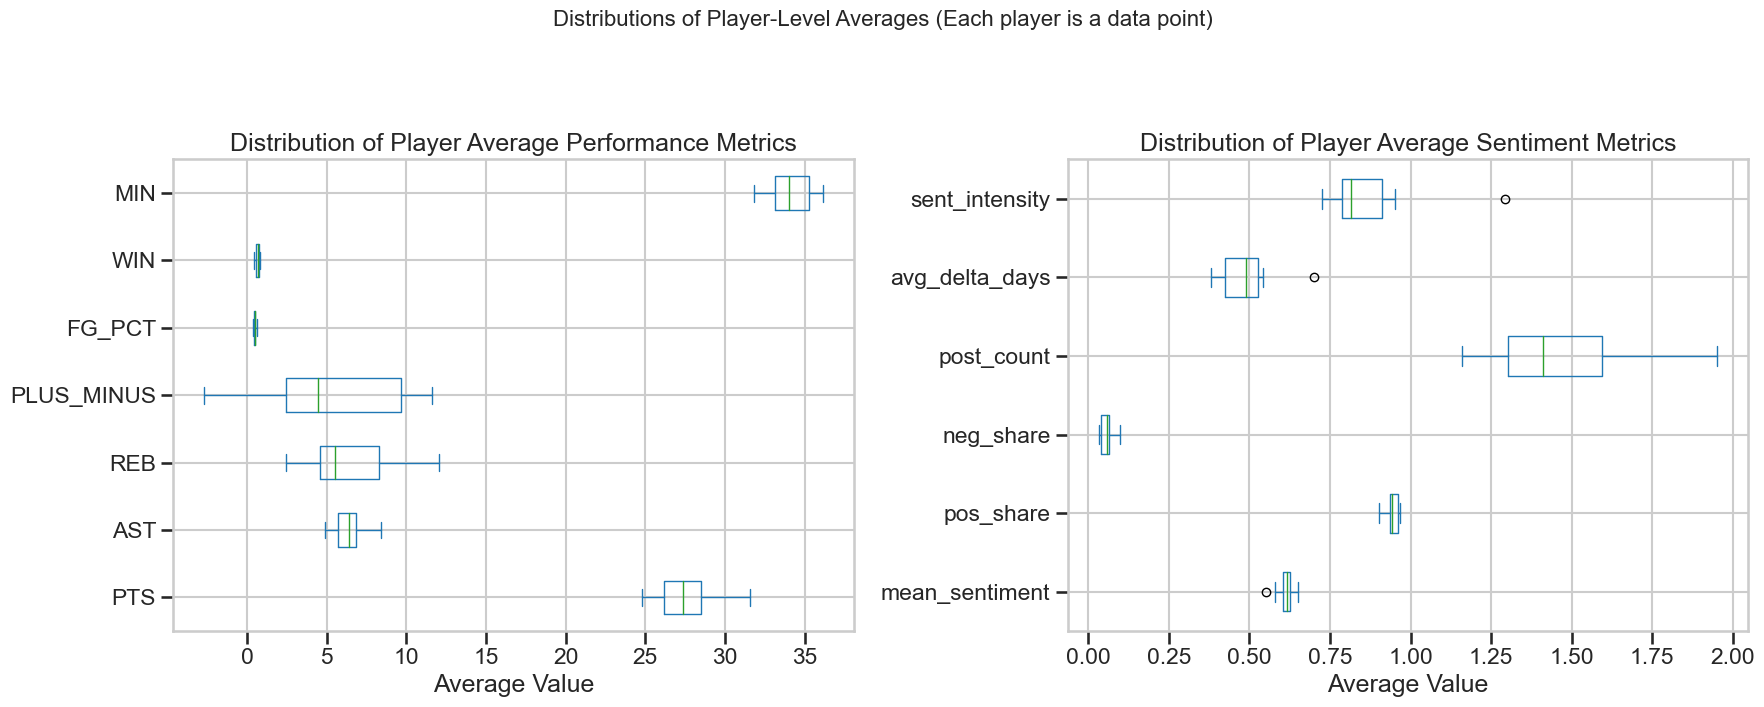


--- Key Relationship Scatter Plots (All Games, All Players) ---


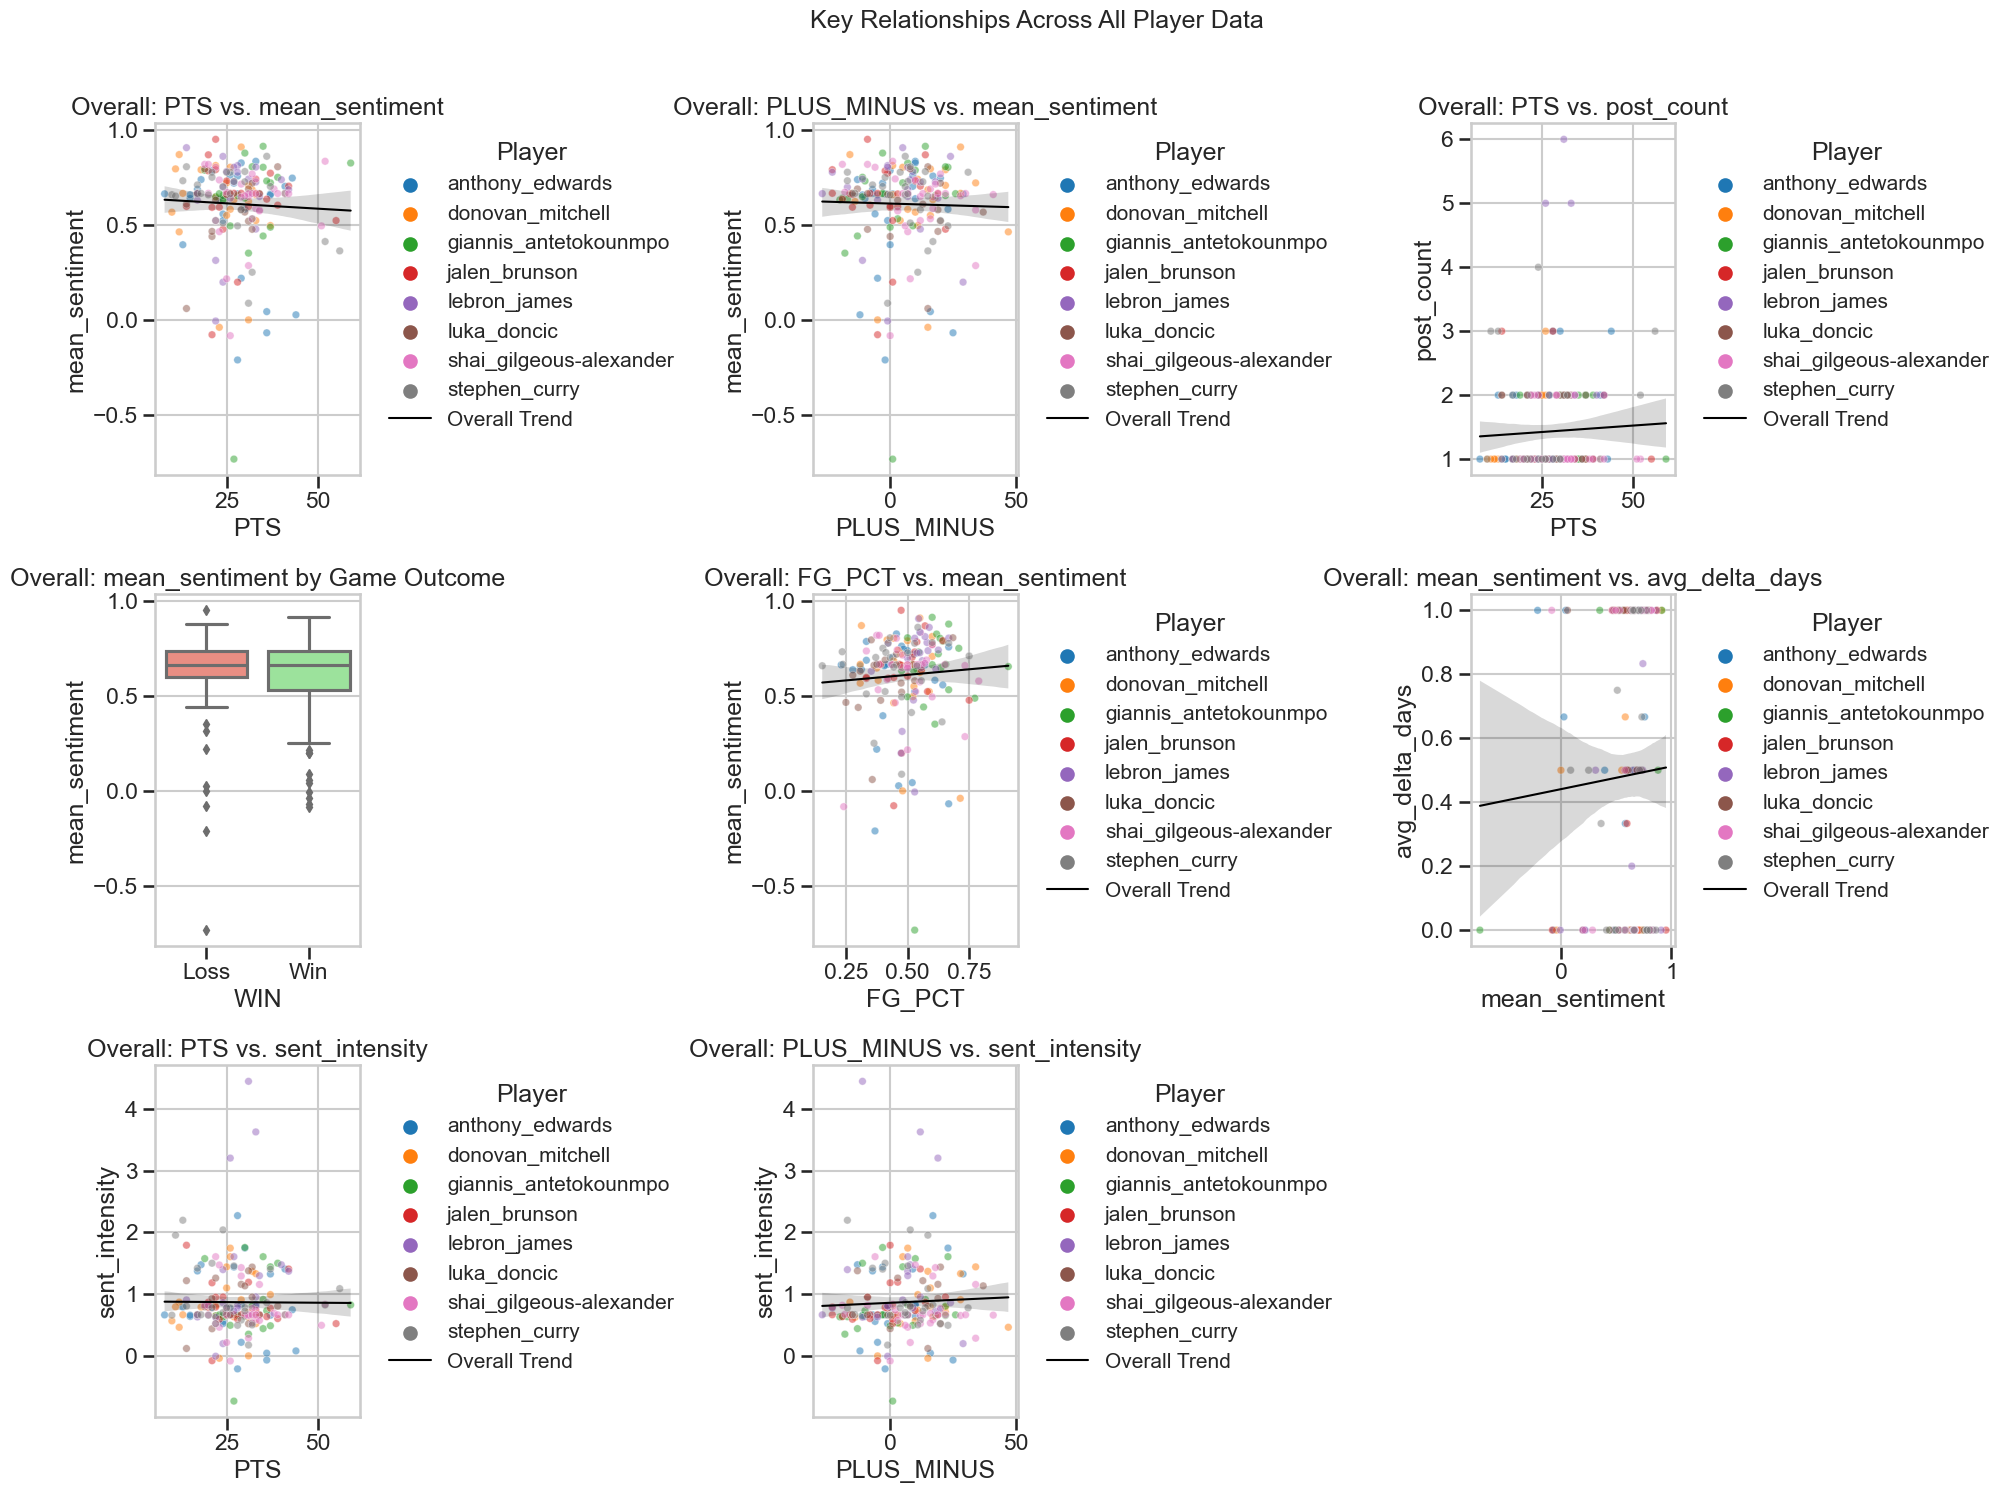


--- Overall Mean Sentiment by Game Outcome (All Players) ---


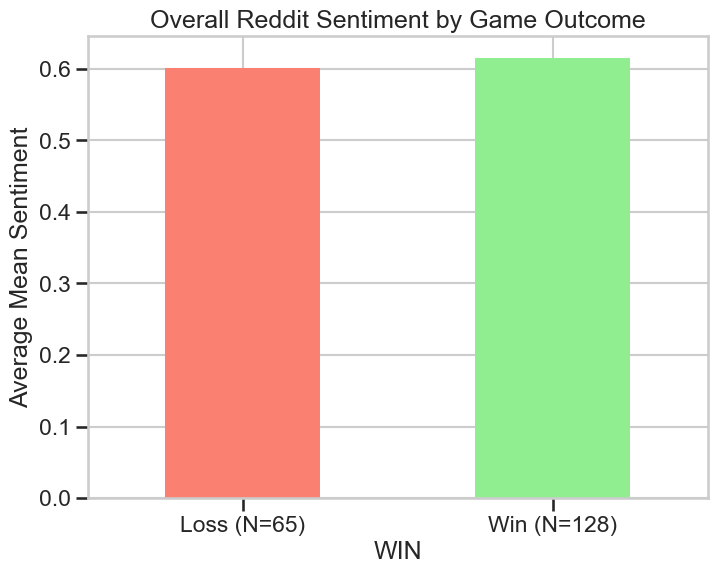


--- GRAND MEAN VALUES FOR KEY COLUMNS (All Players, All Games with Sentiment) ---
Grand Means Table:


Grand Mean
PTS                 27.891
AST                  6.264
REB                  6.218
PLUS_MINUS           5.378
FG_PCT               0.495
WIN                  0.663
MIN                 34.067
mean_sentiment       0.611
pos_share            0.943
neg_share            0.057
post_count           1.435
avg_delta_days       0.484
sent_intensity       0.870



🏁 All Players Processed! 🏁


In [5]:
# ===================================================================================
# COMBINING ALL OF THEM SO WE CAN ACTUALLY GET A FEW USEFUL ONES THAT ARENT JUST SPAM
# ===================================================================================

if 'df_all_players_combined' in locals() and not df_all_players_combined.empty:
    print("\n\nGRAND AGGREGATE VISUALIZATIONS & ANALYSIS (Across All Processed Players) ")

    # --- 5.0 Helper sets (ensure columns exist in the combined dataframe) ---
    all_cols = df_all_players_combined.columns
    
    perf_cols  = [col for col in ['PTS', 'AST', 'REB', 'PLUS_MINUS', 'FG_PCT', 'WIN', 'MIN'] if col in all_cols]
    senti_cols = [col for col in ['mean_sentiment', 'pos_share', 
                                  'neg_share' if 'neg_share' in all_cols else 'min_sentiment', 
                                  'post_count', 'avg_delta_days', 'sent_intensity'] if col in all_cols]
    
    key_pairs_template  = [
        ('PTS', 'mean_sentiment'), ('PLUS_MINUS', 'mean_sentiment'),
        ('PTS', 'post_count'), ('WIN', 'mean_sentiment'),
        ('FG_PCT', 'mean_sentiment'), ('mean_sentiment', 'avg_delta_days'),
        ('PTS', 'sent_intensity'), ('PLUS_MINUS', 'sent_intensity')
    ]
    key_pairs = [(x,y) for x,y in key_pairs_template if x in all_cols and y in all_cols]

    # --- 5.1 Distributions of Player-Level Means ---
    # Calculate mean per player for key metrics
    if 'player_slug' in df_all_players_combined.columns:
        player_means_perf = df_all_players_combined.groupby('player_slug')[perf_cols].mean()
        player_means_senti = df_all_players_combined.groupby('player_slug')[senti_cols].mean()

        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        
        # Performance player means distribution
        if not player_means_perf.empty:
            player_means_perf.plot(kind='box', ax=axes[0], vert=False)
            axes[0].set_title('Distribution of Player Average Performance Metrics')
            axes[0].set_xlabel('Average Value')
        else:
            axes[0].set_title('No Player Average Performance Data')

        # Sentiment player means distribution
        if not player_means_senti.empty:
            player_means_senti.plot(kind='box', ax=axes[1], vert=False)
            axes[1].set_title('Distribution of Player Average Sentiment Metrics')
            axes[1].set_xlabel('Average Value')
        else:
            axes[1].set_title('No Player Average Sentiment Data')
            
        plt.suptitle("Distributions of Player-Level Averages (Each player is a data point)", fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        print("'player_slug' column not found in df_all_players_combined. Cannot create player-level mean distributions.")

    # --- 5.2 Scatter Plots of All Game Data (Colored by Player if < N players, or with overall trend) ---
    print("\n--- Key Relationship Scatter Plots (All Games, All Players) ---")
    num_players = df_all_players_combined['player_slug'].nunique() if 'player_slug' in df_all_players_combined.columns else 1
    use_player_hue = num_players <= 10 and 'player_slug' in df_all_players_combined.columns # Only use hue if few players

    plt.figure(figsize=(20, 15 if len(key_pairs) > 3 else 10))
    for idx, (x_col, y_col) in enumerate(key_pairs):
        plt.subplot( (len(key_pairs) + 2) // 3, 3, idx + 1) # Dynamic subplot grid
        
        if x_col == 'WIN':
            sns.boxplot(data=df_all_players_combined, x=x_col, y=y_col, palette={0: 'salmon', 1: 'lightgreen'})
            plt.xticks([0,1], ['Loss', 'Win'])
            plt.title(f'Overall: {y_col} by Game Outcome')
        else:
            hue_arg = 'player_slug' if use_player_hue else None
            sns.scatterplot(data=df_all_players_combined, x=x_col, y=y_col, hue=hue_arg, 
                            alpha=0.5, s=30, legend='auto' if use_player_hue else False)
            
            # Overall regression line
            sns.regplot(data=df_all_players_combined, x=x_col, y=y_col, scatter=False, color='black', 
                        line_kws={'linestyle':'-', 'linewidth': 1.5}, label="Overall Trend")
            
            plt.title(f'Overall: {x_col} vs. {y_col}')
            plt.xlabel(x_col)
            plt.ylabel(y_col)
            if use_player_hue:
                 plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle("Key Relationships Across All Player Data", fontsize=18, y=1.00)
    plt.show()

    # --- 5.3 Overall Sentiment by Game Outcome (Aggregated Bar Chart) ---
    if 'WIN' in df_all_players_combined.columns and 'mean_sentiment' in df_all_players_combined.columns:
        print("\n--- Overall Mean Sentiment by Game Outcome (All Players) ---")
        plt.figure(figsize=(8, 6))
        outcome_summary = df_all_players_combined.groupby('WIN')['mean_sentiment'].agg(['mean', 'count'])
        
        if 0 in outcome_summary.index and 1 in outcome_summary.index:
            outcome_summary['mean'].rename({0: f"Loss (N={outcome_summary.loc[0,'count']})", 
                                            1: f"Win (N={outcome_summary.loc[1,'count']})"}).plot(kind='bar', color=['salmon', 'lightgreen'])
            plt.ylabel('Average Mean Sentiment')
            plt.title('Overall Reddit Sentiment by Game Outcome')
            plt.xticks(rotation=0)
            plt.show()
        else:
            print(" Not enough data for both Wins and Losses to plot sentiment by outcome.")
            
    # --- 5.4 Table of Grand Means for Key Columns ---
    print("\n--- GRAND MEAN VALUES FOR KEY COLUMNS (All Players, All Games with Sentiment) ---")
    key_numeric_cols = [col for col in perf_cols + senti_cols if col in df_all_players_combined.columns and pd.api.types.is_numeric_dtype(df_all_players_combined[col])]
    grand_means = df_all_players_combined[key_numeric_cols].mean().round(3)
    
    # I ghave NO IDEA IF THIS IS EVEN WORKING LOLLL
    from IPython.display import display
    print("Grand Means Table:")
    display(pd.DataFrame(grand_means, columns=['Grand Mean']))

else:
    print("'df_all_players_combined' is not defined or is empty. Cannot generate grand aggregate visuals.")

print("\n\n🏁 All Players Processed! RRRAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHHHHHHHHHHHHHHHHHHHHH🏁")